# Lung disease follow-up analysis

In this notebook we explore targets with different types of evidence for lung diseases

In [1]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import cellxgene_census

In [2]:
import upsetplot

In [3]:
from sc_target_evidence_utils import preprocessing_utils
from sc_target_evidence_utils import DE_utils, cellontology_utils

In [4]:
import json

In [25]:
from sc_target_evidence_utils import cellontology_utils
output_dir = '../data/'
graph = cellontology_utils.get_cellontology_graph(output_dir)

R plotting setup

In [27]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [28]:
%load_ext rpy2.ipython

In [29]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [30]:
%%R

### Plotting utils
evidence_labels <- c(
    "all_sc_evidence" = "both", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "DE in disease", 
    "ct_marker_evidence" = "Cell type marker", 
    "has_genetic_support" = "Genetic association"
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    text_position='right',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'all_sc_evidence')
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=rev(c('druggable', 'safe', 'effective', 'approved')))) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha)
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=clinical_status, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                  x = ifelse(text_position == 'right', Inf, -Inf) , 
                  hjust= ifelse(text_position == 'right', 1.1, -0.1) , 
                  color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Drug target class') +
        theme_classic(base_size=20) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

In [34]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['TARBP1', 'SMG6', 'P2RX5', ..., 'GPR25', 'C3AR1', 'PPIA'],
      dtype=object)

In [35]:
reversed_annos = {value: key for key, values in annos.items() for value in values}

In [714]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['TARBP1', 'SMG6', 'P2RX5', ..., 'GPR25', 'C3AR1', 'PPIA'],
      dtype=object)

## Load metadata

In [7]:
## Load donor metadata in cxg
cxg_metadata = pd.read_csv('../data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

In [8]:
disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [9]:
lung_cxg_metadata = cxg_metadata[cxg_metadata['tissue_general'] == 'lung'].copy()

Save IDs for lung disease of interest: selecting COPD, pulmonary fibrosis, pneumonia and cystic fibrosis which have samples only from HLCA (fine celltype annotation available)

In [10]:
lung_disease_ids = [x for x in lung_cxg_metadata.disease_ontology_id.unique() if x.startswith('MONDO')]

In [11]:
select_diseases = ['pulmonary fibrosis', 'cystic fibrosis', 'chronic obstructive pulmonary disease','pneumonia']
select_diseases_ids = [k for k,v in disease_name_mapper.items() if v in select_diseases]
select_diseases_ids

['MONDO:0002771', 'MONDO:0005249', 'MONDO:0009061', 'MONDO:0005002']

In [12]:
lung_cxg_metadata[lung_cxg_metadata.disease.isin(select_diseases)].groupby(['disease', 'dataset_id']).size()

disease                                dataset_id                          
chronic obstructive pulmonary disease  1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1    18
cystic fibrosis                        9f222629-9e39-47d0-b83f-e08d610c7479    22
pneumonia                              9f222629-9e39-47d0-b83f-e08d610c7479    13
pulmonary fibrosis                     9f222629-9e39-47d0-b83f-e08d610c7479     6
dtype: int64

## Download extended HLCA data with annotations

In [13]:
output_dir = '../data/'

In [14]:
OBS_COLS = [
            "assay", 
            "tissue_general", 
            "suspension_type", 
            "disease", 
            'donor_id', 
            'cell_type_ontology_term_id',
            'cell_type',
            'is_primary_data'
    ]

# Subset to relevant datasets
dataset_ids = ['9f222629-9e39-47d0-b83f-e08d610c7479']
tissue_ids = ['lung']

Download from cellxgene census (`dataset_id = 9f222629-9e39-47d0-b83f-e08d610c7479`)

In [15]:
# cellxgene_census.download_source_h5ad('9f222629-9e39-47d0-b83f-e08d610c7479', to_path='../data/hlca_census.h5ad', census_version = "2023-07-25")

In [33]:
hlca_adata_full = sc.read_h5ad('../data/hlca_census.h5ad', backed=True)

In [34]:
del hlca_adata_full.layers['soupX']
del hlca_adata_full.obsp
del hlca_adata_full.obsm

In [35]:
import gc
gc.collect()

4352

In [37]:
## Load target data
targets = pd.read_csv('../data/TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.csv', index_col=0)

In [38]:
# disease_ontology_id = select_diseases_ids[0]

In [39]:
select_diseases_ids

['MONDO:0002771', 'MONDO:0005249', 'MONDO:0009061', 'MONDO:0005002']

In [41]:
output_dir = '../data/'
# for disease_ontology_id in select_diseases_ids[1:]:
disease_ontology_id = 'MONDO:0005002'
## Get list of all possible genes you might need 
if "_" in disease_ontology_id:
    disease_ontology_id = disease_ontology_id.replace("_", ":")
target_genes = targets[targets['cxg_matched_id'] == disease_ontology_id.replace(":", "_")].targetId.tolist()

json_file =   output_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

all_genes_ls = sum([x for x in universe_dict.values()], [])
all_genes_ls.extend(target_genes)
all_genes_ls = list(set(all_genes_ls))

## Filter full dataset
disease_ids = ['PATO:0000461', disease_ontology_id]
hlca_adata = hlca_adata_full[(hlca_adata_full.obs['tissue'].isin(['lung', 'lung parenchyma'])) & 
                        (hlca_adata_full.obs['disease_ontology_term_id'].isin(disease_ids)) &
                        (hlca_adata_full.obs['is_primary_data'])
                       ]

hlca_adata_X = hlca_adata.raw.to_adata()
raw_sum = np.array(hlca_adata_X.X.sum(1)).flatten()

hlca_adata_X = hlca_adata_X[:, hlca_adata_X.var_names.isin(all_genes_ls)].copy()
hlca_adata_X.obs['tissue_general'] = 'lung'
hlca_adata_X.obs = hlca_adata_X.obs[OBS_COLS].copy()
hlca_adata_X.obs['total_counts'] = raw_sum
hlca_adata_X.obs['disease_ontology_id'] = disease_ontology_id

# Exclude blacklisted assays
assay_blacklist = [
    'BD Rhapsody Targeted mRNA',
    'STRT-seq',
    'inDrop'
    ]

hlca_adata_X = hlca_adata_X[~hlca_adata_X.obs['assay'].isin(assay_blacklist)].copy()

# Store fine annotation
hlca_adata_X.obs['cell_type'] = hlca_adata.obs['ann_finest_level'].copy()
hlca_adata_X.obs["high_level_cell_type_ontology_term_id"] = [
    x if x != 'Unknown' else 'low_quality_annotation' for x in hlca_adata_X.obs['cell_type']
    ]

# Pseudo-bulk by celltype-donor
print("Pseudo-bulking...")
pbulk_adata = preprocessing_utils.anndata2pseudobulk(hlca_adata_X, 
                                 group_by=['high_level_cell_type_ontology_term_id', 'assay', 'suspension_type', 'disease', 'donor_id'],
                                 min_ncells=5       
                                )

pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'] != 'low_quality_annotation'].copy()
pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].copy()

pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]
pbulk_adata.obs['disease_ontology_id'] = disease_ontology_id

# Save
pbulk_adata.write_h5ad(output_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":","_")}.pbulk_all_genes.h5ad')

NameError: name 'OBS_COLS' is not defined

## Run DE analysis

In [ ]:
data_dir = '../data/'
n_hvgs = 5000

for disease_ontology_id in select_diseases_ids:
    # Load pseudobulk data
    pbulk_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    sc.pp.filter_genes(pbulk_adata, min_cells = 3) # exclude genes expressed in < 3 pseudobulk samples
    pbulk_adata.var['feature_id'] = pbulk_adata.var_names.values

    # Run DE analysis
    ct_res = DE_utils.celltype_marker_targets(pbulk_adata, n_hvgs = n_hvgs)
    ct_res.to_csv(f'{data_dir}/HLCA_annotation_DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')

/tmp/ipykernel_6485/838054445.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/tmp/ipykernel_6485/838054445.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:5

In [28]:
pbulk_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

In [30]:
pbulk_adata.obs

high_level_cell_type_ontology_term_id  \
Classical monocytes-Drop-seq-cell-normal-homosa...                   Classical monocytes   
EC arterial-10x 3' v3-nucleus-normal-homosapien...                           EC arterial   
Alveolar macrophages-10x 3' v3-cell-normal-homo...                  Alveolar macrophages   
DC2-Seq-Well-cell-normal-homosapiens_None_2023_...                                   DC2   
CD8 T cells-10x 3' v3-cell-normal-homosapiens_N...                           CD8 T cells   
...                                                                                  ...   
EC general capillary-10x 3' v3-cell-normal-homo...                  EC general capillary   
pre-TB secretory-10x 3' v2-cell-normal-homosapi...                      pre-TB secretory   
Alveolar Mph CCL3+-10x 3' v3-cell-normal-homosa...                    Alveolar Mph CCL3+   
Deuterosomal-Drop-seq-cell-normal-homosapiens_N...                          Deuterosomal   
Monocyte-derived Mph-Drop-seq-cell-normal-homos...                  Monocyte-derived Mph   

                                                        assay suspension_type  \
Classical monocytes-Drop-seq-cell-normal-homosa...   Drop-seq            cell   
EC arterial-10x 3' v3-nucleus-normal-homosapien...  10x 3' v3         nucleus   
Alveolar macrophages-10x 3' v3-cell-normal-homo...  10x 3' v3            cell   
DC2-Seq-Well-cell-normal-homosapiens_None_2023_...   Seq-Well            cell   
CD8 T cells-10x 3' v3-cell-normal-homosapiens_N...  10x 3' v3            cell   
...                                                       ...             ...   
EC general capillary-10x 3' v3-cell-normal-homo...  10x 3' v3            cell   
pre-TB secretory-10x 3' v2-cell-normal-homosapi...  10x 3' v2            cell   
Alveolar Mph CCL3+-10x 3' v3-cell-normal-homosa...  10x 3' v3            cell   
Deuterosomal-Drop-seq-cell-normal-homosapiens_N...   Drop-seq            cell   
Monocyte-derived Mph-Drop-seq-cell-normal-homos...   Drop-seq            cell   

                                                   disease  \
Classical monocytes-Drop-seq-cell-normal-homosa...  normal   
EC arterial-10x 3' v3-nucleus-normal-homosapien...  normal   
Alveolar macrophages-10x 3' v3-cell-normal-homo...  normal   
DC2-Seq-Well-cell-normal-homosapiens_None_2023_...  normal   
CD8 T cells-10x 3' v3-cell-normal-homosapiens_N...  normal   
...                                                    ...   
EC general capillary-10x 3' v3-cell-normal-homo...  normal   
pre-TB secretory-10x 3' v2-cell-normal-homosapi...  normal   
Alveolar Mph CCL3+-10x 3' v3-cell-normal-homosa...  normal   
Deuterosomal-Drop-seq-cell-normal-homosapiens_N...  normal   
Monocyte-derived Mph-Drop-seq-cell-normal-homos...  normal   

                                                                                             donor_id  \
Classical monocytes-Drop-seq-cell-normal-homosa...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
EC arterial-10x 3' v3-nucleus-normal-homosapien...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
Alveolar macrophages-10x 3' v3-cell-normal-homo...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
DC2-Seq-Well-cell-normal-homosapiens_None_2023_...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
CD8 T cells-10x 3' v3-cell-normal-homosapiens_N...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
...                                                                                               ...   
EC general capillary-10x 3' v3-cell-normal-homo...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
pre-TB secretory-10x 3' v2-cell-normal-homosapi...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
Alveolar Mph CCL3+-10x 3' v3-cell-normal-homosa...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
Deuterosomal-Drop-seq-cell-normal-homosapiens_N...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
Monocyte-derived Mph-Drop-seq-cell-normal-homos...  homosapiens_None_2023

In [14]:
data_dir = '../data/'
n_hvgs = 5000

for disease_ontology_id in select_diseases_ids:
    # Load pseudobulk data
    pbulk_adata = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
    sc.pp.filter_genes(pbulk_adata, min_cells = 3) # exclude genes expressed in < 3 pseudobulk samples
    pbulk_adata.var['feature_id'] = pbulk_adata.var_names.values

    # Run DE analysis
    disease_res, bulk_res = DE_utils.disease_marker_targets(pbulk_adata, n_hvgs = n_hvgs)
    disease_res.to_csv(f'{data_dir}/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res.to_csv(f'{data_dir}/HLCA_annotation_DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

/tmp/ipykernel_1790/3475836243.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/tmp/ipykernel_1790/3475836243.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pbulk_adata.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(")", '').str.replace("(", '').str.replace(" ", "_").str.replace("-", "_").str.replace("+", "pos")
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/sc_target_evidence_utils/D

IndexError: index 0 is out of bounds for axis 0 with size 0

In [58]:
select_diseases_ids

['MONDO:0002771', 'MONDO:0005249', 'MONDO:0009061', 'MONDO:0005002']

## Compare prioritized targets

In [178]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.1,
    DE2evidence_celltype_params = {"lfc_thresh":1.0, 'ct_fraction_thresh':1.0},
    DE2evidence_disease_params = {"lfc_thresh":1.0, 'lfc_group':'all'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    ct_res = pd.read_csv(f'{data_dir}/HLCA_annotation_DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/HLCA_annotation_DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    disease_evidence = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    evidence_dict.update(disease_evidence)
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)

    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [176]:
from sc_target_evidence_utils import association_utils, sc_evidence_utils

In [177]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

In [736]:
targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv')

### IPF

In [739]:
from sc_target_evidence_utils.cellontology_utils import ontology2name

In [740]:
disease_ontology_id = 'MONDO_0002771'

In [741]:
pbulk_adata_fine = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

## Exclude genes that are not measured in HLCA dataset
exclude_genes = np.setdiff1d(pbulk_adata_coarse.var_names, pbulk_adata_fine.var_names)

pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()
pbulk_adata_fine[pbulk_adata_fine.obs['disease'] != 'normal'].obs.donor_id.nunique()

6

In [742]:
## Preprocess expression
def _process_pbulk(pbulk_adata):
    cpms = scipy.sparse.csr_matrix(pbulk_adata_coarse.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
    pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
    pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()

    pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(":", '_')
    pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['plot_ct_id'].astype('category')
    ct_levels = [f'{ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].cat.categories.str.replace("_", ":").tolist()]
    pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].str.replace("_", ":").tolist()]
    pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].astype('category').cat.reorder_categories(ct_levels)
    return(pbulk_adata)

pbulk_adata_coarse = _process_pbulk(pbulk_adata_coarse)


In [743]:
targets_res_fine = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'all'}
        )

In [744]:
## Read results with coarse annotations
targets_res_coarse = targets_evidence_all[targets_evidence_all.disease_ontology_id == disease_ontology_id]

In [745]:
targets_res_fine = targets_res_fine[~targets_res_fine.gene_id.isin(exclude_genes)]
targets_res_coarse = targets_res_coarse[~targets_res_coarse.gene_id.isin(exclude_genes)]

In [746]:
targets_res_fine.sum()

gene_id                  ENSG00000027697ENSG00000037280ENSG00000040275E...
disease_ontology_id      MONDO_0002771MONDO_0002771MONDO_0002771MONDO_0...
genetic_association                                               4.909033
known_drug                                                        9.399952
is_druggable                                                          19.0
is_safe                                                               14.0
is_effective                                                          12.0
is_approved                                                           10.0
has_genetic_support                                                   17.0
ct_marker_evidence                                                  1388.0
bulk_disease_evidence                                                140.0
disease_evidence                                                     398.0
disease_ct_evidence                                                  363.0
dtype: object

In [747]:
targets_res_coarse.sum()

/tmp/ipykernel_2113/3764932892.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  targets_res_coarse.sum()


Unnamed: 0.1                                                      1487608830
Unnamed: 0                                                          97072765
gene_id                    ENSG00000027697ENSG00000037280ENSG00000040275E...
disease_ontology_id        MONDO_0002771MONDO_0002771MONDO_0002771MONDO_0...
genetic_association                                                 4.909033
known_drug                                                          9.399952
is_druggable                                                            19.0
is_safe                                                                 14.0
is_effective                                                            12.0
is_approved                                                             10.0
has_genetic_support                                                     17.0
ct_marker_evidence                                                    1161.0
bulk_disease_evidence                                                   73.0

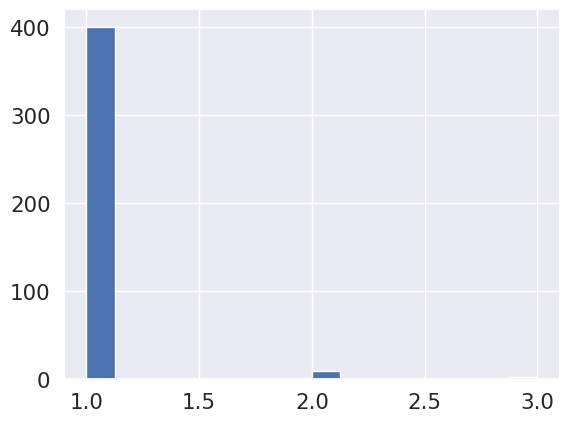

In [748]:
df_dis = get_evidence_celltypes(DE_res_coarse, targets_res_coarse, evidence='disease', clinical_status_cols=[], signif_alpha=0.01)
plt.hist(df_dis.sum(1), bins=df_dis.shape[1]+1);

In [749]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

In [750]:
results_all_df = pd.DataFrame()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence']:
            or_df = association_utils.get_OR(targets_res_coarse, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'coarse'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(targets_res_fine, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'fine'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


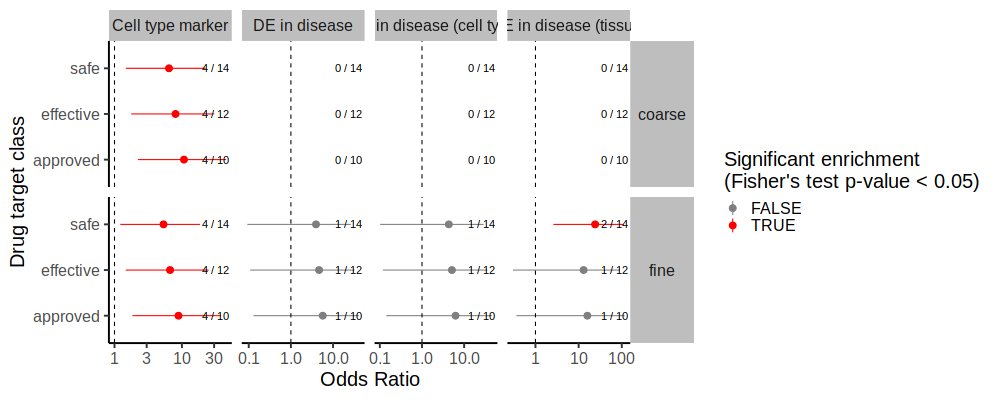

In [751]:
%%R -i results_all_df -w 1000 -h 400
pl_df <- results_all_df %>%
    filter(universe == 'protein_coding_targets')
plot_OR(pl_df, text_position='right') +
facet_grid(annotation~evidence, scales='free_x',
           labeller = labeller(evidence=as_labeller(evidence_labels))
          )

In [752]:
DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_res_fine = pd.read_csv(f'../data/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')

DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_fine = pd.read_csv(f'../data/HLCA_annotation_DE_celltype_{disease_ontology_id}.hvgs.csv')

In [732]:
DE_res_fine

gene_name      pval  adj_pval  f_statistic  df1        df2       lfc  \
0        SCGB3A2  0.971537  0.991954     0.001282    1  75.139145  0.066736   
1          SFTPC  0.301672  0.746792     1.081611    1  75.139145 -3.288765   
2          SFTPB  0.742906  0.933064     0.108385    1  75.139145 -0.665128   
3         MT-ND3  0.307241  0.749268     1.056814    1  75.139145 -1.125637   
4        MT-ATP6  0.162018  0.639015     1.994321    1  75.139145 -1.517179   
...          ...       ...       ...          ...  ...        ...       ...   
144332    NECAB3  0.722049  0.993095     0.128197    1  43.263824 -0.670598   
144333    ZDHHC7  0.180247  0.951161     1.855051    1  43.263824 -7.089682   
144334     SF3B3  0.519073  0.984732     0.422615    1  43.263824 -1.150317   
144335     MAGI1  0.664872  0.992978     0.190257    1  43.263824  0.735294   
144336   SLC35D1  0.561622  0.986413     0.342162    1  43.263824 -2.043151   

       gene_name.1          gene_id high_level_cell_type_ontology_term_id  \
0          SCGB3A2  ENSG00000164265               Multiciliated_non_nasal   
1            SFTPC  ENSG00000168484               Multiciliated_non_nasal   
2            SFTPB  ENSG00000168878               Multiciliated_non_nasal   
3           MT-ND3  ENSG00000198840               Multiciliated_non_nasal   
4          MT-ATP6  ENSG00000198899               Multiciliated_non_nasal   
...            ...              ...                                   ...   
144332      NECAB3  ENSG00000125967                           Mesothelium   
144333      ZDHHC7  ENSG00000153786                           Mesothelium   
144334       SF3B3  ENSG00000189091                           Mesothelium   
144335       MAGI1  ENSG00000151276                           Mesothelium   
144336     SLC35D1  ENSG00000116704                           Mesothelium   

        confounder_warning  
0                        2  
1                        2  
2                        2  
3                        2  
4                        2  
...                    ...  
144332                   1  
144333                   1  
144334                   1  
144335                   1  
144336                   1  

[144337 rows x 11 columns]

In [556]:
disease_ev_genes_fine = targets_res_fine[targets_res_fine['disease_evidence'] == 1].gene_id
disease_ev_genes_coarse = targets_res_coarse[targets_res_coarse['disease_evidence'] == 1].gene_id

In [562]:
coarse_only = np.setdiff1d(disease_ev_genes_coarse, disease_ev_genes_fine)
fine_only = np.setdiff1d(disease_ev_genes_fine, disease_ev_genes_coarse)
both = np.intersect1d(disease_ev_genes_fine, disease_ev_genes_coarse)

In [565]:
coarse_only_de = DE_res_coarse[(DE_res_coarse.gene_id.isin(coarse_only)) & 
              (DE_res_coarse.adj_pval < 0.1) &
              (np.abs(DE_res_coarse['lfc']) > 0.5) 
             ]
fine_only_de = DE_res_fine[(DE_res_fine.gene_id.isin(fine_only)) & 
              (DE_res_fine.adj_pval < 0.1) &
              (np.abs(DE_res_fine['lfc']) > 0.5) 
             ]
both_fine_de = DE_res_fine[(DE_res_fine.gene_id.isin(both)) & 
              (DE_res_fine.adj_pval < 0.1) &
              (np.abs(DE_res_fine['lfc']) > 0.5) 
             ]

both_coarse_de = DE_res_coarse[(DE_res_coarse.gene_id.isin(both)) & 
              (DE_res_coarse.adj_pval < 0.1) &
              (np.abs(DE_res_coarse['lfc']) > 0.5) 
             ]

fine_only_de.high_level_cell_type_ontology_term_id.value_counts()

Smooth_muscle                83
Alveolar_fibroblasts         66
Monocyte_derived_Mph         66
Pericytes                    63
Alveolar_macrophages         57
CD8_T_cells                  41
Classical_monocytes          39
Basal_resting                37
AT2                          34
Multiciliated_non_nasal      24
AT1                          23
CD4_T_cells                  22
Adventitial_fibroblasts      18
Peribronchial_fibroblasts    16
EC_general_capillary         11
DC2                           6
B_cells                       5
Non_classical_monocytes       5
Plasma_cells                  3
EC_venous_systemic            3
EC_arterial                   3
Myofibroblasts                2
Mast_cells                    1
Mesothelium                   1
Name: high_level_cell_type_ontology_term_id, dtype: int64

In [566]:
target_group_dict = {
    'coarse_only_de':coarse_only_de,
    'fine_only_de':fine_only_de,
    'coarse_both_de':both_coarse_de,
    'fine_both_de':both_fine_de,
}

In [567]:
df_all = pd.DataFrame()
for target_group,target_group_de in target_group_dict.items(): 
    top_cts = target_group_de.high_level_cell_type_ontology_term_id.value_counts()
    if top_cts.index[0].startswith("CL:"):
        top_cts.index = [cellontology_utils.ontology2name(x, graph) for x in top_cts.index]
    df = top_cts.reset_index()
    df.columns = ['cell_type', 'n_supported_targets']
    df['target_group'] = target_group
    df_all = pd.concat([df_all, df])

In [568]:
df_all['annotation'] = df_all['target_group'].str.split('_', expand=True)[0]

In [569]:
# fine_order = pbulk_adata_fine.obs.groupby('high_level_cell_type_ontology_term_id')['n_cells'].sum().sort_values()
fine_order = pbulk_adata_fine.obs.groupby('high_level_cell_type_ontology_term_id').size().sort_values().index.tolist()
fine_order =  [x.replace(' ', '_') for x in fine_order]
# coarse_order = pbulk_adata_coarse.obs.groupby('high_level_cell_type_ontology_term_id')['n_cells'].sum().sort_values()
coarse_order = pbulk_adata_coarse.obs.groupby('high_level_cell_type_ontology_term_id').size().sort_values()
coarse_order = [ontology2name(x, graph) for x in coarse_order.index]

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


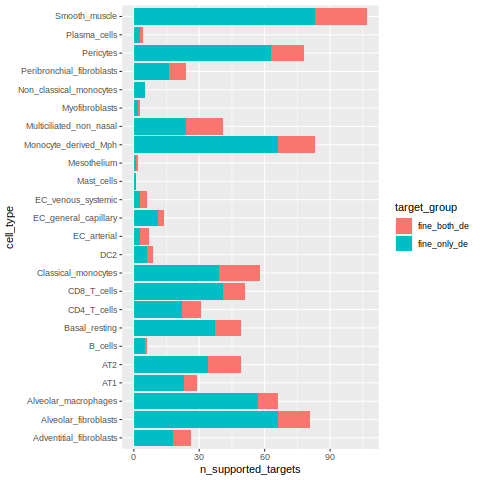

In [573]:
%%R -i df_all -i coarse_order -i fine_order
df_all %>%
filter(annotation == 'fine') %>%
# mutate(cell_type = factor(cell_type, levels=coarse_order)) %>%
# filter(annotation == 'fine') %>%
# mutate(cell_type = factor(cell_type, levels=unlist(fine_order))) %>%
ggplot(aes(cell_type, n_supported_targets, fill=target_group)) +
geom_col() +
coord_flip() 

In [610]:
import gseapy as gp
from gseapy.plot import barplot, dotplot

names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = gene_names_df.loc[coarse_only].gene_name.tolist()
background = DE_res_coarse.gene_name.unique()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/',
                 # no_plot=True,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

In [611]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

Gene_set  \
0         MSigDB_Hallmark_2020   
50  GO_Biological_Process_2017   
51  GO_Biological_Process_2017   
52  GO_Biological_Process_2017   
53  GO_Biological_Process_2017   
54  GO_Biological_Process_2017   

                                                 Term       P-value  \
0                                 Allograft Rejection  7.250244e-13   
50                   platelet activation (GO:0030168)  2.125385e-07   
51  positive regulation of interferon-gamma secret...  1.921446e-06   
52     T cell receptor signaling pathway (GO:0050852)  3.044560e-06   
53  peptidyl-tyrosine autophosphorylation (GO:0038...  4.572857e-06   
54  cellular response to prostaglandin E stimulus ...  1.292154e-05   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0       3.625122e-11            0                     0    6.854940   
50      2.161517e-04            0                     0    7.134255   
51      9.770554e-04            0                     0  156.948571   
52      1.032106e-03            0                     0    5.053577   
53      1.162649e-03            0                     0   10.220399   
54      2.628242e-03            0                     0   52.308571   

    Combined Score                                              Genes  
0       191.613203  ITK;GPR65;PRF1;EGFR;CCND3;IL18RAP;CCL7;STAT4;L...  
50      109.611705  LYN;PRKCH;PRKCB;ARRB1;PIK3R1;DGKZ;GNA14;GNG2;L...  
51     2065.824972                           CD2;PTPN22;RASGRP1;CD244  
52       64.191315  ITK;FYB1;RFTN1;PTPN22;PIK3R1;ZAP70;LCK;PRKCQ;L...  
53      125.663613              LYN;ITK;ZAP70;LCK;MATK;FYN;EGFR;IGF1R  
54      588.817434                           PTGER4;GNG2;PTGER2;PTGDR

In [612]:
enr.results[enr.results['Adjusted P-value'] < 0.01][['Gene_set', 'Term', 'Adjusted P-value', 'Genes']].iloc[0].Genes

'ITK;GPR65;PRF1;EGFR;CCND3;IL18RAP;CCL7;STAT4;LYN;CD96;NPM1;TGFB2;FYB1;PRKCB;GZMA;GLMN;MMP9;NME1;NCR1;CD2;ZAP70;LCK;IL2RB;KLRD1;LCP2;CD247'

In [614]:
gene_list = gene_names_df.loc[fine_only].gene_name.tolist()
background = DE_res_fine.gene_name.unique()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/',
                 # no_plot=True,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

In [615]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

Gene_set  \
0         MSigDB_Hallmark_2020   
1         MSigDB_Hallmark_2020   
2         MSigDB_Hallmark_2020   
3         MSigDB_Hallmark_2020   
43  GO_Biological_Process_2017   
44  GO_Biological_Process_2017   
45  GO_Biological_Process_2017   
46  GO_Biological_Process_2017   
47  GO_Biological_Process_2017   
48  GO_Biological_Process_2017   
49  GO_Biological_Process_2017   
50  GO_Biological_Process_2017   
51  GO_Biological_Process_2017   
52  GO_Biological_Process_2017   
53  GO_Biological_Process_2017   
54  GO_Biological_Process_2017   

                                                 Term       P-value  \
0                   Epithelial Mesenchymal Transition  1.301802e-12   
1                                         Coagulation  1.032068e-05   
2                       TNF-alpha Signaling via NF-kB  2.155578e-05   
3                                          Myogenesis  5.312214e-04   
43  complement activation, classical pathway (GO:0...  3.393551e-09   
44                   leukocyte migration (GO:0050900)  1.305477e-07   
45   regulation of complement activation (GO:0030449)  1.604228e-07   
46     extracellular matrix organization (GO:0030198)  2.299927e-07   
47                  cell-matrix adhesion (GO:0007160)  1.415334e-06   
48                 complement activation (GO:0006956)  1.632075e-06   
49         regulation of immune response (GO:0050776)  1.858053e-05   
50             phagocytosis, recognition (GO:0006910)  2.469482e-05   
51  positive regulation of B cell activation (GO:0...  3.752669e-05   
52     B cell receptor signaling pathway (GO:0050853)  8.194423e-05   
53              phagocytosis, engulfment (GO:0006911)  9.365184e-05   
54            collagen catabolic process (GO:0030574)  1.064298e-04   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0       5.597750e-11            0                     0    6.932358   
1       2.218947e-04            0                     0    5.220731   
2       3.089662e-04            0                     0    3.918302   
3       5.710630e-03            0                     0    3.331954   
43      2.979538e-06            0                     0   10.499057   
44      4.695042e-05            0                     0    5.342010   
45      4.695042e-05            0                     0    8.115942   
46      5.048339e-05            0                     0    5.867355   
47      2.388269e-04            0                     0    8.290125   
48      2.388269e-04            0                     0    8.144156   
49      2.330529e-03            0                     0    4.521957   
50      2.710257e-03            0                     0   12.538149   
51      3.660937e-03            0                     0   11.491815   
52      7.194703e-03            0                     0    7.675124   
53      7.475120e-03            0                     0    9.507389   
54      7.787111e-03            0                     0    7.325305   

    Combined Score                                              Genes  
0       189.719722  NNMT;WIPF1;ELN;TNFAIP3;FBLN1;FBLN5;MYLK;SERPIN...  
1        59.941092  THBD;MMP14;PLAU;PROS1;MMP2;CFI;P2RY1;A2M;PRSS2...  
2        42.101637  PPP1R15A;DUSP5;SPHK1;TNFAIP3;IRS2;CXCL2;ICAM1;...  
3        25.124041  COL3A1;DES;COL4A2;ITGB4;SPHK1;IGFBP3;BDKRB2;CD...  
43      204.746189  IGHM;IGHV3-30;IGHV3-33;IGHG4;IGLL5;IGHG1;IGLV1...  
44       84.679022  IGHM;IGHV3-30;ANGPT2;IGHV3-33;PROS1;ATP1B1;SEL...  
45      126.977588  IGHG4;IGHG1;IGHV3-30;IGLV1-51;IGLV3-21;PROS1;I...  
46       89.683799  VCAM1;COL14A1;ITGB4;ELN;NDNF;FBLN5;ICAM1;COL3A...  
47      111.652602  COL17A1;TIMM10B;COL3A1;VCAM1;ITGB4;ITGA10;ITGA...  
48      108.526236  IGHG4;IGHG1;IGHV3-30;IGLV1-51;IGLV3-21;IGHV3-3...  
49       49.259471  COL17A1;IFITM1;IGHV3-30;VCAM1;IGHV3-33;ICAM1;C...  
50      133.016186                  IGHM;IGHG4;IGLL5;IGHG1;IGHD;IGHA2  
51      117.106864                  IGHM;IGHG4;IGLL5;IGHG1;IGHD;IGHA2  
52       72.218865 

In [616]:
enr.results[enr.results['Adjusted P-value'] < 0.01][['Gene_set', 'Term', 'Adjusted P-value', 'Genes']].iloc[0].Genes

'NNMT;WIPF1;ELN;TNFAIP3;FBLN1;FBLN5;MYLK;SERPINH1;IL32;PDGFRB;VCAM1;IGFBP4;IGFBP3;MMP2;PCOLCE;MMP14;COL3A1;DAB2;COL4A2;COL7A1;MYL9;MXRA5;SCG2;CD44;CRLF1'

We see most DE genes only in the coarse settings in annotations that are all encompassing: it's possible that  

In [511]:
# Get DE cell types per target

In [512]:
def get_evidence_celltypes(de_res, targets_res, signif_alpha = 0.01, clinical_status_cols = ['is_effective'], evidence='disease'):
    if evidence== 'disease':
        signif_DE = de_res[(de_res.adj_pval < signif_alpha) & (np.abs(de_res.lfc) > 0.5) ].copy()
    elif evidence == 'celltype':
        signif_DE = de_res[(de_res.adj_pval < signif_alpha) & (de_res.lfc > 5) ].copy()
    ct2gene_evidence = sc.metrics.confusion_matrix('gene_id', 'high_level_cell_type_ontology_term_id',data=signif_DE[['gene_id', 'high_level_cell_type_ontology_term_id']], normalize=False)
    if ct2gene_evidence.columns[0].startswith("CL"):
        ct2gene_evidence.columns = [cellontology_utils.ontology2name(x.replace("_", ":"), graph) for x in ct2gene_evidence.columns]
    ct2gene_evidence = pd.merge(ct2gene_evidence.reset_index(), targets_res[clinical_status_cols + ['gene_id']], how='left')
    ct2gene_evidence = pd.merge(ct2gene_evidence, de_res[['gene_id', 'gene_name']].drop_duplicates(), how='left').drop('gene_id', axis=1).set_index('gene_name')
    return(ct2gene_evidence)

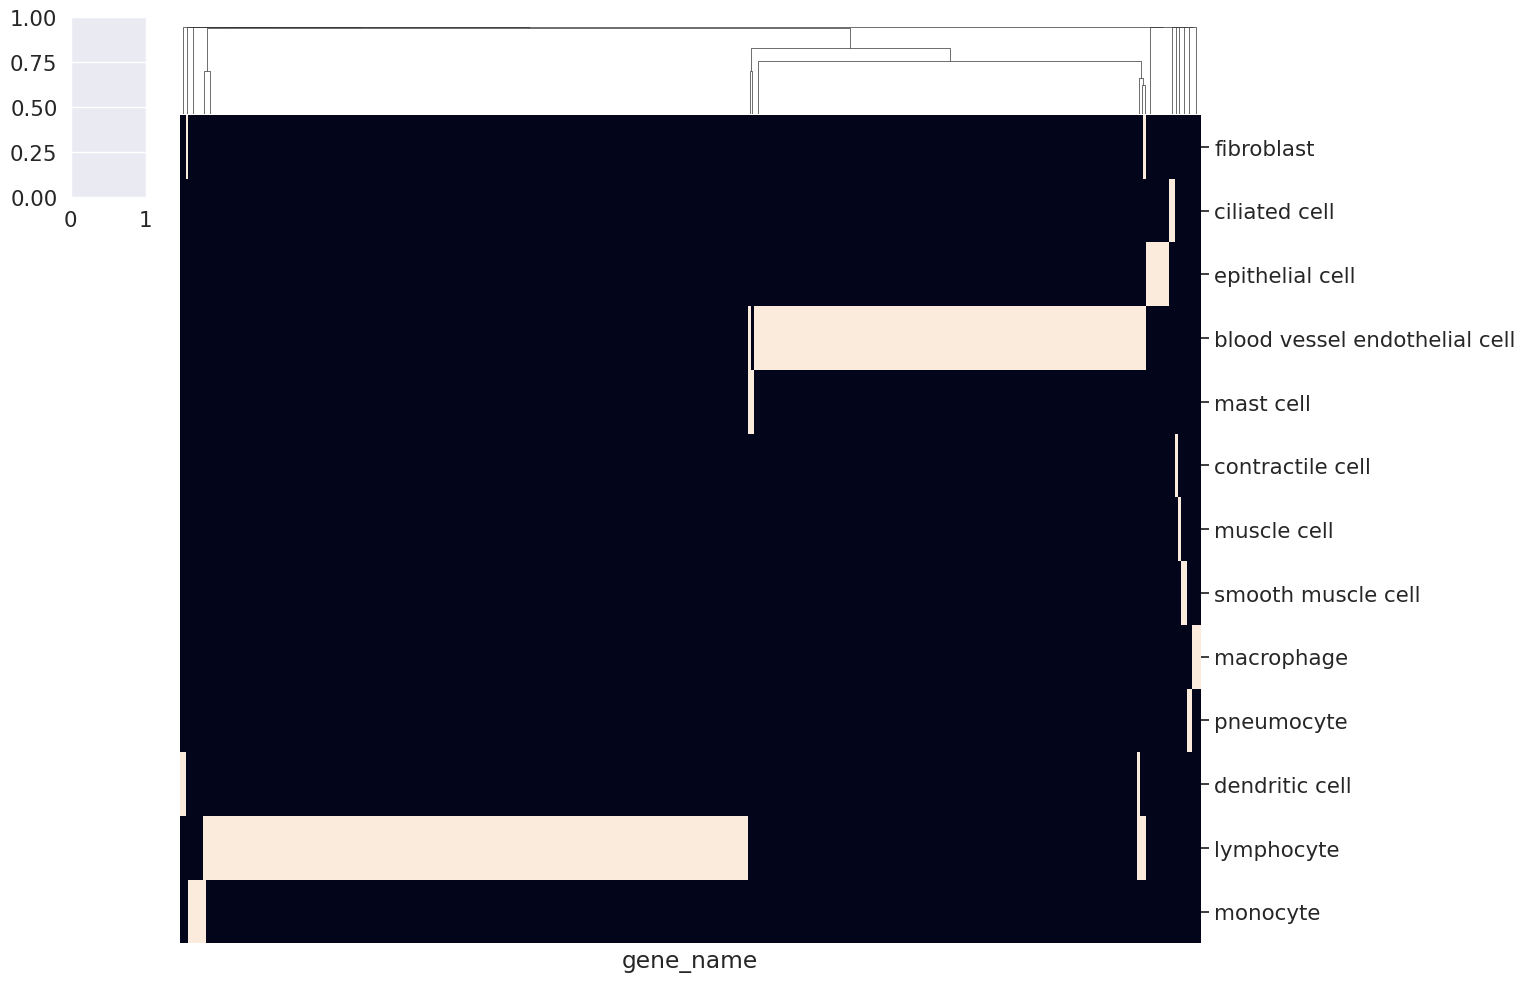

In [513]:
df = DE_res_coarse[DE_res_coarse.gene_id.isin(coarse_only)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, evidence='disease')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, 
               yticklabels=True, figsize=(15,10), 
               metric='jaccard',xticklabels=False,
               dendrogram_ratio=0.1, cbar=False, 
               row_cluster=False, col_cluster=True
              )

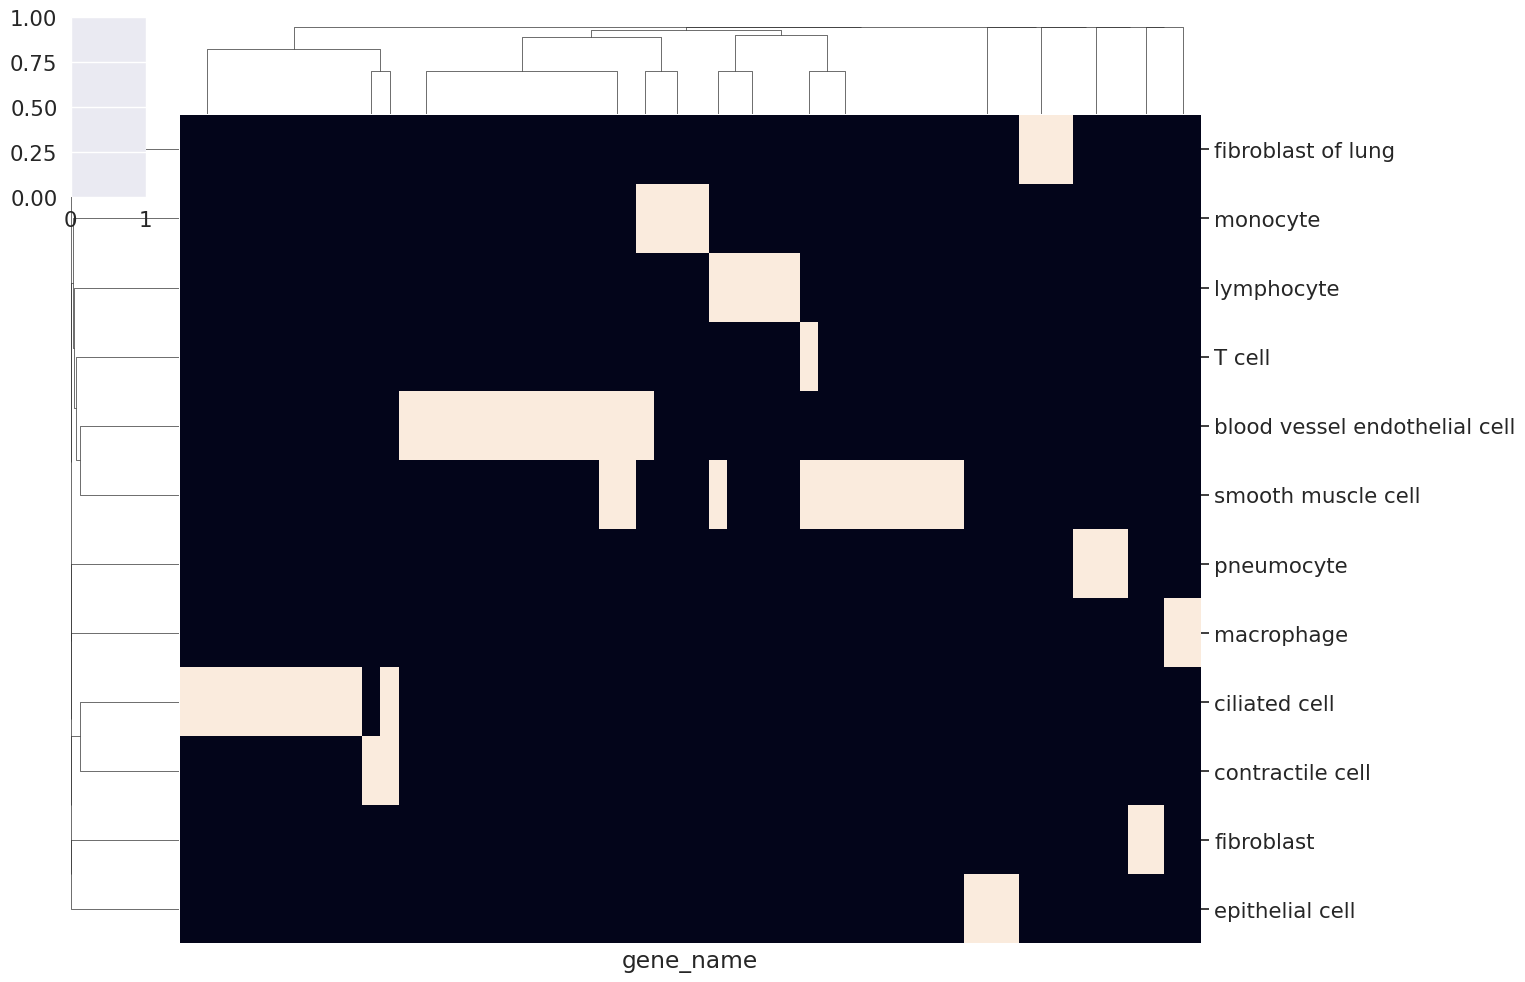

In [514]:
df = DE_res_coarse[DE_res_coarse.gene_id.isin(both)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, evidence='disease')
sns.set(font_scale=1.4)
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, 
               yticklabels=True, figsize=(15,10), 
               metric='jaccard',xticklabels=False,
               dendrogram_ratio=0.1, cbar=False
              )

In [515]:
order_cts_fine = ['AT1', 'AT2', 'Mesothelium', 'Multiciliated_non_nasal','Basal_resting',
 'Adventitial_fibroblasts', 'Alveolar_fibroblasts',       'Myofibroblasts', 'Peribronchial_fibroblasts', 
 'Alveolar_macrophages', 'Monocyte_derived_Mph',        'Classical_monocytes', 'Non_classical_monocytes', 'DC2', 
 'CD8_T_cells', 'CD4_T_cells', 'NK_cells', 'B_cells','Plasma_cells', 
 'EC_aerocyte_capillary', 'EC_arterial', 'EC_general_capillary', 'EC_venous_systemic',
'Pericytes', 'Smooth_muscle']

In [617]:
def _plot_heatmap(df):
    ct2gene_evidence = get_evidence_celltypes(df, targets_res_fine,  evidence='disease')
    ct2gene_evidence = ct2gene_evidence.drop('is_effective', axis=1).T.loc[[x for x in order_cts_fine if x in ct2gene_evidence.columns]]
#     ct2gene_evidence.index = ct2gene_evidence.index.astype('category').reorder_categories([x for x in order_cts if x in ct2gene_evidence.index])
#     col_order = ct2gene_evidence.idxmax(0).sort_values().index
    sns.clustermap(ct2gene_evidence,
                   yticklabels=True, figsize=(15,10), 
                   row_cluster=False, col_cluster=True,
                   metric='jaccard', xticklabels=False,
                   dendrogram_ratio=0.1, cbar=False
                  )

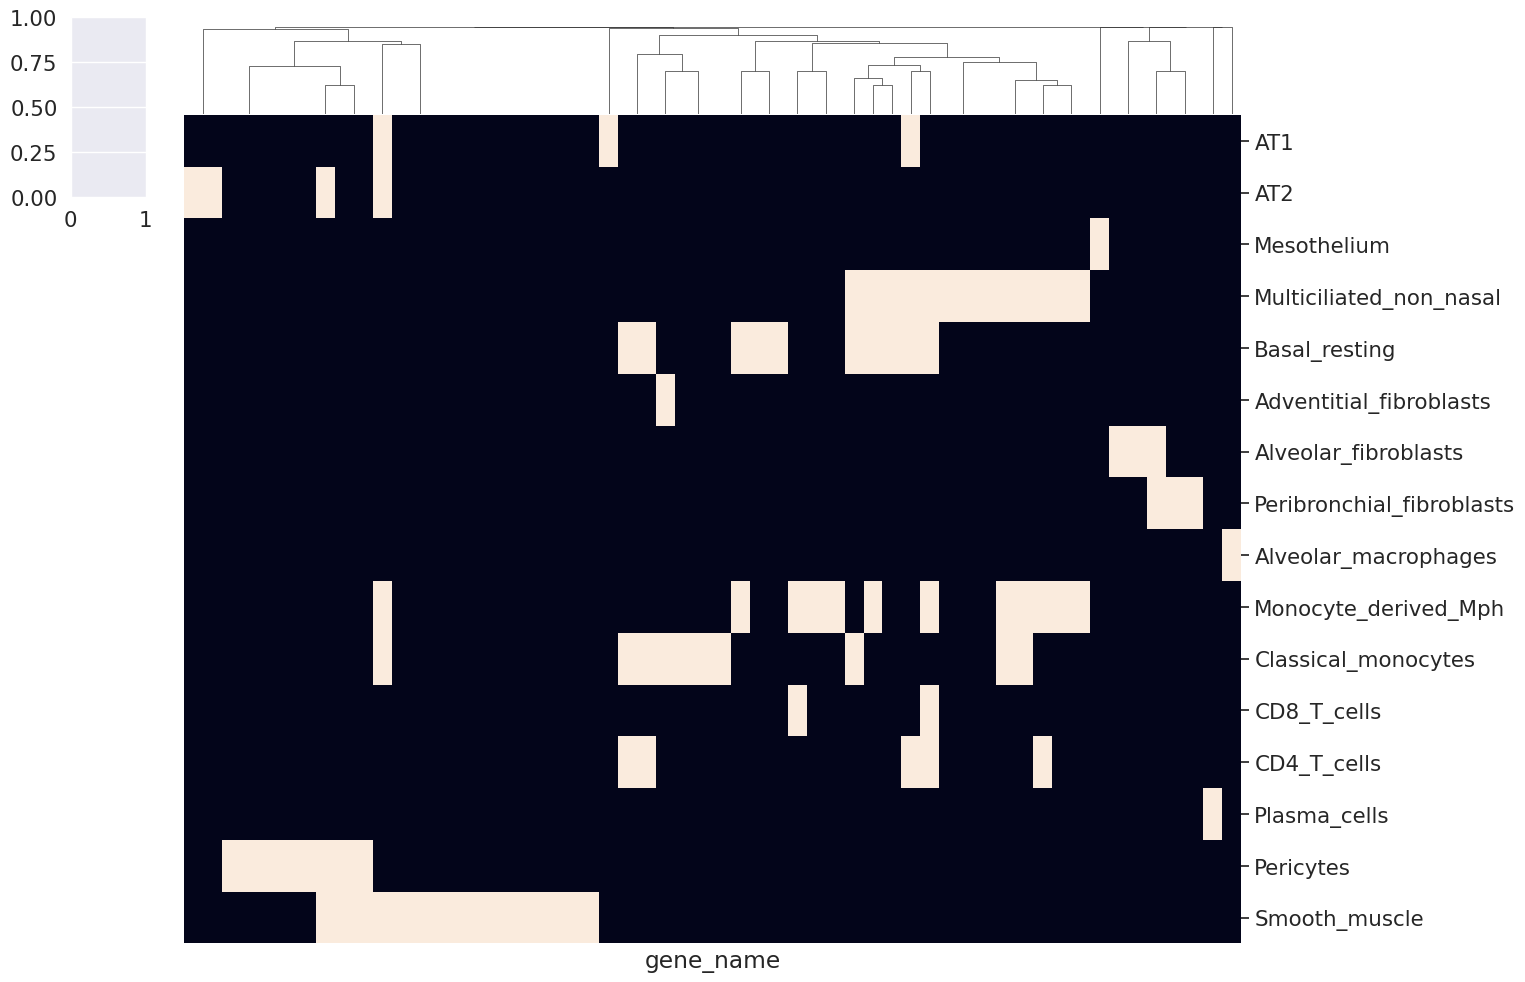

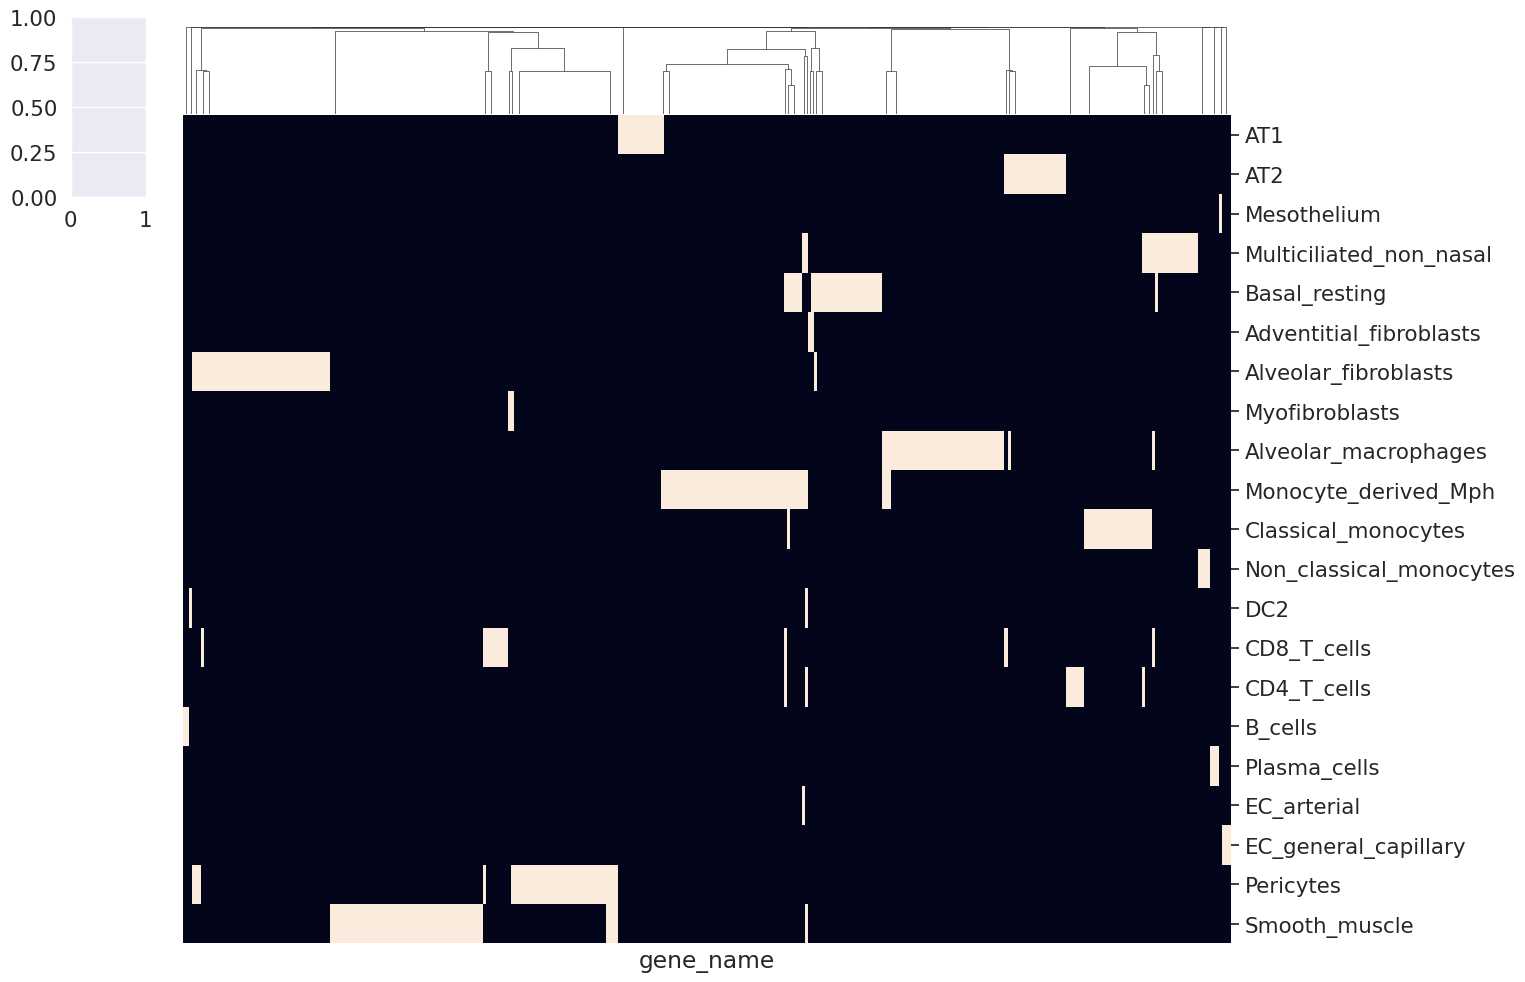

In [618]:
df = DE_res_fine[DE_res_fine.gene_id.isin(both)].copy()
_plot_heatmap(df)

df = DE_res_fine[DE_res_fine.gene_id.isin(fine_only)].copy()
_plot_heatmap(df)

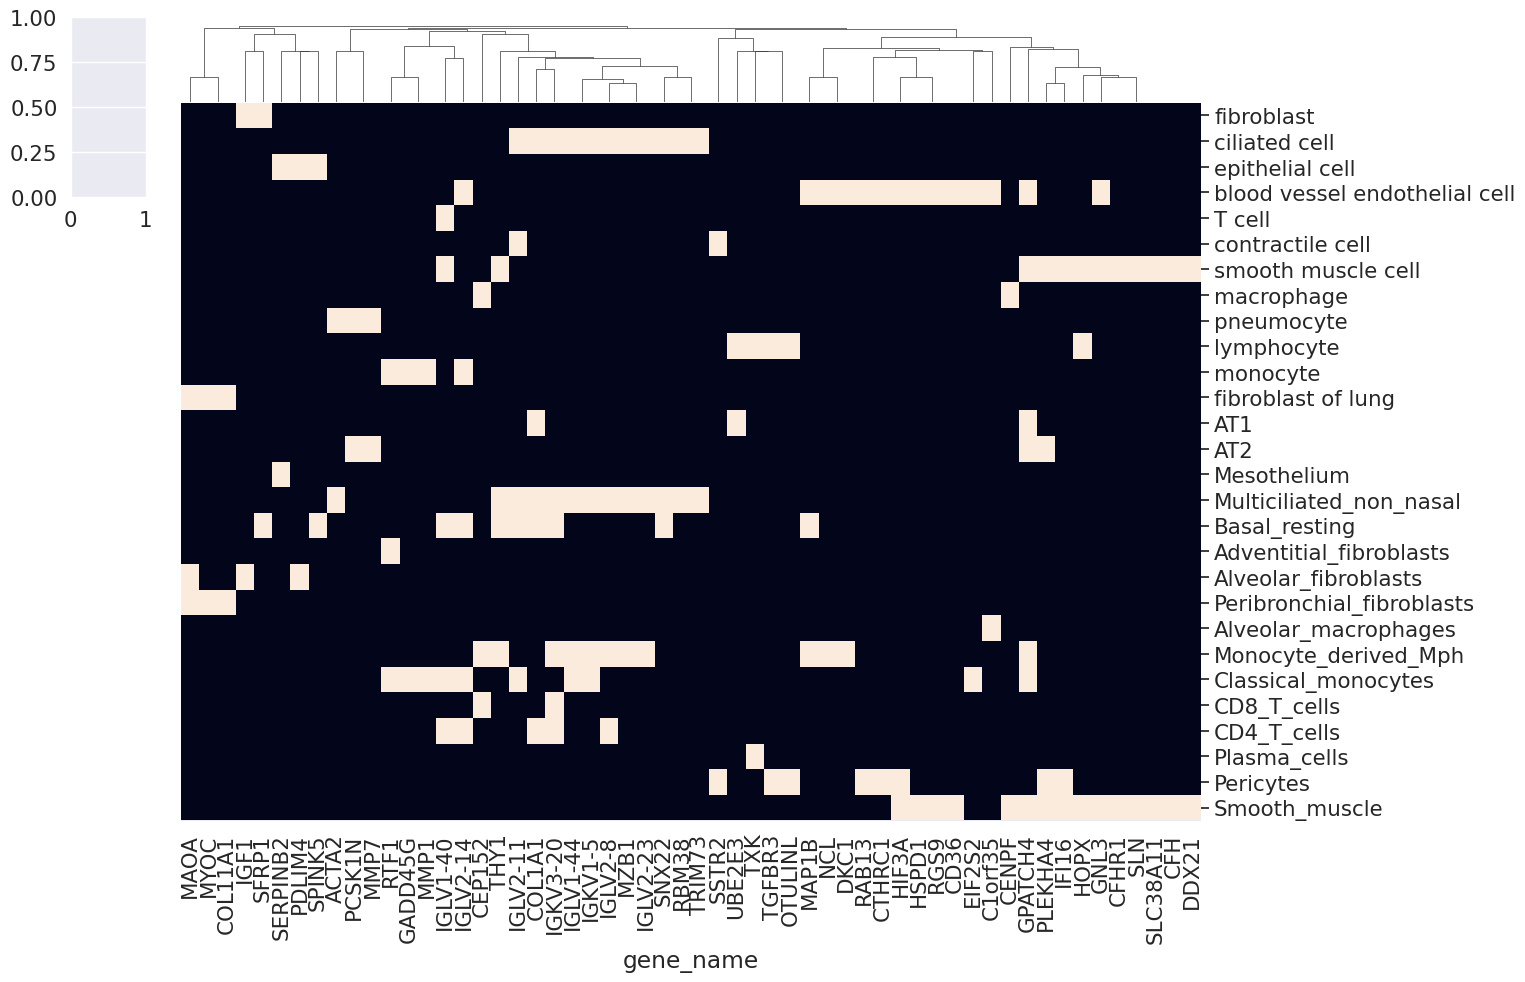

In [627]:
df = DE_res_fine[DE_res_fine.gene_id.isin(both)].copy()
ct2gene_evidence_fine = get_evidence_celltypes(df, targets_res_fine,  evidence='disease')
ct2gene_evidence_fine = ct2gene_evidence_fine.drop('is_effective', axis=1).T.loc[[x for x in order_cts_fine if x in ct2gene_evidence_fine.columns]]

df = DE_res_coarse[DE_res_coarse.gene_id.isin(both)].copy()
ct2gene_evidence_coarse = get_evidence_celltypes(df, targets_res_fine,  evidence='disease')
ct2gene_evidence_coarse = ct2gene_evidence_coarse.drop('is_effective', axis=1).T

sns.clustermap(pd.concat([ct2gene_evidence_coarse, ct2gene_evidence_fine]),
                   yticklabels=True, figsize=(15,10), 
                   row_cluster=False, col_cluster=True,
                   metric='jaccard', xticklabels=True,
                   dendrogram_ratio=0.1, cbar=False
                  )

Targets DE in disease only with fine annotation are DE in significantly less cell types on average

In [628]:
import scipy.stats
df = DE_res_fine[DE_res_fine.gene_id.isin(both)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_fine, evidence='disease')
n_cts_both = ct2gene_evidence.sum(1)
print(f"Mean both:{n_cts_both.mean()}")

df = DE_res_fine[DE_res_fine.gene_id.isin(fine_only)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_fine, evidence='disease')
n_cts_fine = ct2gene_evidence.sum(1)
print(f"Mean fine:{n_cts_fine.mean()}")

scipy.stats.ttest_ind(
    n_cts_fine, 
    n_cts_both)

Mean both:1.6428571428571428
Mean fine:1.1198830409356726


Ttest_indResult(statistic=-6.564548240712288, pvalue=1.6397716844114367e-10)

In [629]:
ct_ev_genes_fine = targets_res_fine[targets_res_fine['ct_marker_evidence'] == 1].gene_id
ct_ev_genes_coarse = targets_res_coarse[targets_res_coarse['ct_marker_evidence'] == 1].gene_id

In [630]:
coarse_only = np.setdiff1d(ct_ev_genes_coarse, ct_ev_genes_fine)
fine_only = np.setdiff1d(ct_ev_genes_fine, ct_ev_genes_coarse)
both = np.intersect1d(ct_ev_genes_fine, ct_ev_genes_coarse)

In [631]:
coarse_only_de = DE_ct_res_coarse[(DE_ct_res_coarse.gene_id.isin(coarse_only)) & 
              (DE_ct_res_coarse.adj_pval < 0.1) &
              (np.abs(DE_ct_res_coarse['lfc']) > 0.5) 
             ]
fine_only_de = DE_ct_res_fine[(DE_ct_res_fine.gene_id.isin(fine_only)) & 
              (DE_ct_res_fine.adj_pval < 0.1) &
              (np.abs(DE_ct_res_fine['lfc']) > 0.5) 
             ]
both_fine_de = DE_ct_res_fine[(DE_ct_res_fine.gene_id.isin(both)) & 
              (DE_ct_res_fine.adj_pval < 0.1) &
              (np.abs(DE_ct_res_fine['lfc']) > 0.5) 
             ]

both_coarse_de = DE_ct_res_coarse[(DE_ct_res_coarse.gene_id.isin(both)) & 
              (DE_ct_res_coarse.adj_pval < 0.1) &
              (np.abs(DE_ct_res_coarse['lfc']) > 0.5) 
             ]

fine_only_de.high_level_cell_type_ontology_term_id.value_counts()

Alveolar_Mph_proliferating       551
Monocyte_derived_Mph             500
DC2                              496
Alveolar_macrophages             493
Alveolar_Mph_CCL3pos             479
Non_classical_monocytes          464
Interstitial_Mph_perivascular    462
Classical_monocytes              445
Suprabasal                       435
Hillock_like                     366
NK_cells                         358
CD4_T_cells                      355
Club_non_nasal                   350
B_cells                          348
DC1                              344
CD8_T_cells                      342
Mast_cells                       333
Goblet_nasal                     332
Multiciliated_non_nasal          331
Plasma_cells                     329
Migratory_DCs                    320
EC_general_capillary             316
Plasmacytoid_DCs                 306
Basal_resting                    305
Deuterosomal                     301
Alveolar_Mph_MT_positive         278
AT2                              278
E

In [632]:
target_group_dict = {
    'coarse_only_de':coarse_only_de,
    'fine_only_de':fine_only_de,
    'coarse_both_de':both_coarse_de,
    'fine_both_de':both_fine_de,
}

In [633]:
df_all = pd.DataFrame()
for target_group,target_group_de in target_group_dict.items(): 
    top_cts = target_group_de.high_level_cell_type_ontology_term_id.value_counts()
    if top_cts.index[0].startswith("CL"):
        top_cts.index = [cellontology_utils.ontology2name(x.replace("_", ":"), graph) for x in top_cts.index]
    df = top_cts.reset_index()
    df.columns = ['cell_type', 'n_supported_targets']
    df['target_group'] = target_group
    df_all = pd.concat([df_all, df])

In [634]:
df_all['annotation'] = df_all['target_group'].str.split('_', expand=True)[0]

In [635]:
# fine_order = pbulk_adata_fine.obs.groupby('high_level_cell_type_ontology_term_id')['n_cells'].sum().sort_values()
fine_order = pbulk_adata_fine.obs.groupby('high_level_cell_type_ontology_term_id').size().sort_values().index.tolist()
fine_order =  [x.replace(' ', '_') for x in fine_order]
# coarse_order = pbulk_adata_coarse.obs.groupby('high_level_cell_type_ontology_term_id')['n_cells'].sum().sort_values()
coarse_order = pbulk_adata_coarse.obs.groupby('high_level_cell_type_ontology_term_id').size().sort_values()
coarse_order = [ontology2name(x, graph) for x in coarse_order.index]

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


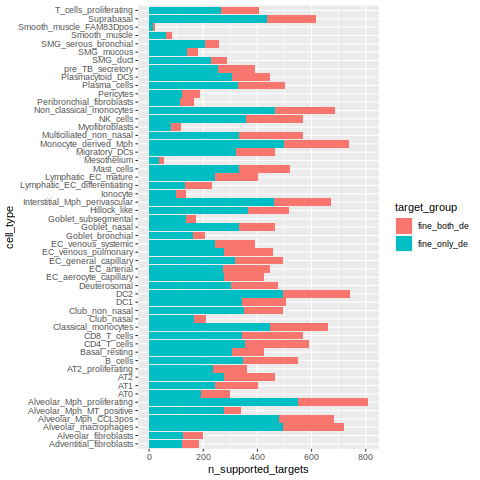

In [636]:
%%R -i df_all -i coarse_order -i fine_order
df_all %>%
# filter(annotation == 'coarse') %>%
# mutate(cell_type = factor(cell_type, levels=coarse_order)) %>%
filter(annotation == 'fine') %>%
# mutate(cell_type = factor(cell_type, levels=unlist(fine_order))) %>%
ggplot(aes(cell_type, n_supported_targets, fill=target_group)) +
geom_col() +
coord_flip() 

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


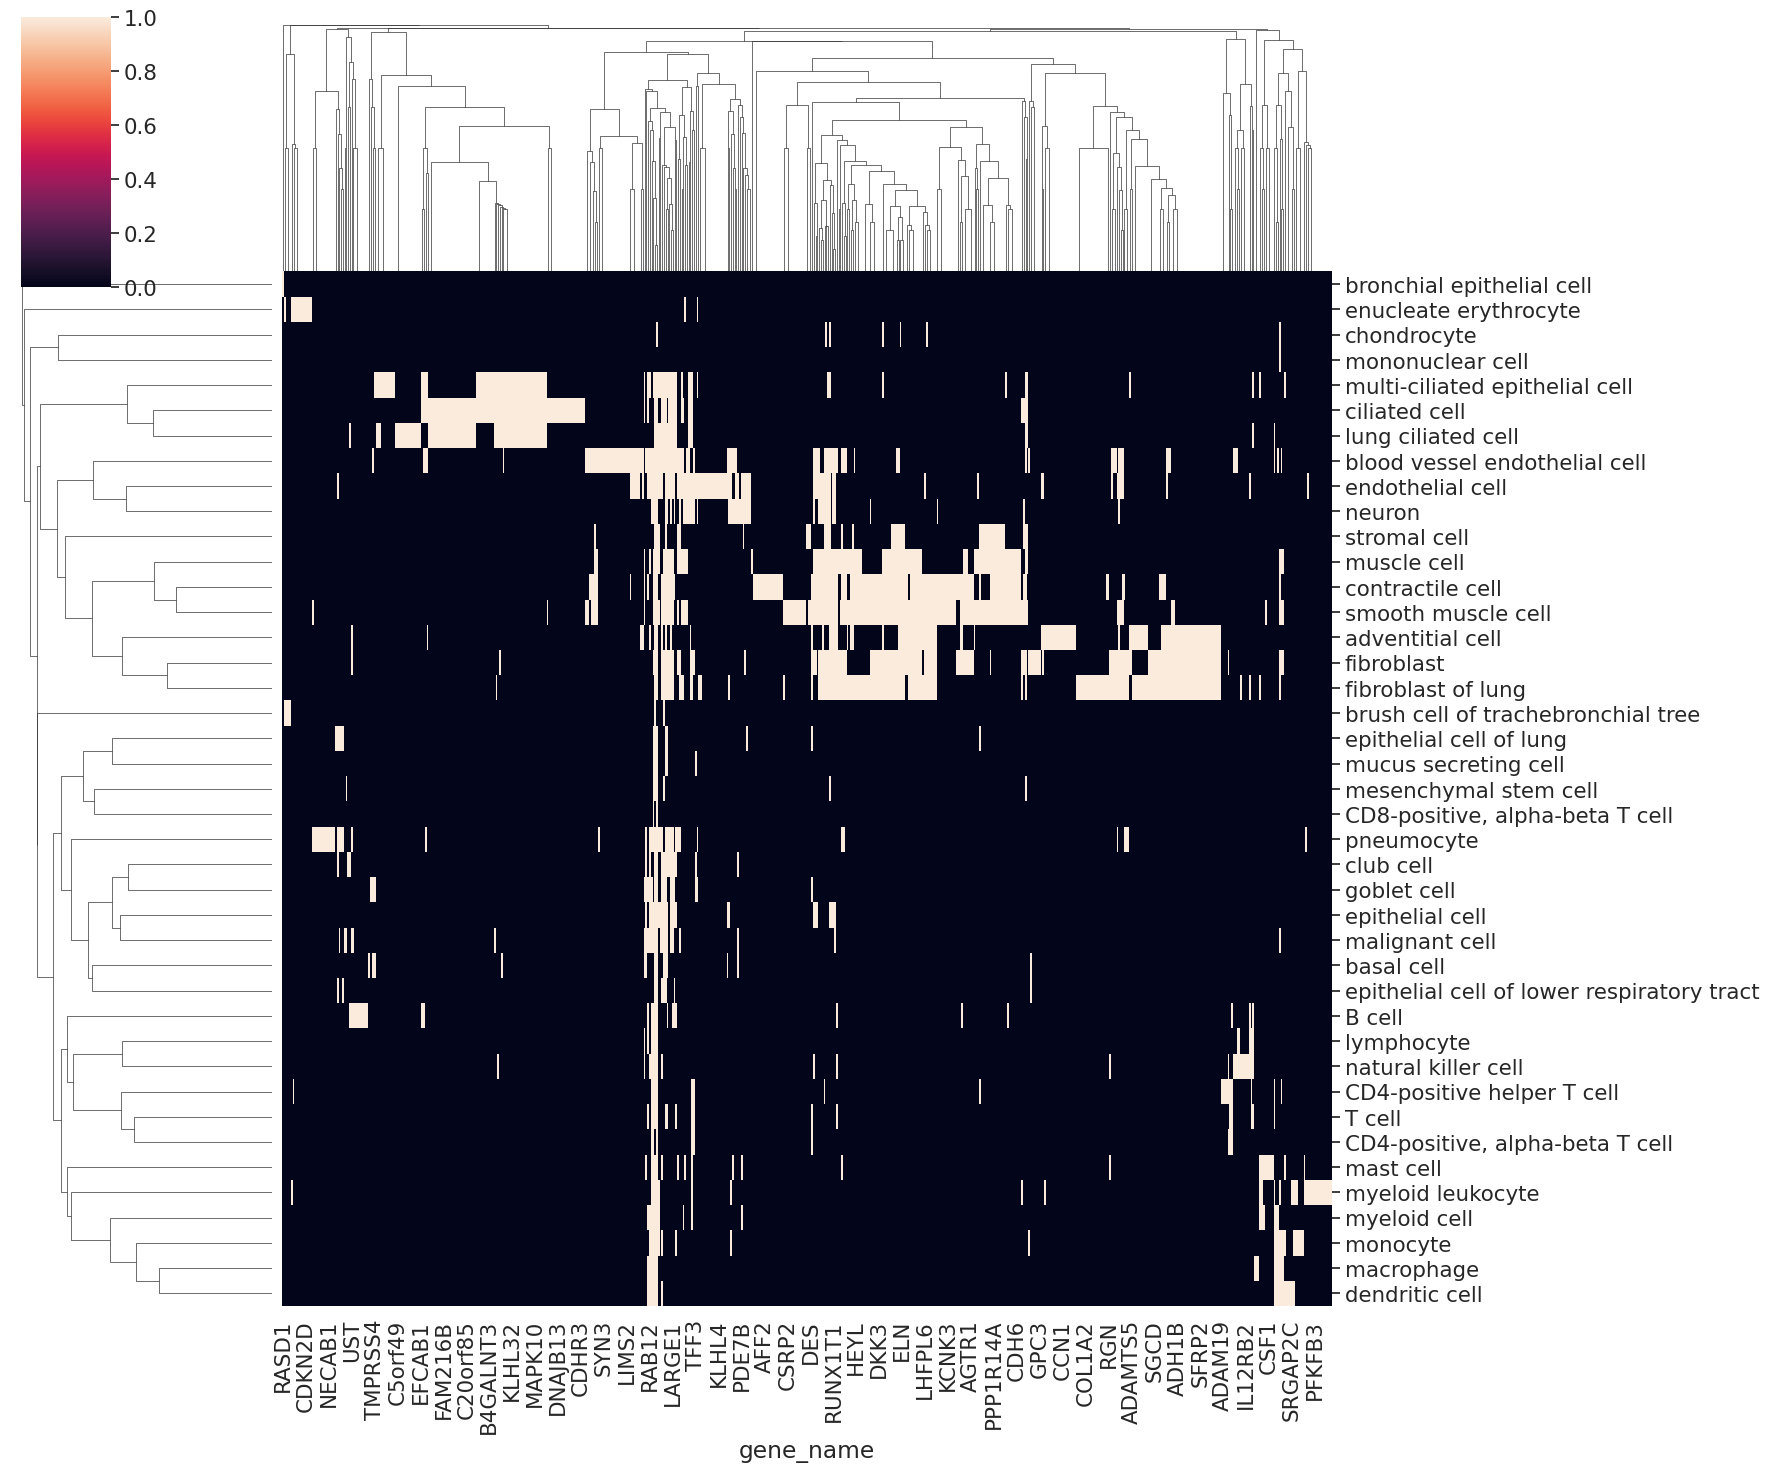

In [637]:
df = DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(coarse_only)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


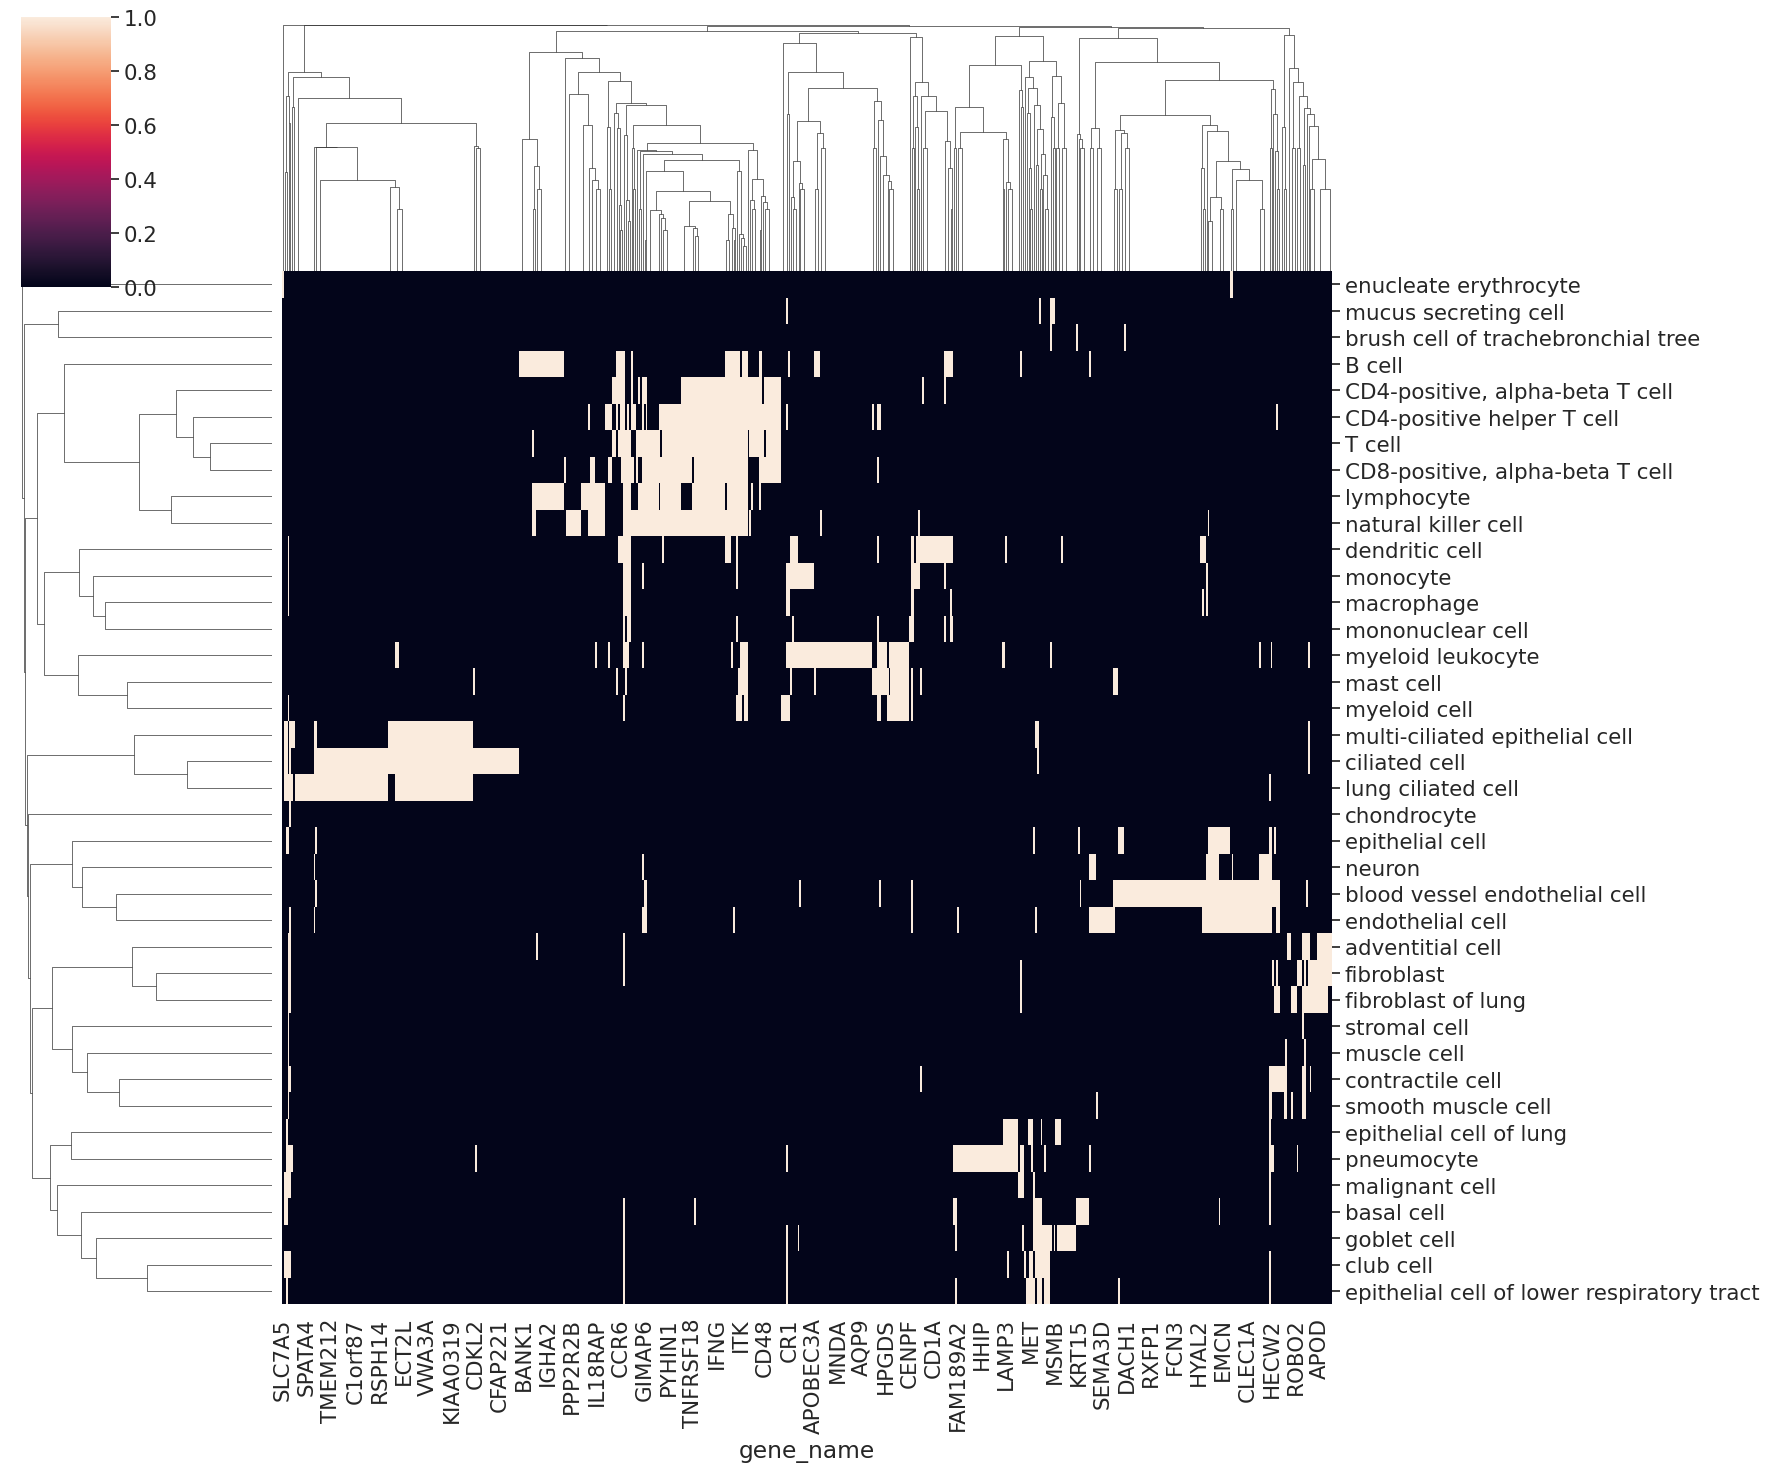

In [638]:
df = DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(both)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse,evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

In [645]:
len(fine_only)

822

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


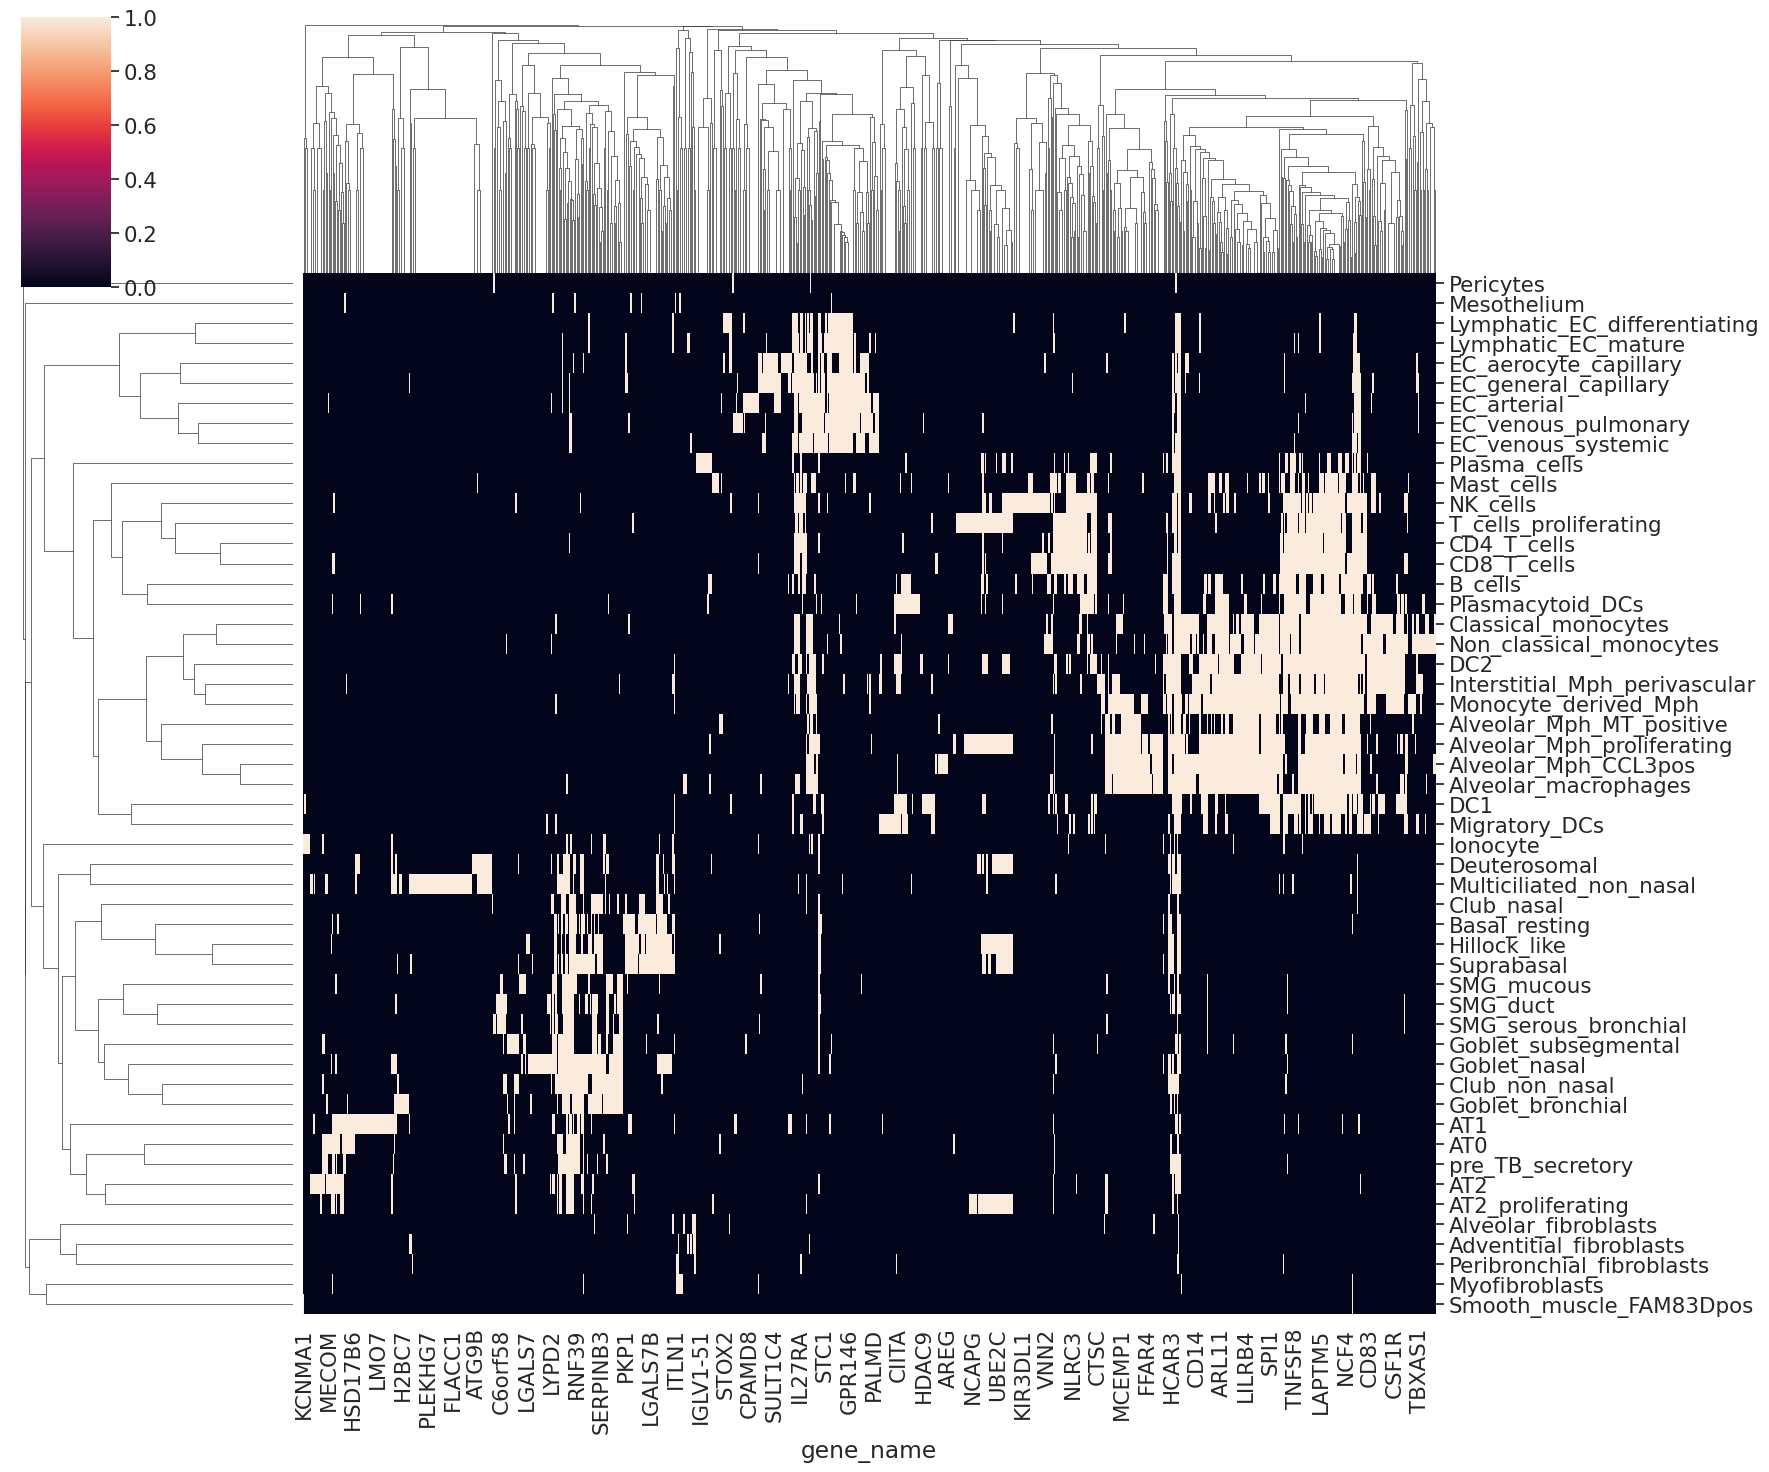

In [641]:
df = DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(fine_only)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_fine, evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


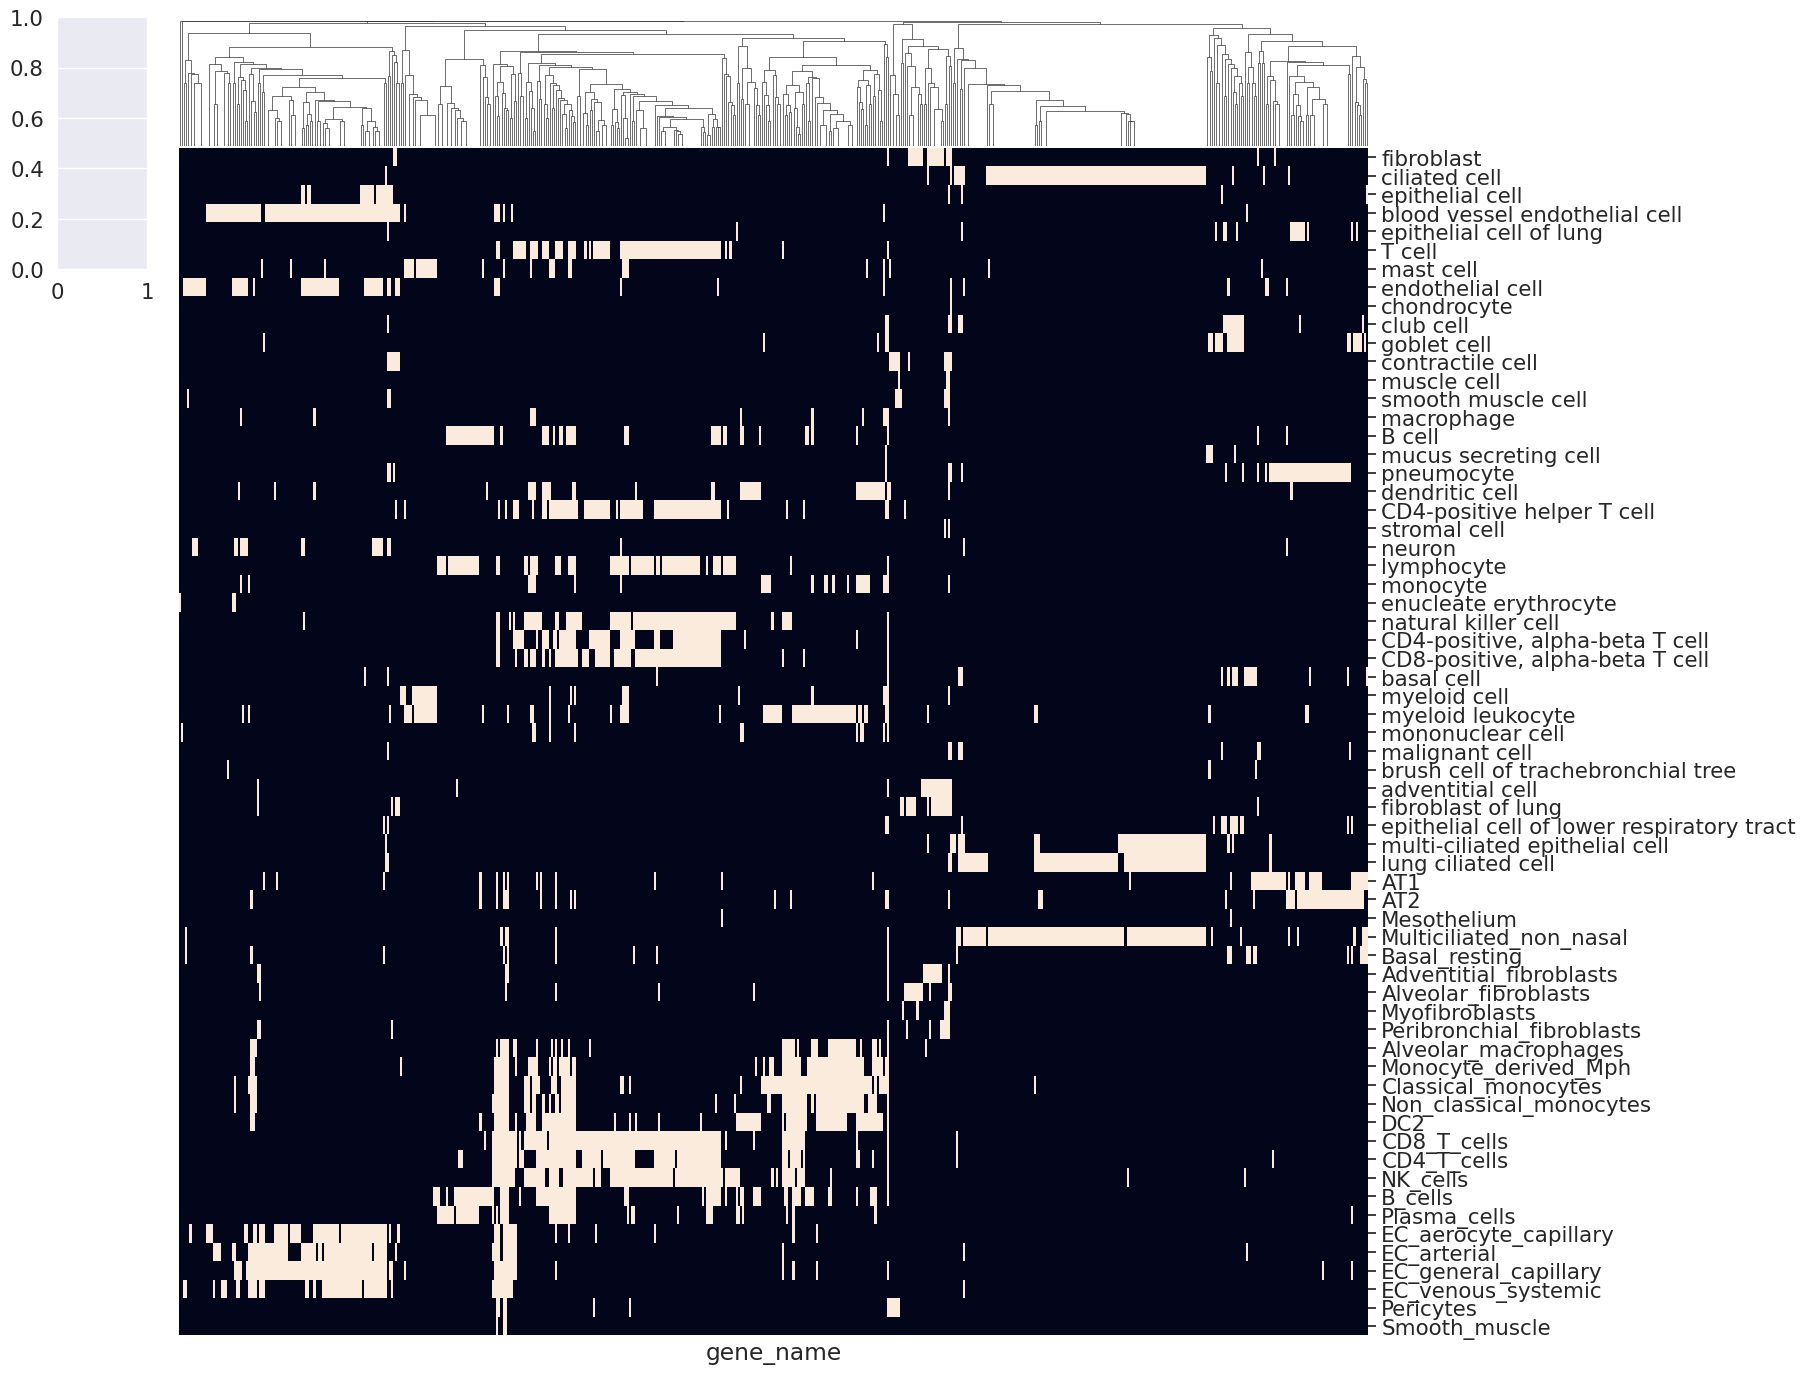

In [648]:
df = DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(both)].copy()
ct2gene_evidence_fine = get_evidence_celltypes(df, targets_res_fine,  evidence='celltype')
ct2gene_evidence_fine = ct2gene_evidence_fine.drop('is_effective', axis=1).T.loc[[x for x in order_cts_fine if x in ct2gene_evidence_fine.columns]]

df = DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(both)].copy()
ct2gene_evidence_coarse = get_evidence_celltypes(df, targets_res_fine,  evidence='celltype')
ct2gene_evidence_coarse = ct2gene_evidence_coarse.drop('is_effective', axis=1).T

sns.clustermap(pd.concat([ct2gene_evidence_coarse, ct2gene_evidence_fine]),
                   yticklabels=True, figsize=(18,14), 
                   row_cluster=False, col_cluster=True,
                   metric='jaccard', xticklabels=False,
                   dendrogram_ratio=0.1, cbar=False
                  )

#### Compare drug targets with evidence

In [533]:
evidence_cols = ['has_genetic_support', 'ct_marker_evidence', 'disease_evidence']
success_cols = ['is_effective', 'is_approved']

In [534]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

In [535]:
ct_order_coarse = ['fibroblast', 'adventitial cell', 'fibroblast of lung',
 'epithelial cell','epithelial cell of lung','pneumocyte',  'club cell', 'goblet cell', 'basal cell', 'epithelial cell of lower respiratory tract',
 'blood vessel endothelial cell',       'endothelial cell',
  'muscle cell', 'contractile cell', 'smooth muscle cell',
 'lymphocyte', 'T cell','CD4-positive helper T cell',        'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell','B cell','natural killer cell',
 'mast cell','monocyte',   'macrophage', 'dendritic cell', 'myeloid cell','myeloid leukocyte', 'mononuclear cell', 
 'chondrocyte', 
       'stromal cell', 'neuron', 
'malignant cell'
       ]

/tmp/ipykernel_2113/3216899765.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([ df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/3216899765.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


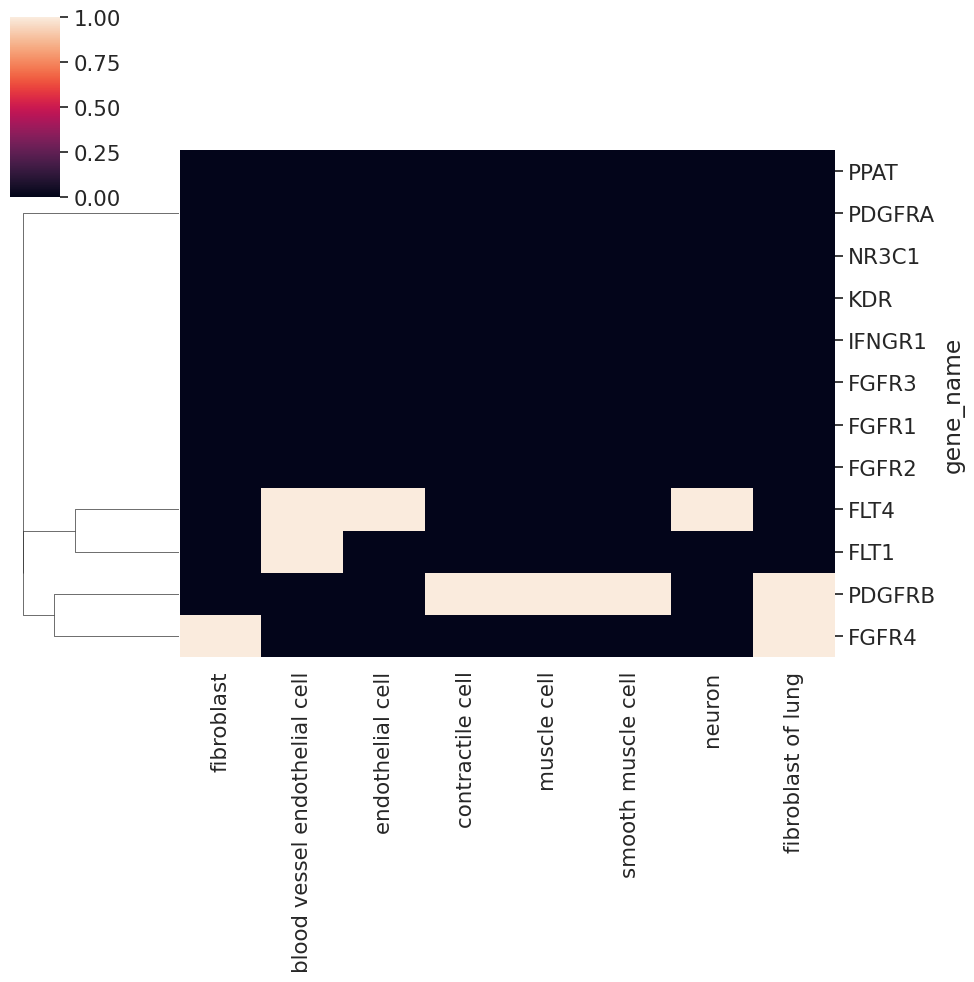

In [543]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_coarse[targets_res_coarse['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
#                        clinical_status_cols = success_cols, evidence='disease'
#                       )
# missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
# for t in missing_genes:
#     df_dis.loc[t] = 0
#     t_id = gene_names_df.set_index('gene_name').loc[t][0]
#     for col in success_cols:
#         df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([ df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
# df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
# df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [544]:
%%R -i pl_df -i ct_order_coarse -i row_order -i success_cols 
head(pl_df)

  gene_name                      celltype value        evidence target_success
1     FGFR4                    fibroblast   yes celltype_marker        targets
2      FLT4 blood vessel endothelial cell   yes celltype_marker        targets
3      FLT1 blood vessel endothelial cell   yes celltype_marker        targets
4      FLT4              endothelial cell   yes celltype_marker        targets
5    PDGFRB              contractile cell   yes celltype_marker        targets
6    PDGFRB                   muscle cell   yes celltype_marker        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


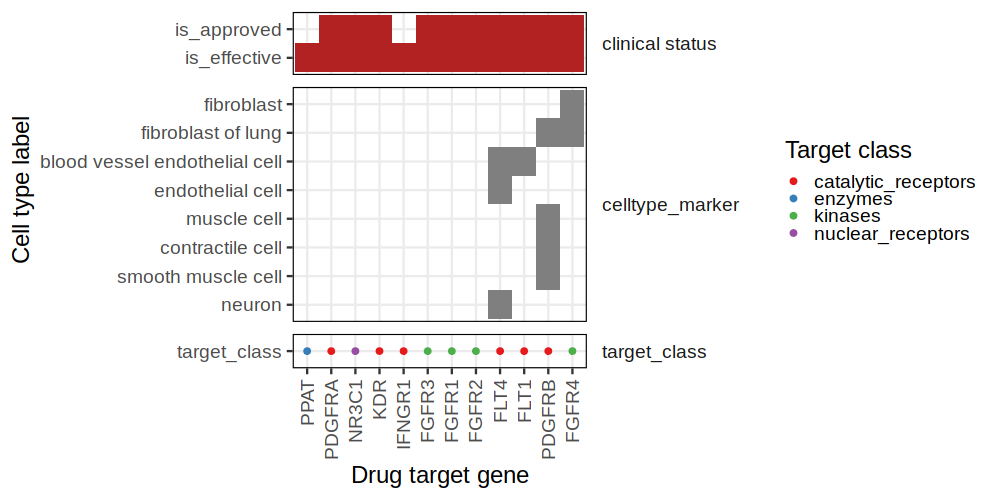

In [547]:
%%R -w 1000 -h 500
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_coarse), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=24) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

/tmp/ipykernel_2113/126945150.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/126945150.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/126945150.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


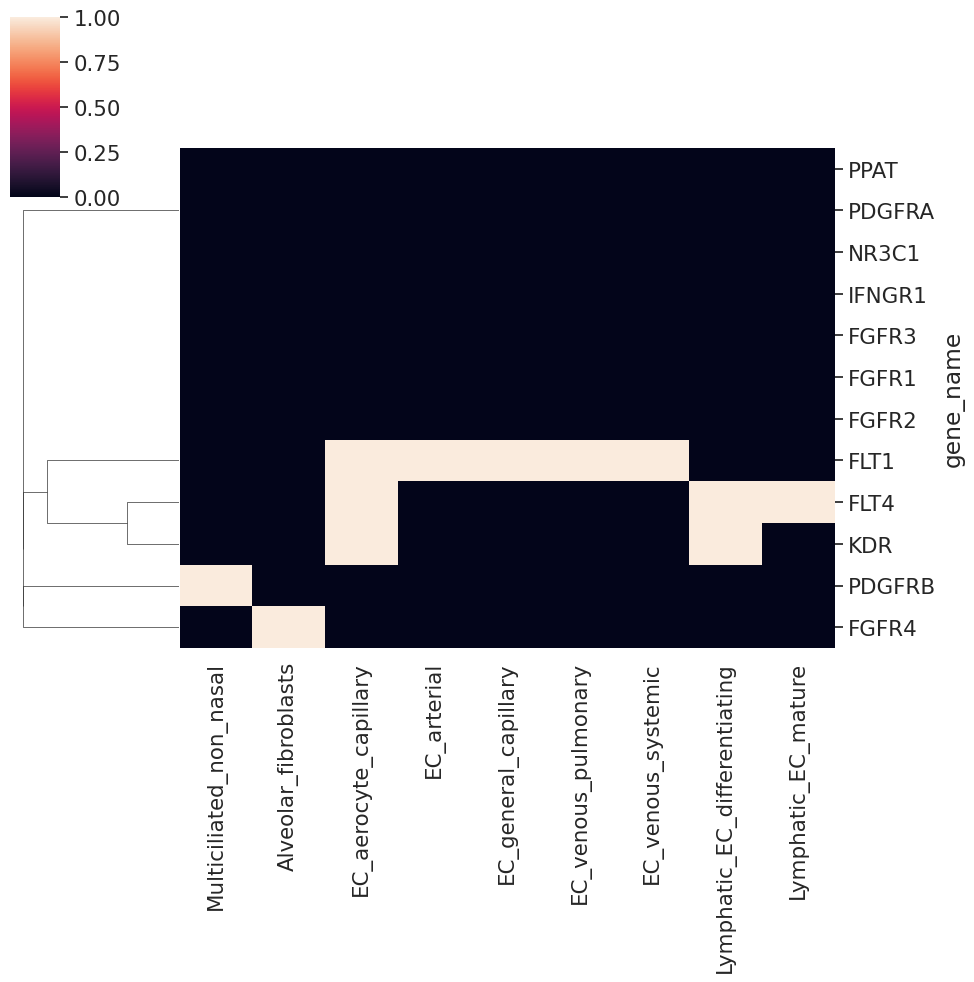

In [548]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_fine[targets_res_fine['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='celltype',
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_fine.loc[targets_res_fine.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_fine[DE_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_fine.loc[targets_res_fine.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [549]:
%%R -i pl_df -i ct_order_fine -i row_order -i success_cols 
head(pl_df)

  gene_name                celltype value        evidence target_success
1    PDGFRB Multiciliated_non_nasal   yes         disease        targets
2    PDGFRB            is_effective   yes clinical status        targets
3     FGFR1            is_effective   yes clinical status        targets
4     FGFR2            is_effective   yes clinical status        targets
5     FGFR3            is_effective   yes clinical status        targets
6     FGFR4            is_effective   yes clinical status        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


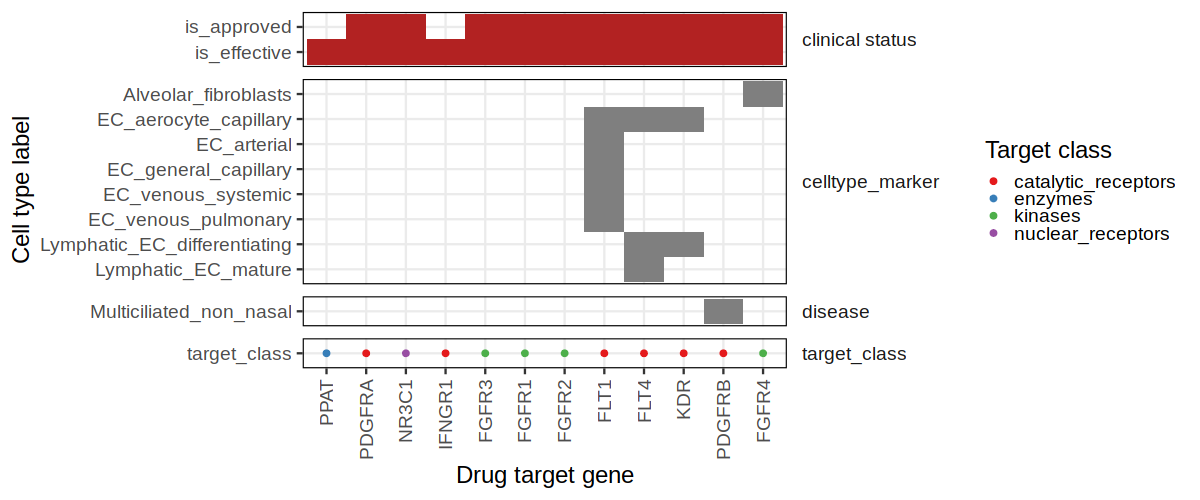

In [551]:
%%R -w 1200 -h 500
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_fine), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=24) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

In [1475]:
def get_expression(pbulk_adata, genes, long=True):
    X = pbulk_adata[:, pbulk_adata.var['feature_name'].isin(genes)].layers['logcounts'].toarray().copy()
    X_df = pd.DataFrame(X, columns=genes, index=pbulk_adata.obs_names)
    X_df['cell_type'] = pbulk_adata.obs['high_level_cell_type'].copy()
    X_df['disease'] = pbulk_adata.obs['disease'].copy()
    # X_df['donor_id'] = pbulk_adata.obs['donor_id'].copy()
    X_df = X_df.reset_index()
    if long:
        return(X_df.melt(id_vars=['cell_type', 'disease', 'index'], var_name='feature_name'))
    else:
        return(X_df)


/tmp/ipykernel_1790/1230777435.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.clustermap(X_df.groupby('cell_type').mean(),


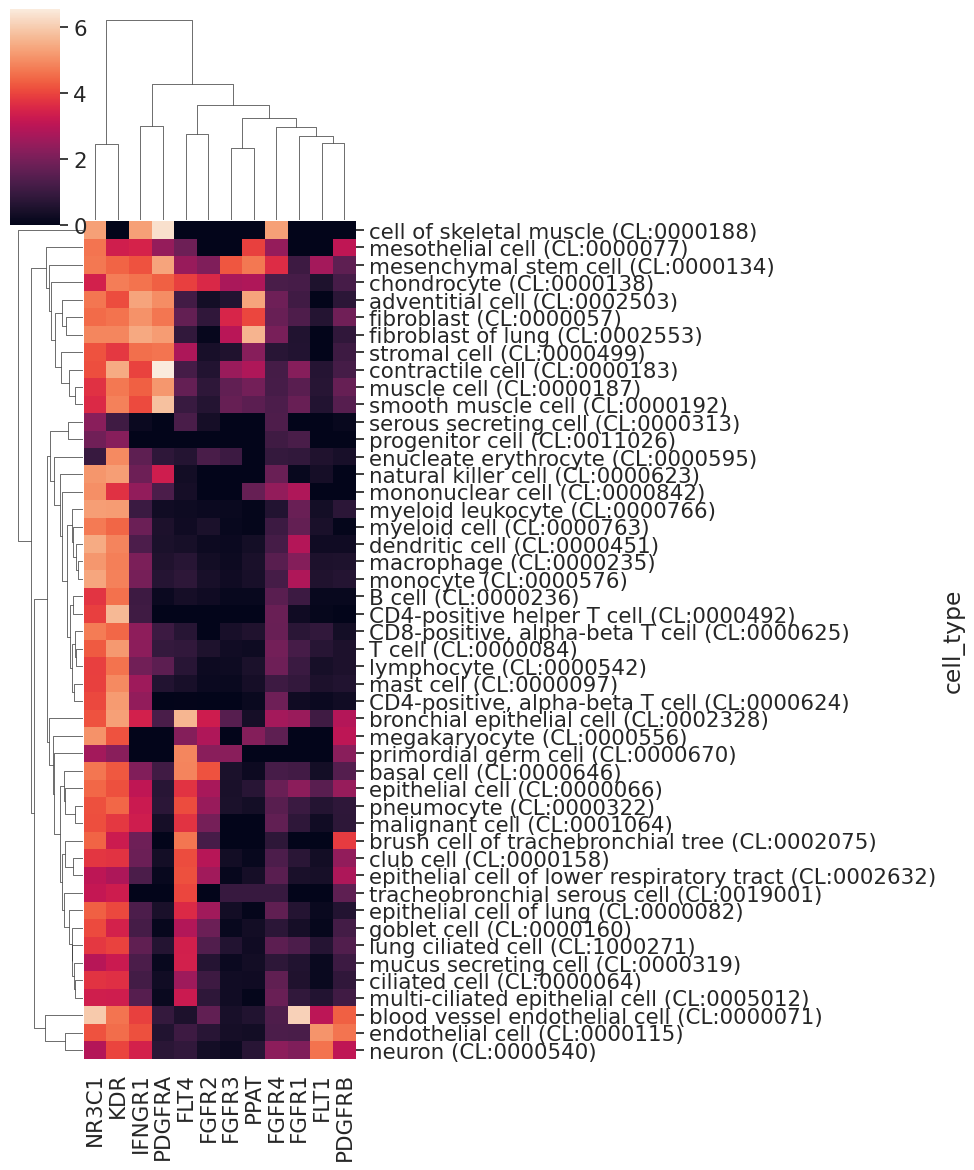

In [1484]:
X_df = get_expression(pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] == 'normal'], gene_names_df.loc[keep_targets].gene_name.values, long=False)
X_df = X_df[X_df['disease'] == 'normal'].copy()
sns.clustermap(X_df.groupby('cell_type').mean(), 
#                standard_scale=True,
               yticklabels=True,xticklabels=True, figsize=(10,12)
              );
plt.show()

In [669]:
target_mean_expression = pbulk_adata_coarse[:, targets_res_coarse.gene_id.values].layers['logcounts'].A.mean(0)

KeyError: 'logcounts'

In [670]:
targets_res_coarse['mean_expression'] = pbulk_adata_coarse[:, targets_res_coarse.gene_id.values].X.A.mean(0)
targets_res_coarse['mean_expression_normal'] = pbulk_adata_coarse[pbulk_adata_coarse.obs.disease == 'normal',:][:, targets_res_coarse.gene_id.values].X.A.mean(0)
targets_res_coarse['mean_expression_disease'] = pbulk_adata_coarse[pbulk_adata_coarse.obs.disease != 'normal',:][:, targets_res_coarse.gene_id.values].X.A.mean(0)

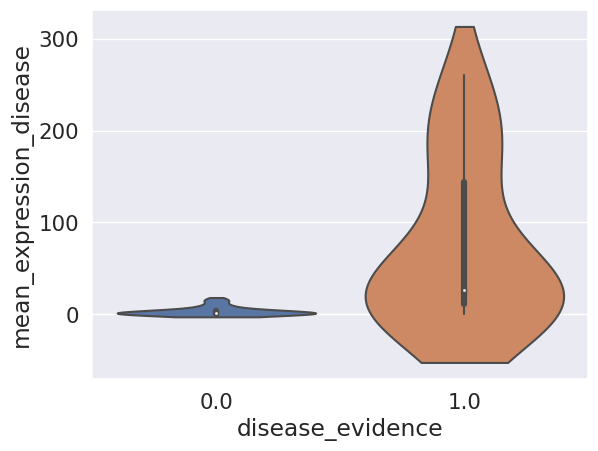

<AxesSubplot: xlabel='ct_marker_evidence', ylabel='mean_expression_normal'>

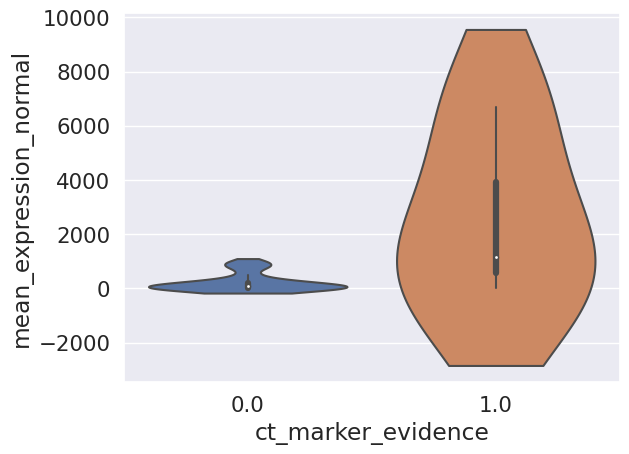

In [671]:
sns.violinplot(data=targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)],
               x='disease_evidence', y='mean_expression_disease', cut=True, scale='width'
              )
plt.show()
sns.violinplot(data=targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)],
               x='ct_marker_evidence', y='mean_expression_normal', cut=True, scale='width'
              )

In [1573]:
print(scipy.stats.pearsonr(
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['disease_evidence'], 
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression']
))

print(scipy.stats.pearsonr(
    targets_res_coarse['disease_evidence'], 
    targets_res_coarse['mean_expression']
))

print(scipy.stats.pearsonr(
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['ct_marker_evidence'], 
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse['ct_marker_evidence'], 
    targets_res_coarse['mean_expression_normal']
))
# scipy.stats.pearsonr(targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['ct_marker_evidence'], targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal'])

PearsonRResult(statistic=0.5133565167569448, pvalue=0.006170451526171939)
PearsonRResult(statistic=0.009340489933016753, pvalue=0.27181516786089893)
PearsonRResult(statistic=0.3427118230062824, pvalue=0.08012565121496178)
PearsonRResult(statistic=0.024413038619713216, pvalue=0.004072174776355569)



#### What are the cell type targets prioritized?

In [675]:
gene_list = gene_names_df.loc[targets_res_coarse.gene_id[targets_res_coarse.ct_marker_evidence == 1].unique()].gene_name.tolist()
background = DE_ct_res_coarse.gene_name.unique()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/',
                 # no_plot=True,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

In [677]:
enr.results[enr.results['Adjusted P-value'] < 0.1]

Gene_set  \
0         MSigDB_Hallmark_2020   
1         MSigDB_Hallmark_2020   
46  GO_Biological_Process_2017   
47  GO_Biological_Process_2017   
48  GO_Biological_Process_2017   
49  GO_Biological_Process_2017   
50  GO_Biological_Process_2017   
51  GO_Biological_Process_2017   
52  GO_Biological_Process_2017   
53  GO_Biological_Process_2017   
54  GO_Biological_Process_2017   
55  GO_Biological_Process_2017   
56  GO_Biological_Process_2017   
57  GO_Biological_Process_2017   
58  GO_Biological_Process_2017   
59  GO_Biological_Process_2017   
60  GO_Biological_Process_2017   
61  GO_Biological_Process_2017   
62  GO_Biological_Process_2017   
63  GO_Biological_Process_2017   
64  GO_Biological_Process_2017   
65  GO_Biological_Process_2017   
66  GO_Biological_Process_2017   
67  GO_Biological_Process_2017   
68  GO_Biological_Process_2017   
69  GO_Biological_Process_2017   
70  GO_Biological_Process_2017   

                                                 Term       P-value  \
0                   Epithelial Mesenchymal Transition  2.100715e-07   
1                                 Allograft Rejection  8.022811e-04   
46     extracellular matrix organization (GO:0030198)  8.700855e-08   
47                    muscle contraction (GO:0006936)  1.459337e-06   
48  G-protein coupled receptor signaling pathway (...  1.722601e-05   
49     B cell receptor signaling pathway (GO:0050853)  5.665662e-05   
50  positive regulation of B cell activation (GO:0...  6.814853e-05   
51                   cell-cell signaling (GO:0007267)  1.196438e-04   
52                       cilium movement (GO:0003341)  1.412539e-04   
53          collagen fibril organization (GO:0030199)  1.786917e-04   
54                sprouting angiogenesis (GO:0002040)  1.786917e-04   
55         defense response to bacterium (GO:0042742)  2.005286e-04   
56             phagocytosis, recognition (GO:0006910)  2.160606e-04   
57  transmembrane receptor protein tyrosine kinase...  2.291239e-04   
58            collagen catabolic process (GO:0030574)  2.344422e-04   
59             inner dynein arm assembly (GO:0036159)  2.344457e-04   
60  branching involved in blood vessel morphogenes...  2.420939e-04   
61  cell surface receptor signaling pathway (GO:00...  2.526378e-04   
62                   monocyte chemotaxis (GO:0002548)  3.250192e-04   
63  membrane depolarization during cardiac muscle ...  6.821891e-04   
64                   signal transduction (GO:0007165)  7.229244e-04   
65                     lymphangiogenesis (GO:0001946)  8.417449e-04   
66             dendritic cell chemotaxis (GO:0002407)  8.417449e-04   
67        cilium-dependent cell motility (GO:0060285)  8.883805e-04   
68            calcium-mediated signaling (GO:0019722)  1.206744e-03   
69                     T cell activation (GO:0042110)  1.465767e-03   
70                 calcium ion transport (GO:0006816)  1.465767e-03   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0           0.000010            0                     0    2.497730   
1           0.018452            0                     0    1.885882   
46          0.000146            0                     0    3.111886   
47          0.001224            0                     0    6.341623   
48          0.009629            0                     0    2.537191   
49          0.022857            0                     0    4.283099   
50          0.022857            0                     0   14.920848   
51          0.026480            0                     0    2.365863   
52          0.026480            0                     0    7.301560   
53          0.026480            0                     0    8.292208   
54          0.026480            0                     0    8.292208   
55          0.026480            0                     0    4.093995   
56          0.026480            0                     0    9.944637   
57          0.026480            0                     0    2.859897   
58          0.0

In [733]:
enr.results[enr.results['Adjusted P-value'] < 0.01][['Gene_set', 'Term', 'Adjusted P-value', 'Genes']].iloc[0].Genes

'ITK;GPR65;PRF1;THY1;EGFR;CCND3;IL18RAP;CCL7;STAT4;LYN;CD96;NPM1;TGFB2;FYB1;PRKCB;GZMA;GLMN;MMP9;NME1;NCR1;CD2;ZAP70;LCK;IL2RB;KLRD1;LCP2;CD247'

In [734]:
gene_list = gene_names_df.loc[targets_res_coarse.gene_id[targets_res_coarse.disease_evidence == 1].unique()].gene_name.tolist()
background = DE_res_coarse.gene_name.unique()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/',
                 # no_plot=True,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

In [735]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

Gene_set  \
0         MSigDB_Hallmark_2020   
50  GO_Biological_Process_2017   
51  GO_Biological_Process_2017   
52  GO_Biological_Process_2017   
53  GO_Biological_Process_2017   
54  GO_Biological_Process_2017   
55  GO_Biological_Process_2017   
56  GO_Biological_Process_2017   
57  GO_Biological_Process_2017   
58  GO_Biological_Process_2017   
59  GO_Biological_Process_2017   
60  GO_Biological_Process_2017   
61  GO_Biological_Process_2017   
62  GO_Biological_Process_2017   
63  GO_Biological_Process_2017   
64  GO_Biological_Process_2017   

                                                 Term       P-value  \
0                                 Allograft Rejection  3.326922e-12   
50                   leukocyte migration (GO:0050900)  7.659145e-09   
51  Fc-epsilon receptor signaling pathway (GO:0038...  5.048213e-08   
52         regulation of immune response (GO:0050776)  1.225984e-07   
53                   platelet activation (GO:0030168)  1.686675e-07   
54  Fc-gamma receptor signaling pathway involved i...  3.049580e-07   
55  cellular response to prostaglandin E stimulus ...  4.078129e-07   
56     T cell receptor signaling pathway (GO:0050852)  6.775572e-07   
57  peptidyl-tyrosine autophosphorylation (GO:0038...  1.339561e-06   
58                 complement activation (GO:0006956)  2.088805e-06   
59  positive regulation of interferon-gamma secret...  3.454248e-06   
60  complement activation, classical pathway (GO:0...  4.703102e-06   
61   regulation of complement activation (GO:0030449)  1.107078e-05   
62         receptor-mediated endocytosis (GO:0006898)  5.994628e-05   
63  transmembrane receptor protein tyrosine kinase...  7.096949e-05   
64  negative regulation of epithelial cell prolife...  1.031397e-04   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0       1.663461e-10            0                     0    6.110564   
50      8.731425e-06            0                     0    5.012297   
51      2.877482e-05            0                     0    4.888407   
52      4.658738e-05            0                     0    4.838611   
53      4.807023e-05            0                     0    6.680836   
54      6.953041e-05            0                     0    5.404997   
55      7.748446e-05            0                     0   84.419753   
56      1.103450e-04            0                     0    5.055279   
57      1.908874e-04            0                     0   10.210474   
58      2.645820e-04            0                     0    6.314496   
59      3.937843e-04            0                     0  134.748768   
60      4.874124e-04            0                     0    5.778328   
61      1.051724e-03            0                     0    5.257055   
62      5.256828e-03            0                     0    4.039020   
63      5.778944e-03            0                     0    5.769774   
64      7.838618e-03            0                     0    9.658416   

    Combined Score                                              Genes  
0       161.495944  ITK;GPR65;PRF1;THY1;EGFR;CCND3;IL18RAP;CCL7;ST...  
50       93.666626  LYN;ITGAM;SHC1;MMP1;IGKV1-5;PIK3R1;IGLV2-8;COL...  
51       82.133292  LYN;ITK;SHC1;IGKV1-5;NFATC3;NFATC2;PIK3R1;IGLV...  
52       77.003365  CD96;IGKV1-5;SH2D1B;IGLV2-8;IGLV2-11;COL1A1;NC...  
53      104.189889  LYN;PRKCH;PRKCB;ARRB1;PIK3R1;DGKZ;COL1A1;GNA14...  
54       81.091660  LYN;IGKV1-5;PIK3R1;IGLV2-8;IGLV2-11;IGHG2;IGLV...  
55     1242.022007                     PTGER4;SFRP1;GNG2;PTGER2;PTGDR  
56       71.809081  ITK;FYB1;TXK;RFTN1;PTPN22;PIK3R1;THY1;ZAP70;LC...  
57      138.077963          LYN;ITK;ZAP70;LCK;TXK;MATK;FYN;EGFR;IGF1R  
58       82.586772  IGLV2-8;IGLV2-11;IGHG2;IGLV1-40;CFH;IGKV1-39;I...  
59     1694.587807                           CD2;PTPN22;RASGRP1;CD244  
60       70.884419  IGLV2-8;IGLV2-11;IGHG2;IGLV1-40;IGLV2-14;IGKV1...  
61       59.989310  IGLV2-8;IGLV2-11;IGHG2;IGLV1-40;CFH;IGLV2-14;I...  
62       39.267601 

### Pneumonia

In [467]:
disease_ontology_id = 'MONDO_0005249'

In [468]:
pbulk_adata_fine = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

In [469]:
pbulk_adata_coarse = _process_pbulk(pbulk_adata_coarse)


In [470]:
pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()
pbulk_adata_fine[pbulk_adata_fine.obs['disease'] != 'normal'].obs.donor_id.nunique()

13

In [471]:
DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_res_fine = pd.read_csv(f'../data/HLCA_annotation_DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')

DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_fine = pd.read_csv(f'../data/HLCA_annotation_DE_celltype_{disease_ontology_id}.hvgs.csv')

In [472]:
targets_res_fine = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'all'}
        )

In [473]:
## Read results with coarse annotations
targets_res_coarse = pd.read_csv(f'../data/disease_target_evidence.{disease_ontology_id}.csv')

In [474]:
targets_res_fine.sum()

gene_id                  ENSG00000005961ENSG00000015413ENSG00000021461E...
disease_ontology_id      MONDO_0005249MONDO_0005249MONDO_0005249MONDO_0...
genetic_association                                               9.027879
known_drug                                                       19.634977
is_druggable                                                          44.0
is_safe                                                               43.0
is_effective                                                          34.0
is_approved                                                            7.0
has_genetic_support                                                   33.0
ct_marker_evidence                                                  1388.0
bulk_disease_evidence                                                550.0
disease_evidence                                                    2967.0
disease_ct_evidence                                                 2560.0
dtype: object

In [475]:
targets_res_coarse.sum()

Unnamed: 0                                                          73198950
gene_id                    ENSG00000005961ENSG00000015413ENSG00000021461E...
disease_ontology_id        MONDO_0005249MONDO_0005249MONDO_0005249MONDO_0...
genetic_association                                                 9.027879
known_drug                                                         19.634977
is_druggable                                                            44.0
is_safe                                                                 43.0
is_effective                                                            34.0
is_approved                                                              7.0
has_genetic_support                                                     33.0
ct_marker_evidence                                                    1166.0
bulk_disease_evidence                                                 1864.0
disease_evidence                                                      4003.0

In [476]:
pbulk_adata_fine.obs[['disease', 'donor_id']].drop_duplicates().groupby('disease').count()

donor_id
disease            
normal           85
pneumonia        13

In [477]:
pbulk_adata_coarse.obs[['disease', 'donor_id']].drop_duplicates().groupby('disease').count()

donor_id
disease            
normal          190
pneumonia        13

In [478]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

In [402]:
results_all_df = pd.DataFrame()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence']:
            or_df = association_utils.get_OR(targets_res_coarse, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'coarse'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(targets_res_fine, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'fine'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

In [405]:
results_all_df[results_all_df.clinical_status == 'is_approved']

odds_ratio    ci_low    ci_high      pval  n_success  n_insuccess  \
0    0.000000  0.000000  11.073053  1.000000        7.0      19397.0   
0    2.217301  0.048172  18.295919  0.398049        7.0      19397.0   
0    0.659946  0.014344   5.441953  0.793274        7.0      19397.0   
0    0.950803  0.020664   7.841309  0.677219        7.0      19397.0   
0    1.035128  0.022496   8.537039  0.648386        7.0      19397.0   
0    1.123878  0.024424   9.269334  0.620214        7.0      19397.0   
0    0.000000  0.000000   6.693834  1.000000        7.0      19397.0   
0    0.000000  0.000000  25.100260  1.000000        7.0      19397.0   
0    0.000000  0.000000  13.372862  1.000000        7.0       6543.0   
0    2.261663  0.049070  18.703222  0.392541        7.0       6543.0   
0    0.680030  0.014772   5.612572  0.784500        7.0       6543.0   
0    0.921668  0.020017   7.609132  0.687776        7.0       6543.0   
0    1.027743  0.022319   8.485977  0.650955        7.0       6543.0   
0    1.072526  0.023291   8.856237  0.636387        7.0       6543.0   
0    0.000000  0.000000   8.160657  1.000000        7.0       6543.0   
0    0.000000  0.000000  27.723827  1.000000        7.0       6543.0   
0    0.000000  0.000000  12.649515  1.000000        6.0      12521.0   
0    2.309000  0.048775  20.663363  0.392710        6.0      12521.0   
0    0.981785  0.020748   8.780236  0.671326        6.0      12521.0   
0    1.439900  0.030425  12.880122  0.541896        6.0      12521.0   
0    1.582280  0.033432  14.154739  0.510543        6.0      12521.0   
0    1.707146  0.036069  15.272717  0.485734        6.0      12521.0   
0    0.000000  0.000000   8.829040  1.000000        6.0      12521.0   
0    0.000000  0.000000  33.696792  1.000000        6.0      12521.0   

   n_supported_approved  n_supported               evidence clinical_status  \
0                   0.0       1145.0     ct_marker_evidence     is_approved   
0                   1.0       1357.0     ct_marker_evidence     is_approved   
0                   1.0       3912.0       disease_evidence     is_approved   
0                   1.0       2894.0       disease_evidence     is_approved   
0                   1.0       2691.0    disease_ct_evidence     is_approved   
0                   1.0       2506.0    disease_ct_evidence     is_approved   
0                   0.0       1823.0  bulk_disease_evidence     is_approved   
0                   0.0        523.0  bulk_disease_evidence     is_approved   
0                   0.0        324.0     ct_marker_evidence     is_approved   
0                   1.0        450.0     ct_marker_evidence     is_approved   
0                   1.0       1289.0       disease_evidence     is_approved   
0                   1.0       1003.0       disease_evidence     is_approved   
0                   1.0        914.0    disease_ct_evidence     is_approved   
0                   1.0        881.0    disease_ct_evidence     is_approved   
0                   0.0        514.0  bulk_disease_evidence     is_approved   
0                   0.0        161.0  bulk_disease_evidence     is_approved   
0                   0.0        789.0     ct_marker_evidence     is_approved   
0                   1.0        999.0     ct_marker_evidence     is_approved   
0                   1.0       2120.0       disease_evidence     is_approved   
0                   1.0       1528.0       disease_evidence     is_approved   
0                   1.0       1406.0    disease_ct_evidence     is_approved   
0                   1.0       1314.0    disease_ct_evidence     is_approved   
0                   0.0       1100.0  bulk_disease_evidence     is_approved   
0                   0.0        309.0  bulk_disease_evidence     is_approved   

                 universe annotation  
0  protein_coding_targets     coarse  
0  protein_coding_targets       fine  
0  protein_coding_targets     coarse  
0  protein_coding_targets       fine  
0  protein_coding_targets     c

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


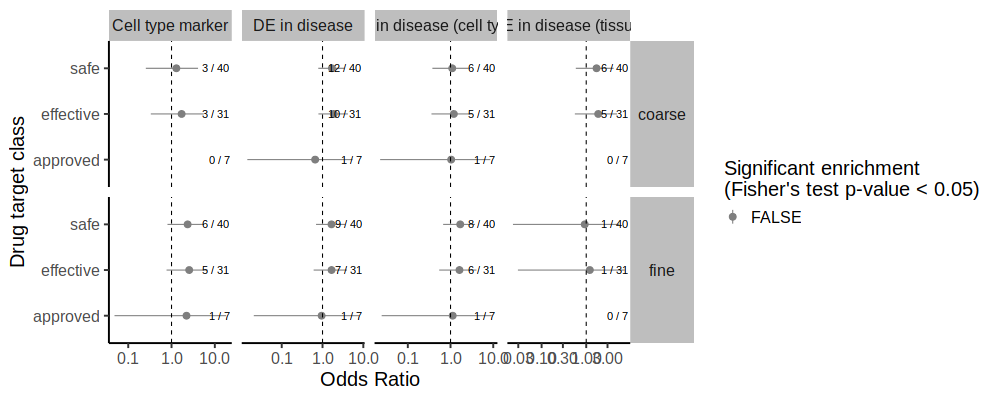

In [406]:
%%R -i results_all_df -w 1000 -h 400
pl_df <- results_all_df %>%
    filter(universe == 'protein_coding_targets')
plot_OR(pl_df, text_position='right') +
facet_grid(annotation~evidence, scales='free_x',
           labeller = labeller(evidence=as_labeller(evidence_labels))
          )

/tmp/ipykernel_2113/760740166.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/760740166.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/760740166.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


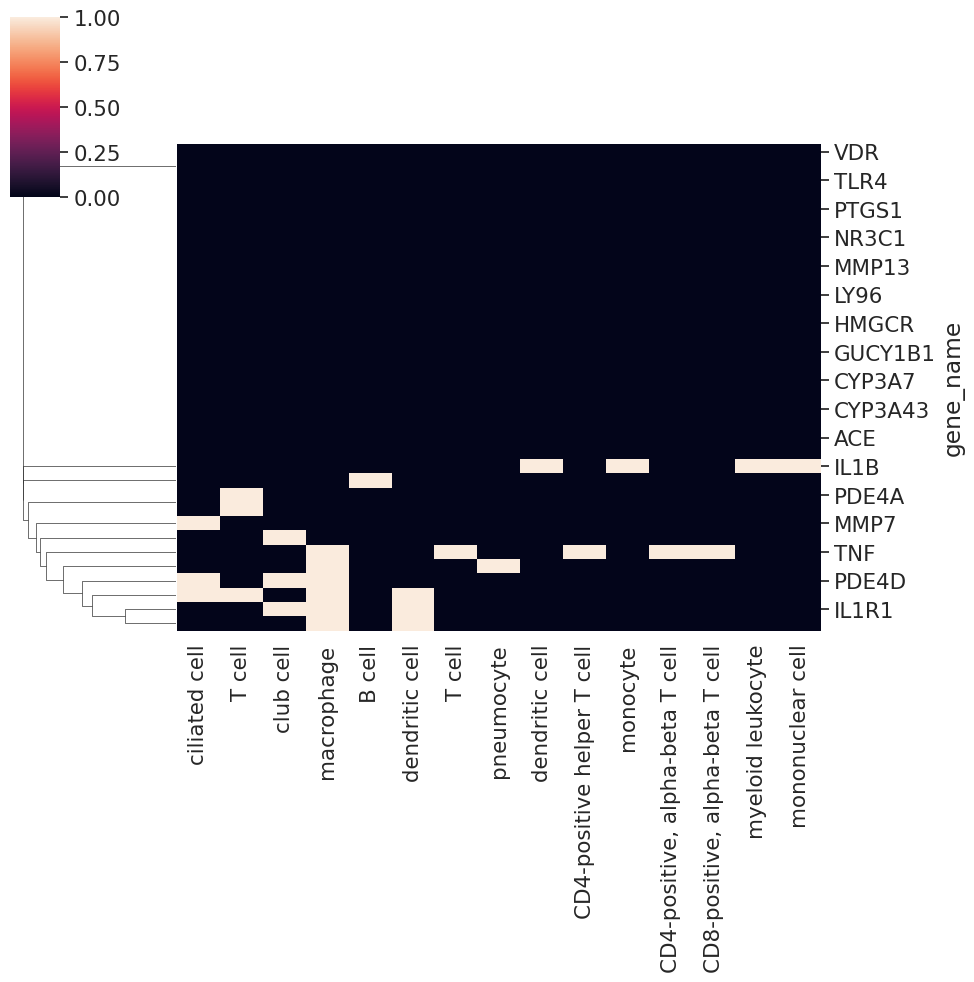

In [479]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_coarse[targets_res_coarse['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype', 
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [480]:
%%R -i pl_df -i ct_order_coarse -i row_order -i success_cols 
head(pl_df)

  gene_name      celltype value evidence target_success
1     PDE4D ciliated cell   yes  disease        targets
2      MMP7 ciliated cell   yes  disease        targets
3    IFNAR2 ciliated cell   yes  disease        targets
4     PDE4A        T cell   yes  disease        targets
5     PTGS2        T cell   yes  disease        targets
6    IFNAR2        T cell   yes  disease        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


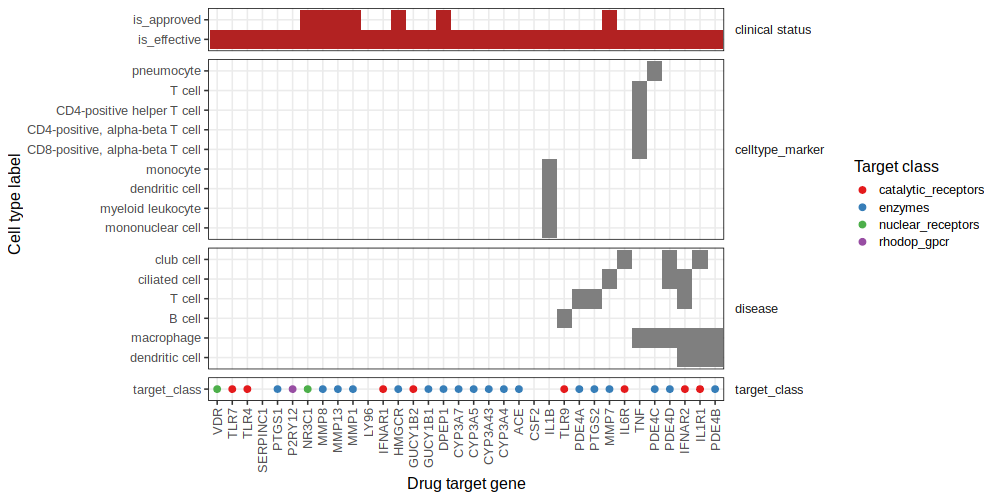

In [481]:
%%R -w 1000 -h 500
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_coarse), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=16) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

/tmp/ipykernel_2113/126945150.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/126945150.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/126945150.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


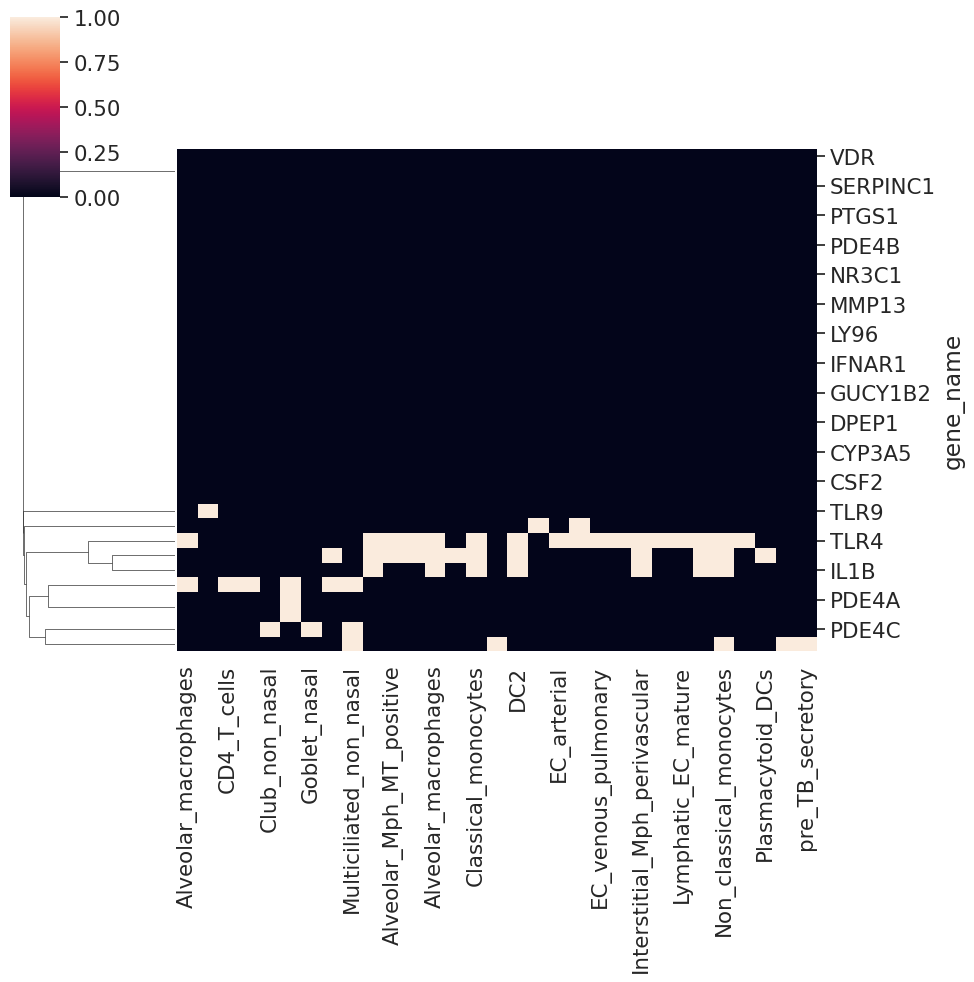

In [482]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_fine[targets_res_fine['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='celltype',
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_fine.loc[targets_res_fine.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_fine[DE_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_fine.loc[targets_res_fine.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [483]:
%%R -i pl_df -i ct_order_fine -i row_order -i success_cols 
head(pl_df)

  gene_name             celltype value evidence target_success
1      TLR4 Alveolar_macrophages   yes  disease        targets
2    IFNAR2 Alveolar_macrophages   yes  disease        targets
3      TLR9              B_cells   yes  disease        targets
4    IFNAR2          CD4_T_cells   yes  disease        targets
5    IFNAR2          CD8_T_cells   yes  disease        targets
6     PDE4C       Club_non_nasal   yes  disease        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


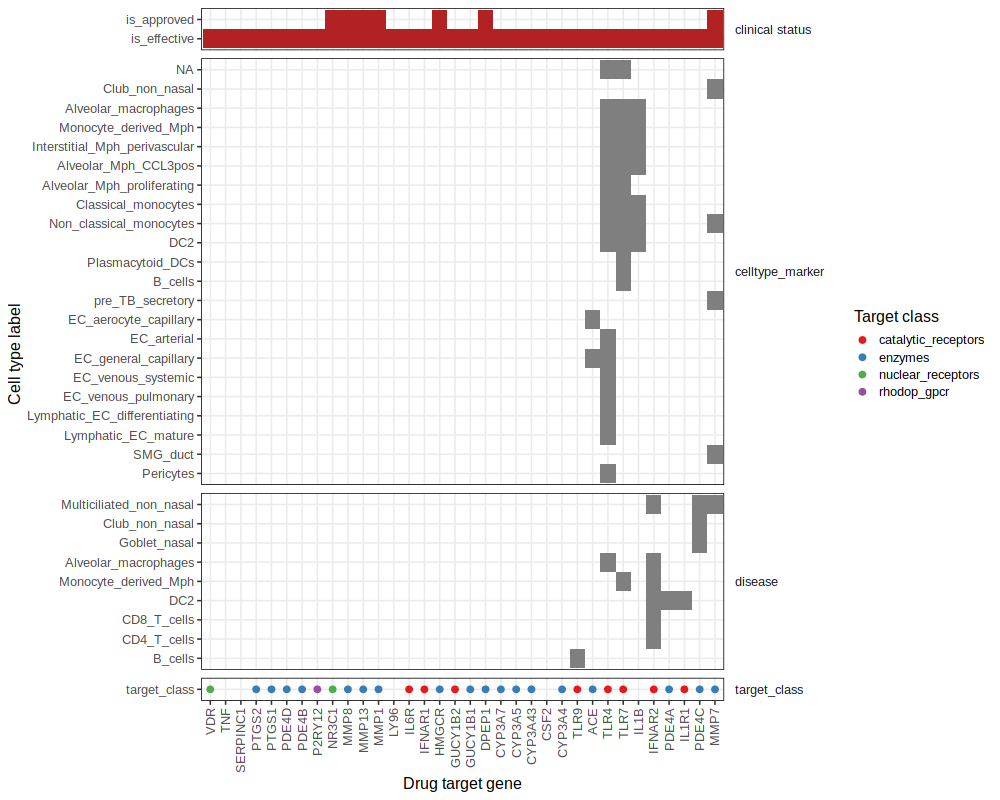

In [484]:
%%R -w 1000 -h 800
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_fine), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=16) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

In [434]:
approved_df = DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(targets_res_coarse[targets_res_coarse.is_approved==1].gene_id)]
approved_df[(approved_df.adj_pval < 0.01) & (approved_df.lfc > 5)]

gene_name      pval  adj_pval  f_statistic  df1          df2  \
1561        MMP7  0.000101  0.000441    15.225033    1  1189.043019   
36561       MMP7  0.000003  0.000055    21.995246    1  1189.043019   
61561       MMP7  0.002420  0.004583     9.239694    1  1189.043019   
181561      MMP7  0.001596  0.005063    10.010603    1  1189.043019   

              lfc gene_name.1          gene_id  \
1561    10.357843        MMP7  ENSG00000137673   
36561   13.040368        MMP7  ENSG00000137673   
61561    8.000412        MMP7  ENSG00000137673   
181561   8.412844        MMP7  ENSG00000137673   

       high_level_cell_type_ontology_term_id  
1561                        pre_TB_secretory  
36561                               SMG_duct  
61561                Non_classical_monocytes  
181561                        Club_non_nasal

In [ ]:
keep_targets = targets_res_fine[targets_res_fine['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='celltype', lfc_thresh=
                      )

In [1520]:
np.setdiff1d(pl_df.gene_name.unique(), DE_ct_res_coarse.gene_name.unique())
np.setdiff1d(pl_df.gene_name.unique(), DE_res_coarse.gene_name.unique())

array(['CYP3A4', 'CYP3A43', 'MMP8', 'SERPINC1', 'TLR9'], dtype=object)

In [1546]:
DE_res_coarse[DE_res_coarse.gene_name.isin(pl_df.gene_name.unique())].groupby('gene_name')['high_level_cell_type_ontology_term_id'].nunique()
# [['gene_name','high_level_cell_type_ontology_term_id']].groupby('high_level_cell_type_ontology_term_id').value_counts().

gene_name
ACE         4
CSF2        3
CYP3A5      4
CYP3A7      1
DPEP1       1
GUCY1B1     3
HMGCR       3
IFNAR1      1
IFNAR2     14
IL1B       17
IL1R1      13
IL6R        5
LY96        6
MMP1        7
MMP13       3
MMP7       11
NR3C1       3
P2RY12      5
PDE4A       4
PDE4B       9
PDE4C      15
PDE4D      17
PTGS1       5
PTGS2      16
TLR4        9
TLR7        2
TNF        10
VDR         8
Name: high_level_cell_type_ontology_term_id, dtype: int64

/tmp/ipykernel_1790/2327051226.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.clustermap(X_df.groupby('cell_type').mean()[row_order], col_cluster=False,


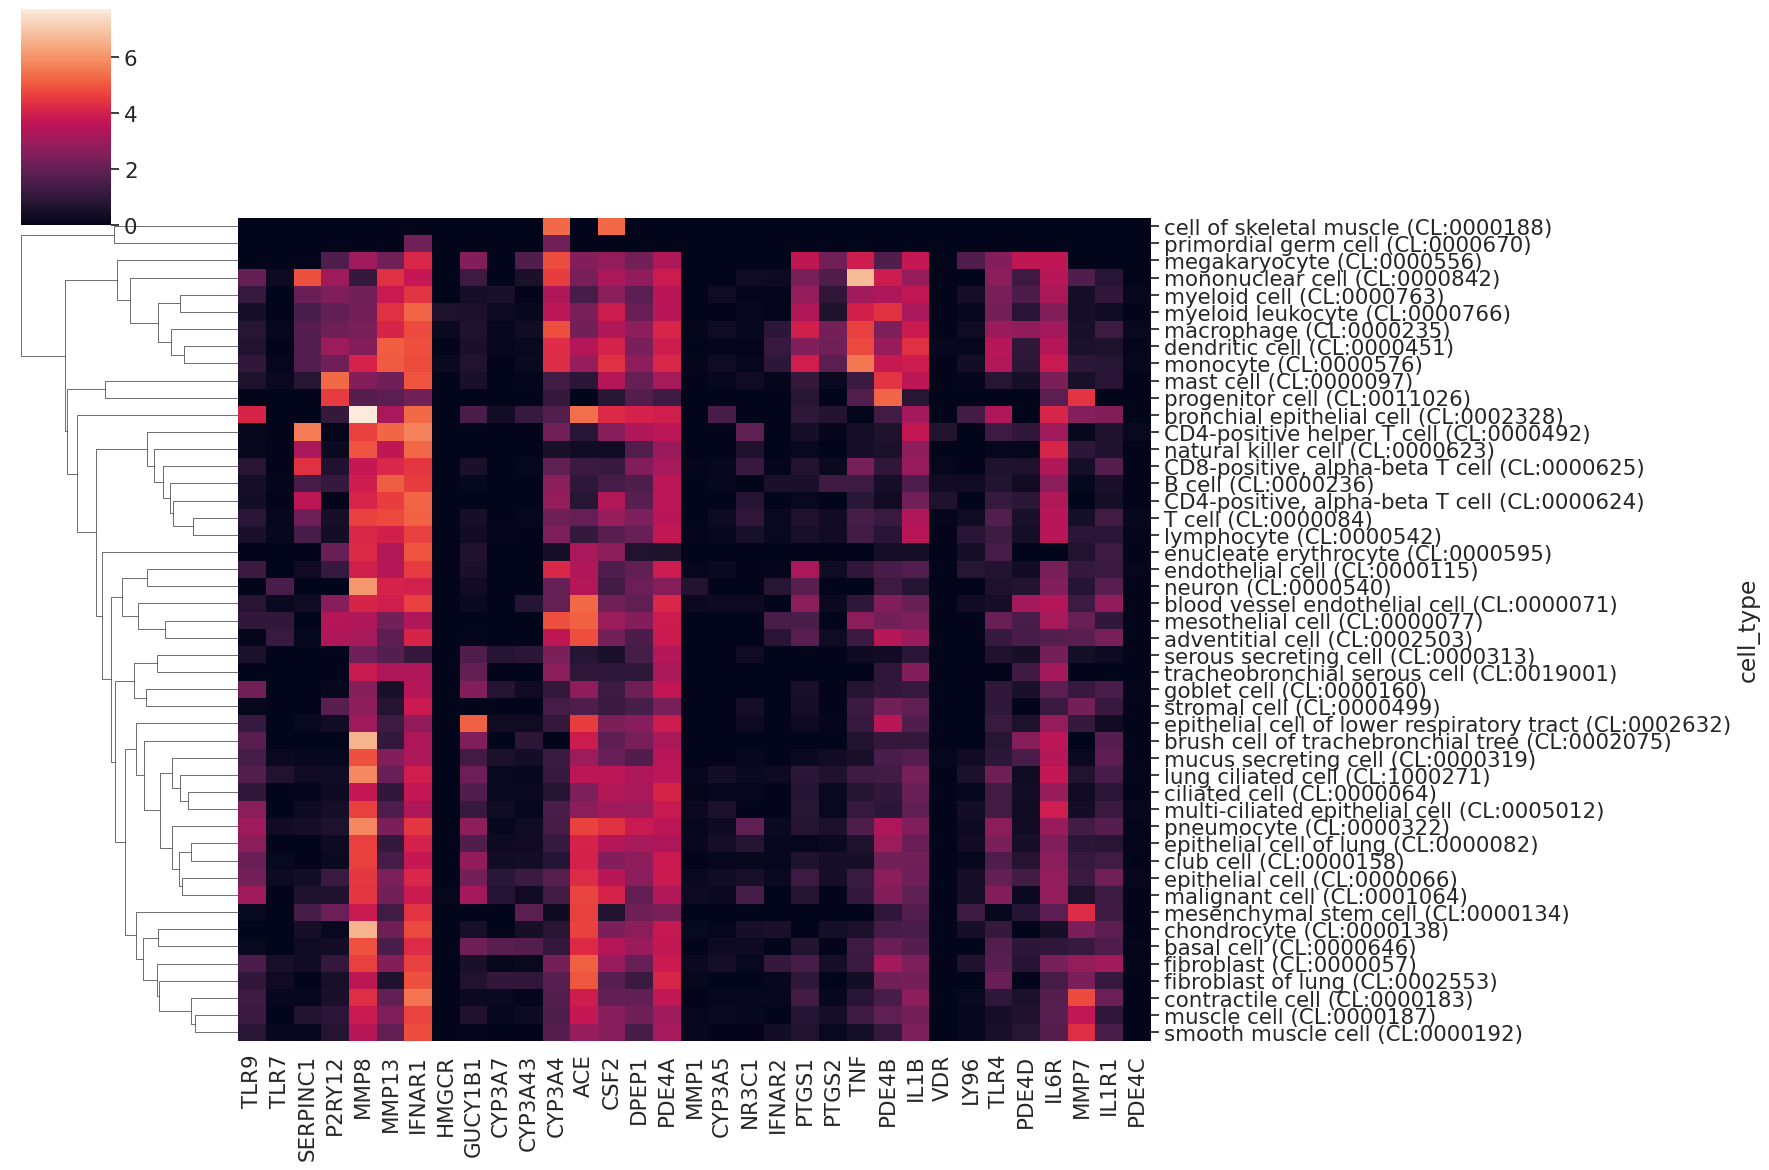

In [1512]:
X_df = get_expression(pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] == 'normal'], pl_df.gene_name.unique(), long=False)
X_df = X_df[X_df['disease'] == 'normal'].copy()
sns.clustermap(X_df.groupby('cell_type').mean()[row_order], col_cluster=False,
#                standard_scale=True,
               yticklabels=True,xticklabels=True, figsize=(18,12)
              );
plt.show()

In [1508]:
target_mean_expression = pbulk_adata_coarse[:, targets_res_coarse.gene_id.values].layers['logcounts'].A.mean(0)

In [1509]:
targets_res_coarse['mean_expression'] = pbulk_adata_coarse[:, targets_res_coarse.gene_id.values].X.A.mean(0)
targets_res_coarse['mean_expression_normal'] = pbulk_adata_coarse[pbulk_adata_coarse.obs.disease == 'normal',:][:, targets_res_coarse.gene_id.values].X.A.mean(0)
targets_res_coarse['mean_expression_disease'] = pbulk_adata_coarse[pbulk_adata_coarse.obs.disease != 'normal',:][:, targets_res_coarse.gene_id.values].X.A.mean(0)

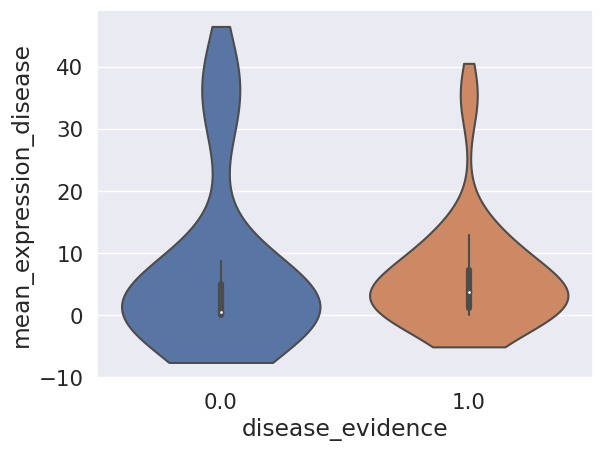

<AxesSubplot: xlabel='ct_marker_evidence', ylabel='mean_expression_normal'>

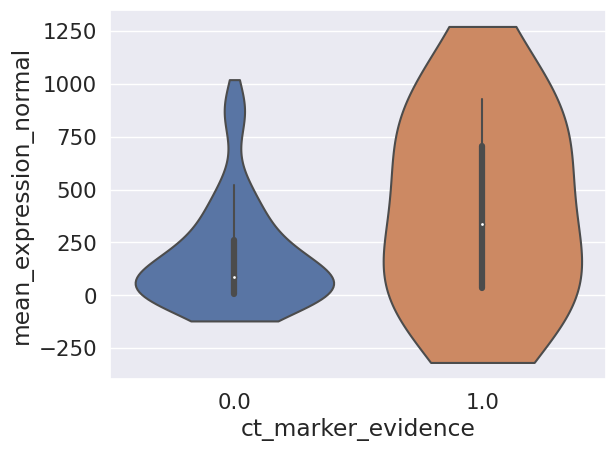

In [1510]:
sns.violinplot(data=targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)],
               x='disease_evidence', y='mean_expression_disease', cut=True, scale='width'
              )
plt.show()
sns.violinplot(data=targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)],
               x='ct_marker_evidence', y='mean_expression_normal', cut=True, scale='width'
              )

In [1511]:
print(scipy.stats.pearsonr(
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['disease_evidence'], 
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse['disease_evidence'], 
    targets_res_coarse['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['ct_marker_evidence'], 
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse['ct_marker_evidence'], 
    targets_res_coarse['mean_expression_normal']
))
# scipy.stats.pearsonr(targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['ct_marker_evidence'], targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal'])

PearsonRResult(statistic=0.14199171750839032, pvalue=0.42310324782453024)
PearsonRResult(statistic=0.029765768605703125, pvalue=0.006486923587851273)
PearsonRResult(statistic=0.2708775263805065, pvalue=0.12125532117154436)
PearsonRResult(statistic=0.026291355899001542, pvalue=0.016206034161653234)


In [1594]:
ev_genes_fine = targets_res_fine[targets_res_fine['disease_evidence'] == 1].gene_id
ev_genes_coarse = targets_res_coarse[targets_res_coarse['disease_evidence'] == 1].gene_id

ct_ev_genes_fine = targets_res_fine[targets_res_fine['ct_marker_evidence'] == 1].gene_id
ct_ev_genes_coarse = targets_res_coarse[targets_res_coarse['ct_marker_evidence'] == 1].gene_id

In [1595]:
coarse_only = np.setdiff1d(ct_ev_genes_coarse, ct_ev_genes_fine)
fine_only = np.setdiff1d(ct_ev_genes_fine, ct_ev_genes_coarse)
both = np.intersect1d(ct_ev_genes_fine, ct_ev_genes_coarse)

In [1596]:
coarse_only_de = DE_ct_res_coarse[(DE_ct_res_coarse.gene_id.isin(coarse_only)) & 
              (DE_ct_res_coarse.adj_pval < 0.1) &
              (np.abs(DE_ct_res_coarse['lfc']) > 0.5) 
             ]
fine_only_de = DE_ct_res_fine[(DE_ct_res_fine.gene_id.isin(fine_only)) & 
              (DE_ct_res_fine.adj_pval < 0.1) &
              (np.abs(DE_ct_res_fine['lfc']) > 0.5) 
             ]
both_fine_de = DE_ct_res_fine[(DE_ct_res_fine.gene_id.isin(both)) & 
              (DE_ct_res_fine.adj_pval < 0.1) &
              (np.abs(DE_ct_res_fine['lfc']) > 0.5) 
             ]

both_coarse_de = DE_ct_res_coarse[(DE_ct_res_coarse.gene_id.isin(both)) & 
              (DE_ct_res_coarse.adj_pval < 0.1) &
              (np.abs(DE_ct_res_coarse['lfc']) > 0.5) 
             ]

fine_only_de.high_level_cell_type_ontology_term_id.value_counts()

Alveolar_Mph_proliferating       539
Monocyte_derived_Mph             498
DC2                              491
Alveolar_macrophages             485
Alveolar_Mph_CCL3pos             475
Non_classical_monocytes          457
Interstitial_Mph_perivascular    456
Classical_monocytes              442
Suprabasal                       418
CD4_T_cells                      355
Hillock_like                     354
NK_cells                         353
B_cells                          348
DC1                              346
CD8_T_cells                      336
Club_non_nasal                   334
Plasma_cells                     332
Mast_cells                       330
Migratory_DCs                    321
Goblet_nasal                     316
Multiciliated_non_nasal          310
EC_general_capillary             305
Plasmacytoid_DCs                 302
Basal_resting                    293
Deuterosomal                     284
Alveolar_Mph_MT_positive         277
EC_venous_pulmonary              268
E

In [1597]:
target_group_dict = {
    'coarse_only_de':coarse_only_de,
    'fine_only_de':fine_only_de,
    'coarse_both_de':both_coarse_de,
    'fine_both_de':both_fine_de,
}

In [1598]:
df_all = pd.DataFrame()
for target_group,target_group_de in target_group_dict.items(): 
    top_cts = target_group_de.high_level_cell_type_ontology_term_id.value_counts()
    if top_cts.index[0].startswith("CL"):
        top_cts.index = [cellontology_utils.ontology2name(x.replace("_", ":"), graph) for x in top_cts.index]
    df = top_cts.reset_index()
    df.columns = ['cell_type', 'n_supported_targets']
    df['target_group'] = target_group
    df_all = pd.concat([df_all, df])

In [1599]:
df_all['annotation'] = df_all['target_group'].str.split('_', expand=True)[0]

In [1600]:
# fine_order = pbulk_adata_fine.obs.groupby('high_level_cell_type_ontology_term_id')['n_cells'].sum().sort_values()
fine_order = pbulk_adata_fine.obs.groupby('high_level_cell_type_ontology_term_id').size().sort_values().index.tolist()
fine_order =  [x.replace(' ', '_') for x in fine_order]
# coarse_order = pbulk_adata_coarse.obs.groupby('high_level_cell_type_ontology_term_id')['n_cells'].sum().sort_values()
coarse_order = pbulk_adata_coarse.obs.groupby('high_level_cell_type_ontology_term_id').size().sort_values()
coarse_order = [ontology2name(x, graph) for x in coarse_order.index]

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


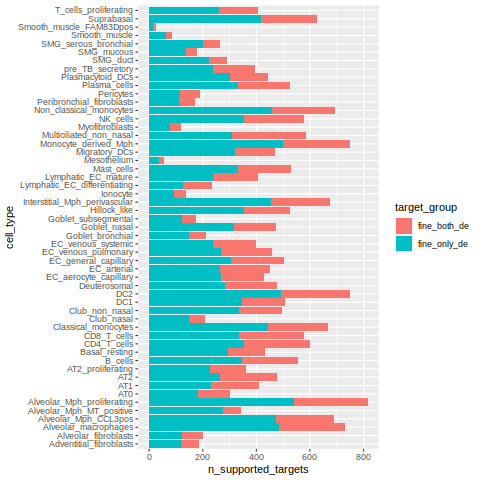

In [1601]:
%%R -i df_all -i coarse_order -i fine_order
df_all %>%
# filter(annotation == 'coarse') %>%
# mutate(cell_type = factor(cell_type, levels=coarse_order)) %>%
filter(annotation == 'fine') %>%
# mutate(cell_type = factor(cell_type, levels=unlist(fine_order))) %>%
ggplot(aes(cell_type, n_supported_targets, fill=target_group)) +
geom_col() +
coord_flip() 

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


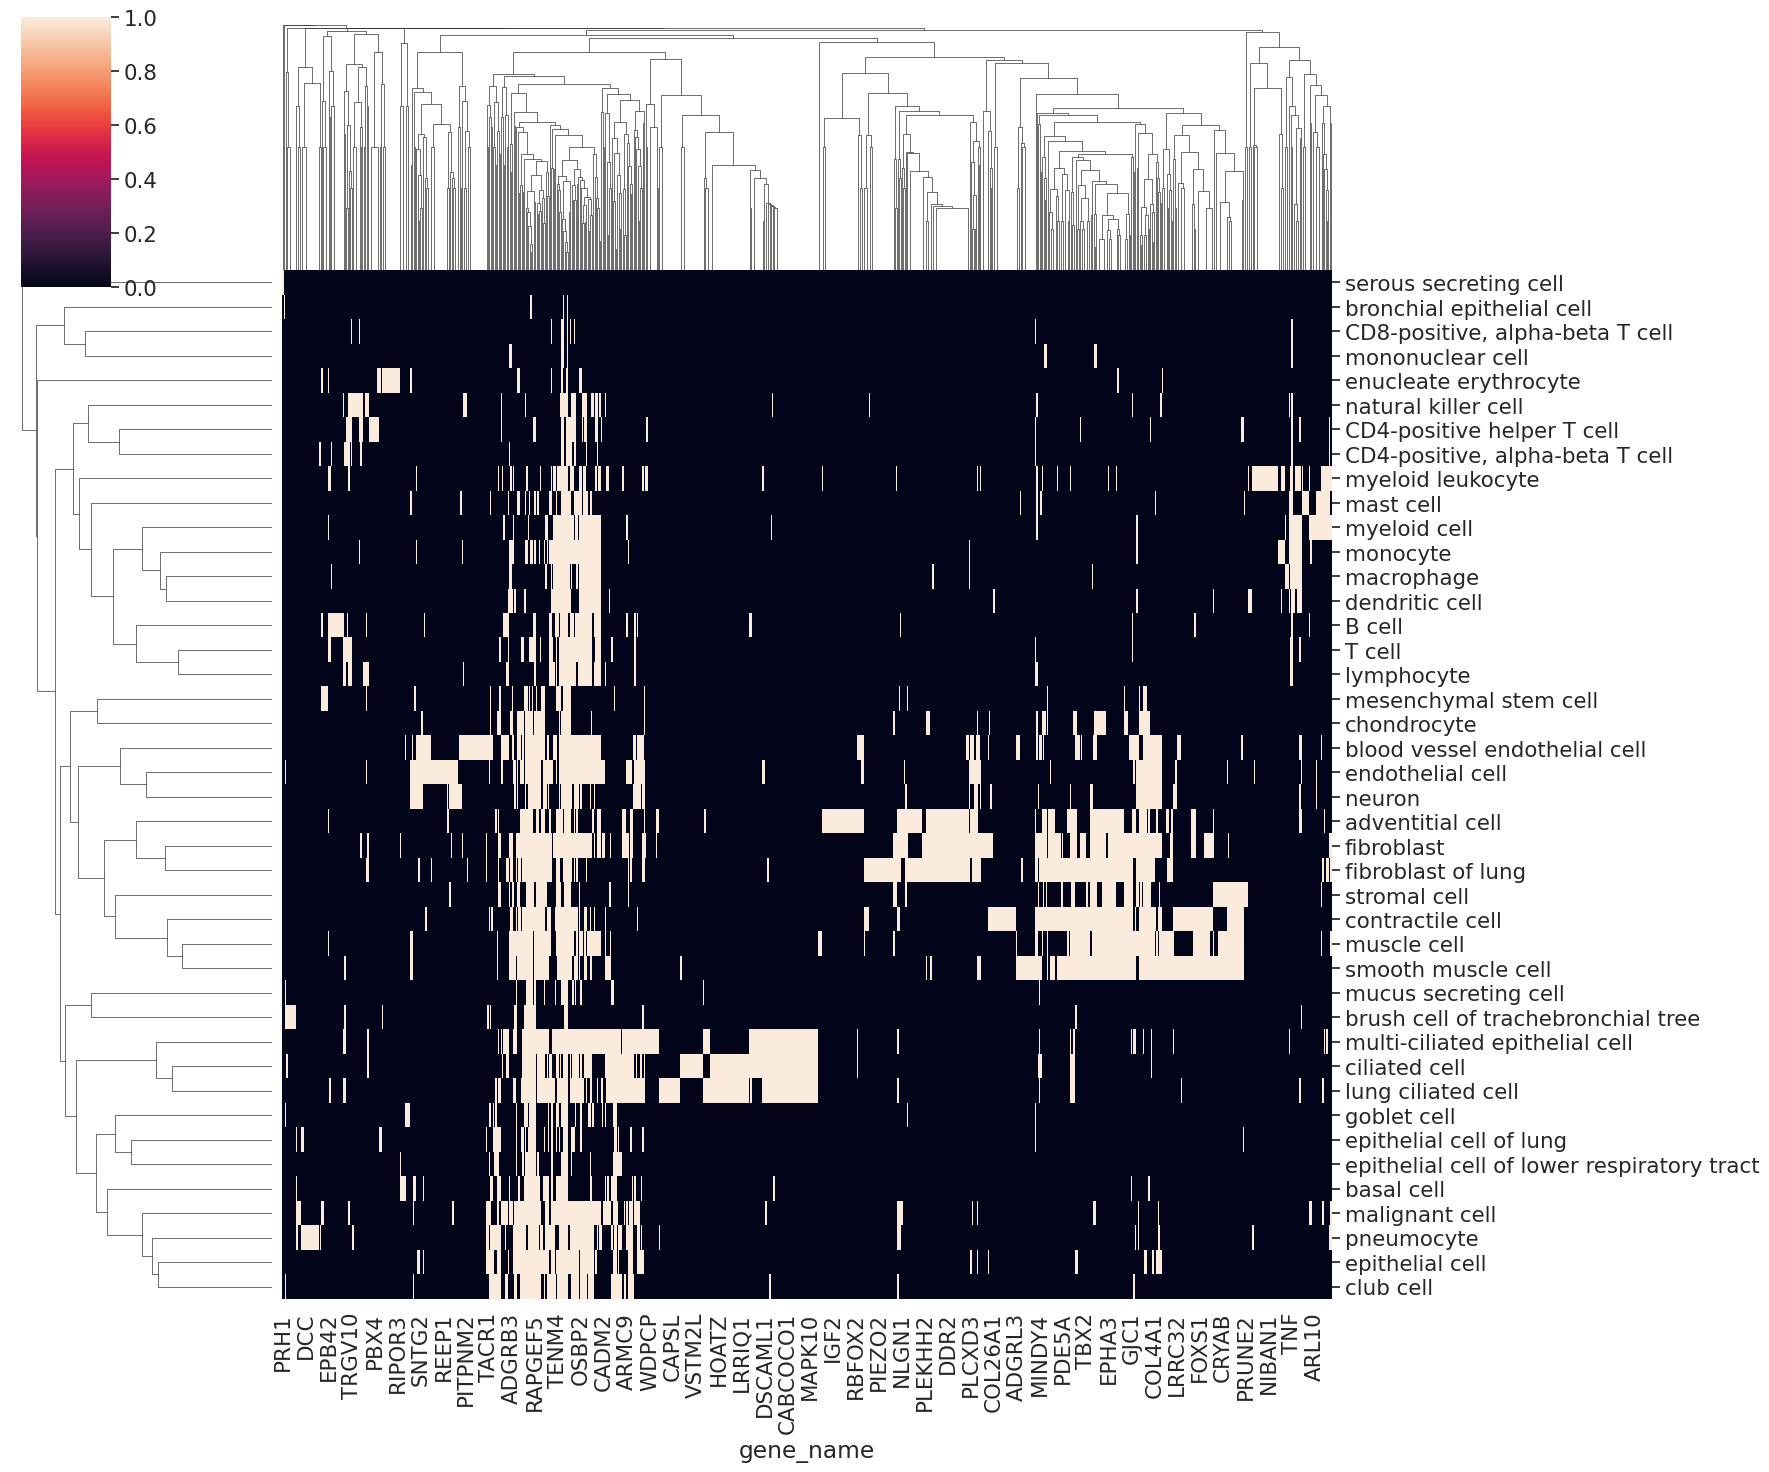

In [1602]:
df = DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(coarse_only)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, lfc_thresh=5.0,evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


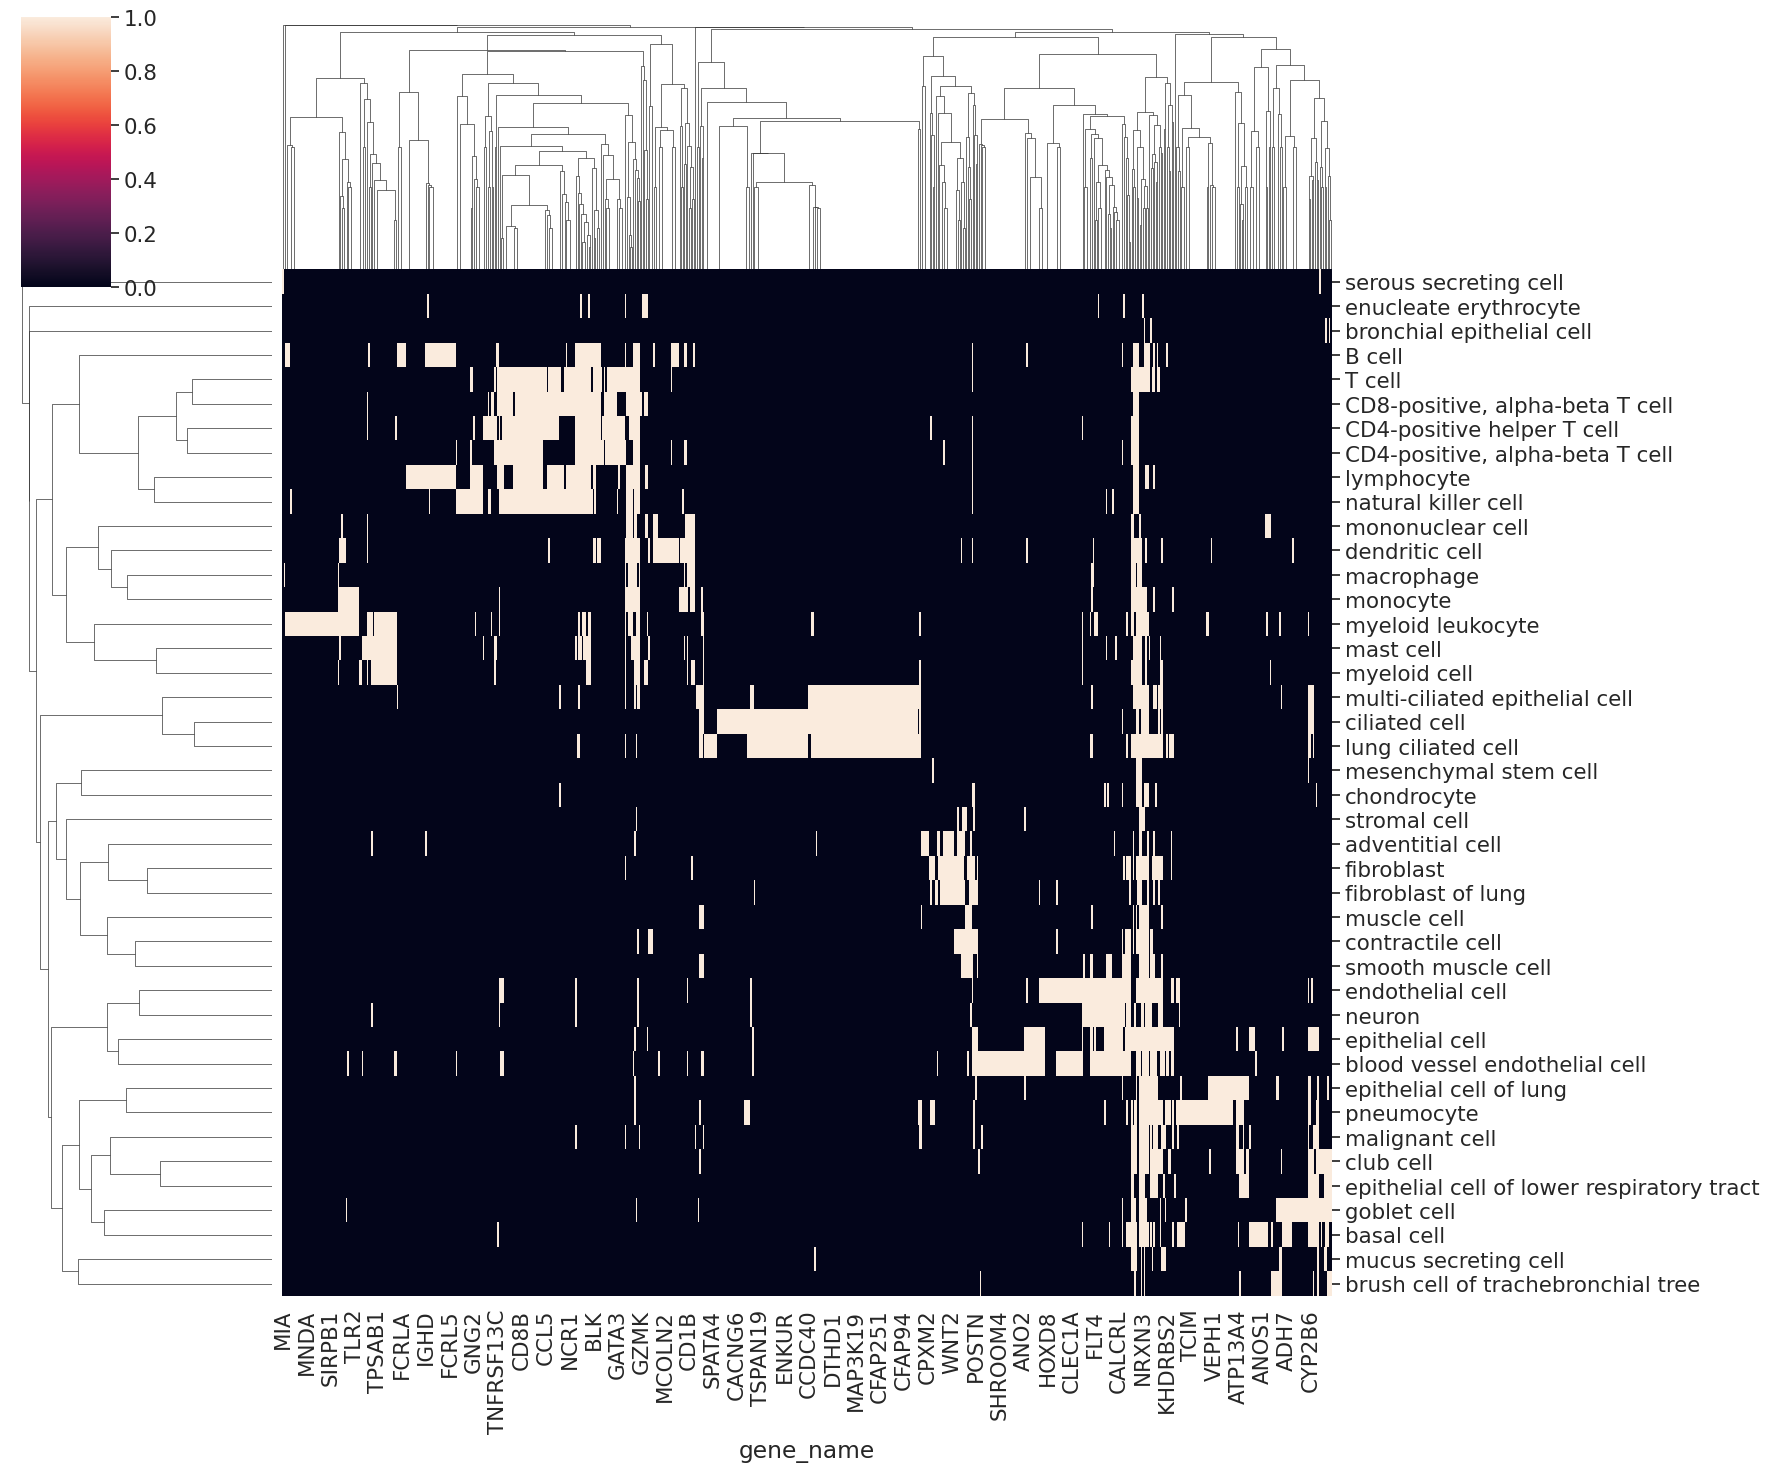

In [1603]:
df = DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(both)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, lfc_thresh=5.0,evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


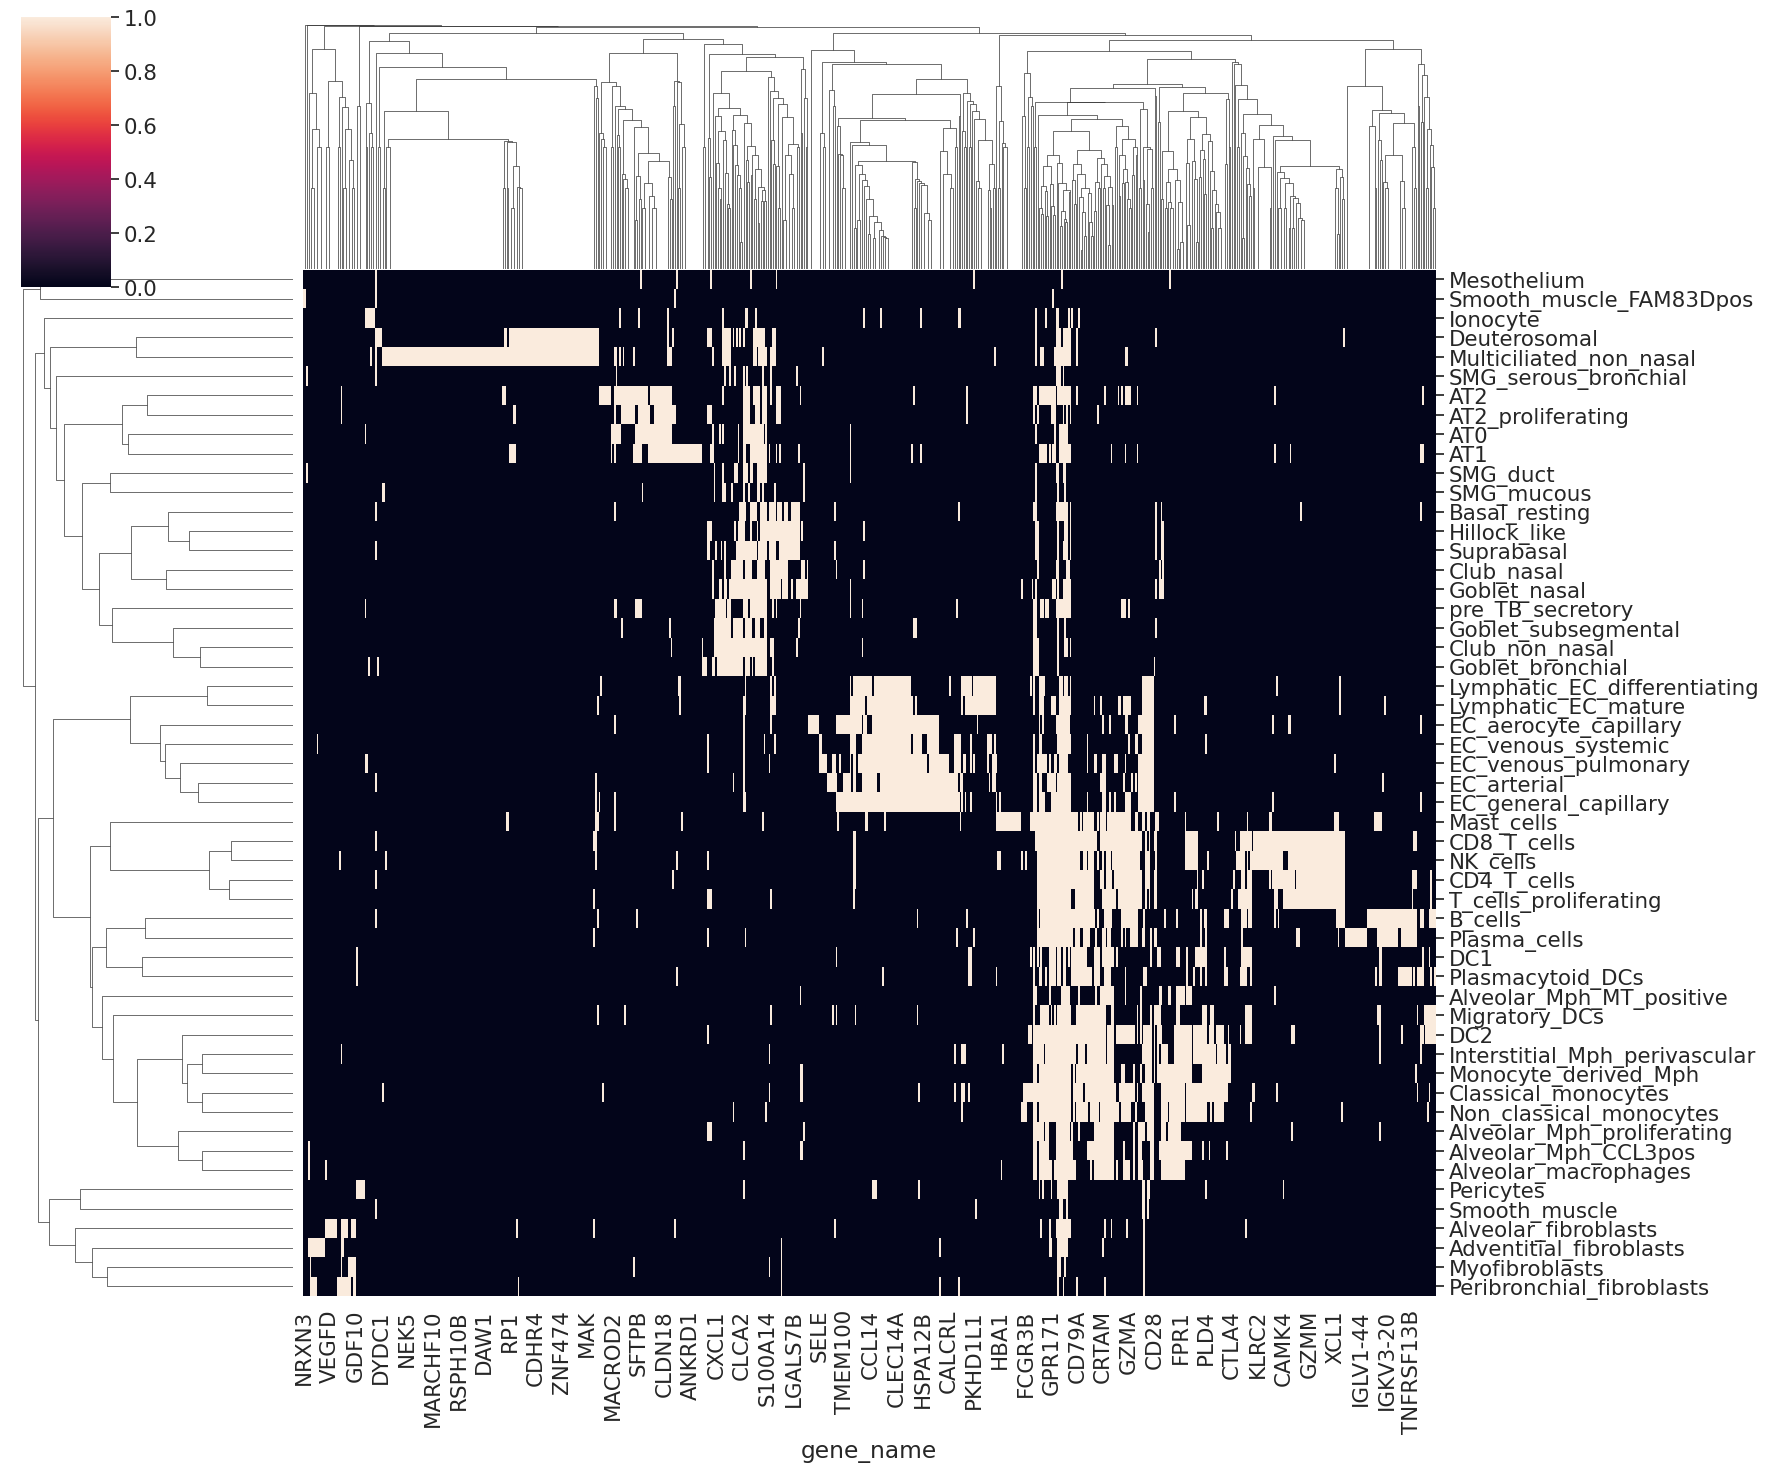

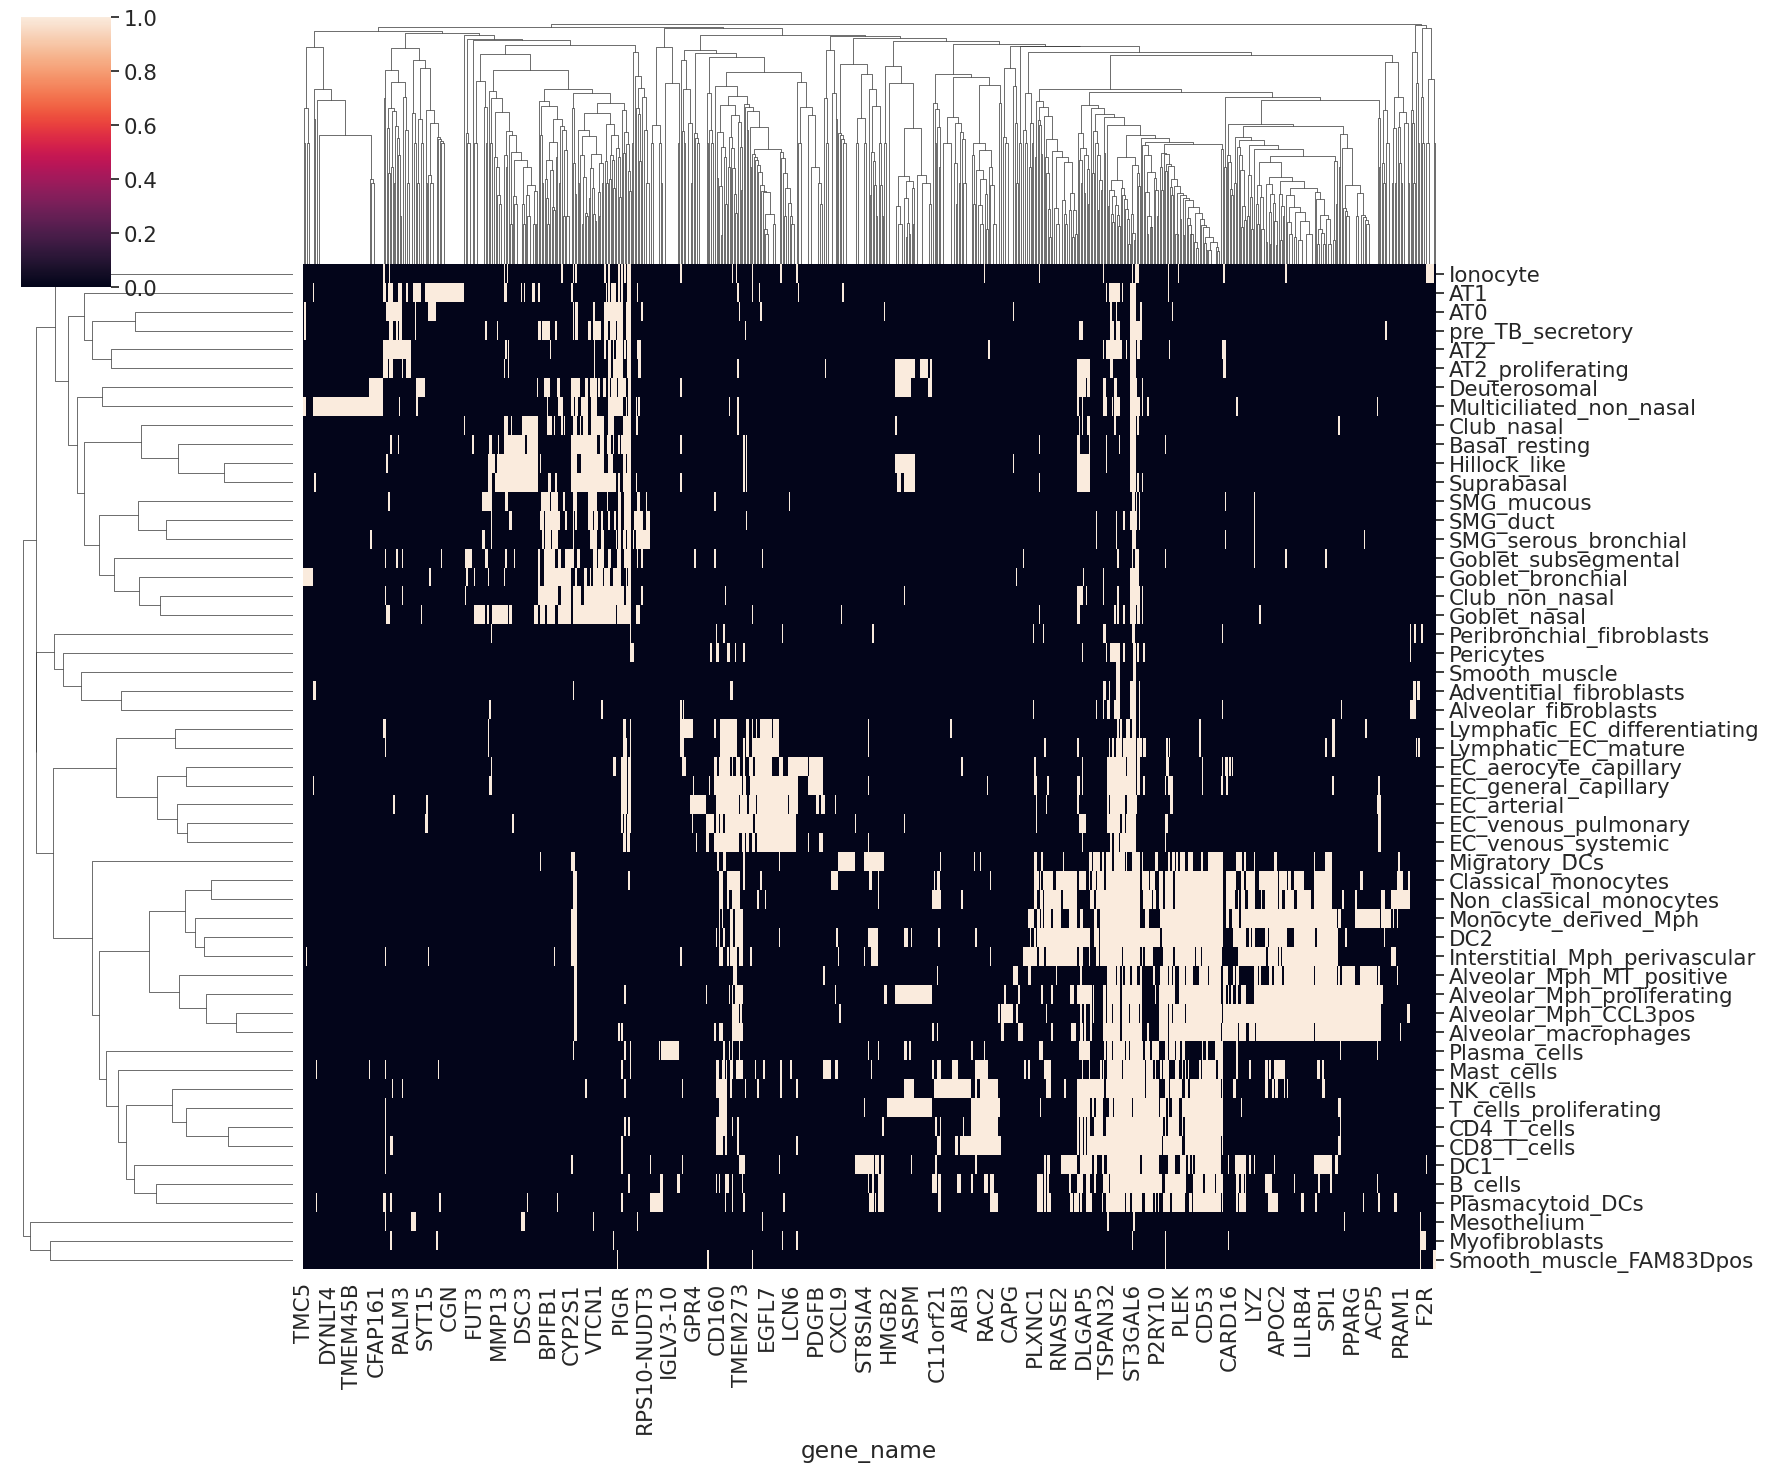

In [1604]:
df = DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(both)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, lfc_thresh=5.0,evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

df = DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(fine_only)].copy()
ct2gene_evidence = get_evidence_celltypes(df, targets_res_coarse, lfc_thresh=5.0,evidence='celltype')
sns.clustermap(ct2gene_evidence.drop('is_effective', axis=1).T, yticklabels=True, figsize=(18,15), metric='jaccard')

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: xlabel='Intersection size'>}

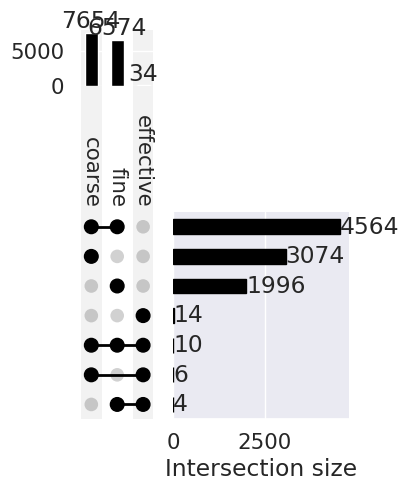

In [1605]:
upset_dict = {
    'fine':ev_genes_fine,
    'coarse': ev_genes_coarse,
    'effective': targets_res_fine.gene_id[targets_res_fine.is_effective == 1]
    }
target_universe_upset = upsetplot.from_contents(upset_dict)

# with plt.rc_context({'figure.figsize':[20,10]}):
pl = upsetplot.UpSet(
        target_universe_upset, 
        orientation='vertical', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        element_size=28
    )

pl.plot()

In [1606]:
evidence_cols = ['has_genetic_support', 'ct_marker_evidence', 'disease_evidence']
success_cols = ['is_effective', 'is_approved']

In [301]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

In [302]:
ct_order_coarse = ['fibroblast', 'adventitial cell', 'fibroblast of lung',
 'epithelial cell','epithelial cell of lung','pneumocyte',  'club cell', 'goblet cell', 'basal cell', 'epithelial cell of lower respiratory tract',
 'blood vessel endothelial cell',       'endothelial cell',
  'muscle cell', 'contractile cell', 'smooth muscle cell',
 'lymphocyte', 'T cell','CD4-positive helper T cell',        'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell','B cell','natural killer cell',
 'mast cell','monocyte',   'macrophage', 'dendritic cell', 'myeloid cell','myeloid leukocyte', 'mononuclear cell', 
 'chondrocyte', 
       'stromal cell', 'neuron', 
'malignant cell'
       ]

In [303]:
success_cols = ['is_effective', 'is_approved']
keep_targets = targets_res_coarse[targets_res_coarse['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'

df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


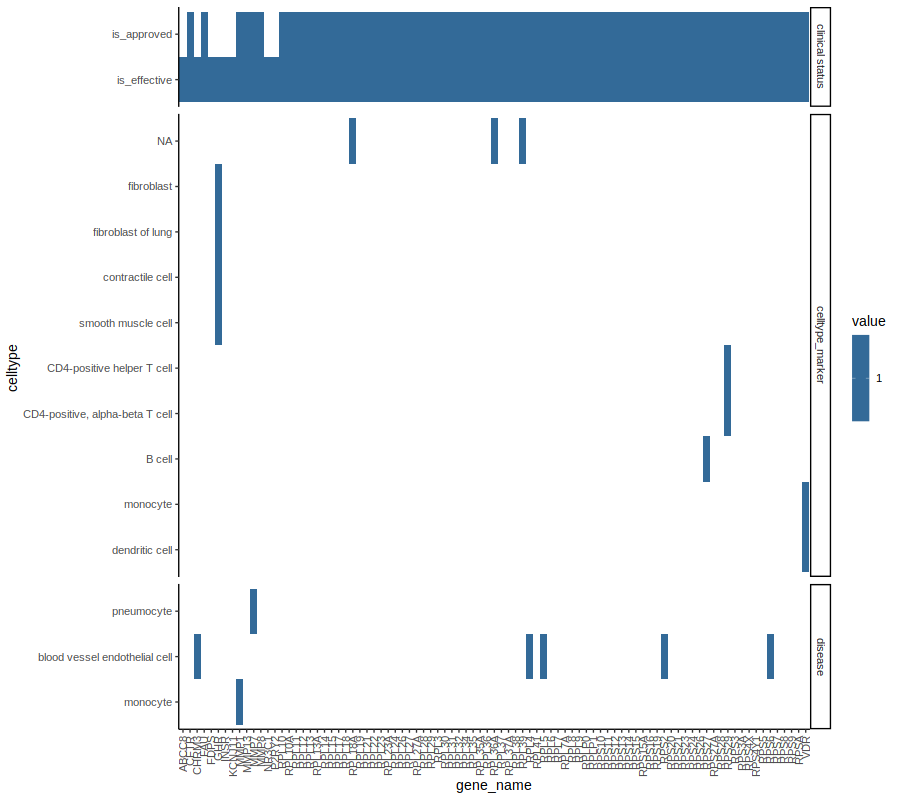

In [304]:
%%R -i pl_df -i ct_order_coarse -i success_cols -w 900 -h 800
pl_df %>%
filter(value == 1) %>%
mutate(evidence = factor(evidence, levels=c('clinical status', 'celltype_marker', 'disease'))) %>%
mutate(celltype = factor(celltype, levels=c(rev(ct_order_coarse), success_cols))) %>%
ggplot(aes(gene_name, celltype, fill=value)) +
geom_tile() +
facet_grid(evidence~., scales='free', space='free') +
theme_classic(base_size=14) +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

In [298]:
success_cols = ['is_effective', 'is_approved']
keep_targets = targets_res_fine[targets_res_fine['is_safe'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(keep_targets)], targets_res_fine, lfc_thresh=1,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values


df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'

df_dis = get_evidence_celltypes(DE_res_fine[DE_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])

In [299]:
ct_order_fine = ['AT1', 'AT2', 'AT2_proliferating','AT0','Mesothelium', 'Multiciliated_non_nasal','Basal_resting', 'Suprabasal',
                 'Club_nasal', 'Club_non_nasal','Goblet_bronchial','Ionocyte',
       'Goblet_nasal', 'Goblet_subsegmental','Hillock_like',
 'Adventitial_fibroblasts', 'Alveolar_fibroblasts',       'Myofibroblasts', 'Peribronchial_fibroblasts', 
 'Alveolar_macrophages', 'Monocyte_derived_Mph', 'Interstitial_Mph_perivascular', 'Alveolar_Mph_CCL3pos',  'Alveolar_Mph_proliferating',     'Classical_monocytes', 'Non_classical_monocytes', 'DC2', 
                 'Mast_cells','DC1', 'Migratory_DCs', 'Plasmacytoid_DCs',
 'CD8_T_cells', 'CD4_T_cells', 'NK_cells', 'B_cells','Plasma_cells', 'T_cells_proliferating','pre_TB_secretory', 'Deuterosomal',
 'EC_aerocyte_capillary', 'EC_arterial', 'EC_general_capillary', 'EC_venous_systemic', 'EC_venous_pulmonary','Lymphatic_EC_differentiating', 'Lymphatic_EC_mature','SMG_duct',
'Pericytes', 'Smooth_muscle']

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


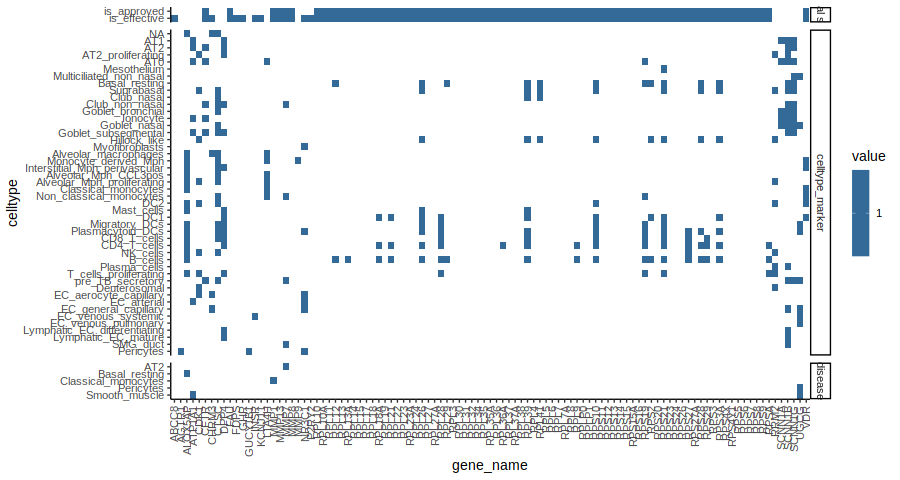

In [300]:
%%R -i pl_df -i ct_order_fine -i success_cols -w 900
pl_df %>%
filter(value == 1) %>%
mutate(evidence = factor(evidence, levels=c('clinical status', 'celltype_marker', 'disease'))) %>%
mutate(celltype = factor(celltype, levels=c(rev(ct_order_fine), success_cols))) %>%
ggplot(aes(gene_name, celltype, fill=value)) +
geom_tile() +
facet_grid(evidence~., scales='free', space='free') +
theme_classic(base_size=14) +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

### Cystic fibrosis

In [305]:
disease_ontology_id = 'MONDO_0009061'

In [306]:
pbulk_adata_fine = sc.read_h5ad(data_dir + f'HLCA_annotation_cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

In [307]:
## Exclude genes that are not measured in HLCA dataset
exclude_genes = np.setdiff1d(pbulk_adata_coarse.var_names, pbulk_adata_fine.var_names)

In [308]:
pbulk_adata_coarse[pbulk_adata_coarse.obs['disease'] != 'normal'].obs.donor_id.nunique()
pbulk_adata_fine[pbulk_adata_fine.obs['disease'] != 'normal'].obs.donor_id.nunique()

21

In [309]:
targets_res_fine = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'all'}
        )

In [310]:
## Read results with coarse annotations
targets_res_coarse = pd.read_csv(f'../data/disease_target_evidence.{disease_ontology_id}.csv')

In [311]:
targets_res_fine = targets_res_fine[~targets_res_fine.gene_id.isin(exclude_genes)]
targets_res_coarse = targets_res_coarse[~targets_res_coarse.gene_id.isin(exclude_genes)]

In [321]:
targets_res_fine[targets_res_fine['is_effective'] == 1].sum()

gene_id                  ENSG00000001626ENSG00000006071ENSG00000008988E...
disease_ontology_id      MONDO_0009061MONDO_0009061MONDO_0009061MONDO_0...
genetic_association                                               0.966406
known_drug                                                        70.50997
is_druggable                                                          89.0
is_safe                                                               89.0
is_effective                                                          89.0
is_approved                                                           81.0
has_genetic_support                                                    1.0
ct_marker_evidence                                                     2.0
bulk_disease_evidence                                                  2.0
disease_evidence                                                       1.0
disease_ct_evidence                                                    0.0
dtype: object

In [312]:
targets_res_fine.sum()

gene_id                  ENSG00000001084ENSG00000001626ENSG00000006071E...
disease_ontology_id      MONDO_0009061MONDO_0009061MONDO_0009061MONDO_0...
genetic_association                                              13.256779
known_drug                                                        75.09826
is_druggable                                                         126.0
is_safe                                                              119.0
is_effective                                                          89.0
is_approved                                                           81.0
has_genetic_support                                                   26.0
ct_marker_evidence                                                  1362.0
bulk_disease_evidence                                               1293.0
disease_evidence                                                     546.0
disease_ct_evidence                                                  354.0
dtype: object

In [313]:
targets_res_coarse.sum()

Unnamed: 0                                                          85985384
gene_id                    ENSG00000001084ENSG00000001626ENSG00000006071E...
disease_ontology_id        MONDO_0009061MONDO_0009061MONDO_0009061MONDO_0...
genetic_association                                                13.256779
known_drug                                                          75.09826
is_druggable                                                           126.0
is_safe                                                                119.0
is_effective                                                            89.0
is_approved                                                             81.0
has_genetic_support                                                     26.0
ct_marker_evidence                                                    1181.0
bulk_disease_evidence                                                 2606.0
disease_evidence                                                      3290.0

In [323]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

In [324]:
results_all_df = pd.DataFrame()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence']:
            or_df = association_utils.get_OR(targets_res_coarse, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'coarse'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(targets_res_fine, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['annotation'] = 'fine'
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

In [325]:
results_all_df[results_all_df.evidence == 'disease_evidence']

odds_ratio    ci_low   ci_high      pval  n_success  n_insuccess  \
0    0.955434  0.551196  1.574615  0.610282      118.0      19286.0   
0    0.305441  0.007654  1.742984  0.961335      118.0      19286.0   
0    0.775229  0.383497  1.435396  0.832005       89.0      19315.0   
0    0.406723  0.010164  2.335888  0.913839       89.0      19315.0   
0    0.544607  0.226397  1.132255  0.971405       81.0      19323.0   
0    0.000000  0.000000  1.670992  1.000000       81.0      19323.0   
0    1.083299  0.622870  1.792407  0.414977      118.0       6432.0   
0    0.320675  0.008003  1.847023  0.954686      118.0       6432.0   
0    0.876900  0.432633  1.629042  0.707614       89.0       6461.0   
0    0.428318  0.010660  2.482682  0.902550       89.0       6461.0   
0    0.614588  0.254925  1.281483  0.936276       81.0       6469.0   
0    0.000000  0.000000  1.767013  1.000000       81.0       6469.0   
0    0.838932  0.440268  1.484850  0.767883      105.0      12422.0   
0    0.000000  0.000000  1.434105  1.000000      105.0      12422.0   
0    0.726680  0.334238  1.414955  0.866600       85.0      12442.0   
0    0.000000  0.000000  1.781794  1.000000       85.0      12442.0   
0    0.613699  0.254699  1.278832  0.936939       79.0      12448.0   
0    0.000000  0.000000  1.921225  1.000000       79.0      12448.0   

   n_supported_approved  n_supported          evidence clinical_status  \
0                  19.0       3245.0  disease_evidence         is_safe   
0                   1.0        526.0  disease_evidence         is_safe   
0                  12.0       3245.0  disease_evidence    is_effective   
0                   1.0        526.0  disease_evidence    is_effective   
0                   8.0       3245.0  disease_evidence     is_approved   
0                   0.0        526.0  disease_evidence     is_approved   
0                  19.0        987.0  disease_evidence         is_safe   
0                   1.0        168.0  disease_evidence         is_safe   
0                  12.0        987.0  disease_evidence    is_effective   
0                   1.0        168.0  disease_evidence    is_effective   
0                   8.0        987.0  disease_evidence     is_approved   
0                   0.0        168.0  disease_evidence     is_approved   
0                  14.0       1939.0  disease_evidence         is_safe   
0                   0.0        304.0  disease_evidence         is_safe   
0                  10.0       1939.0  disease_evidence    is_effective   
0                   0.0        304.0  disease_evidence    is_effective   
0                   8.0       1939.0  disease_evidence     is_approved   
0                   0.0        304.0  disease_evidence     is_approved   

                 universe annotation  
0  protein_coding_targets     coarse  
0  protein_coding_targets       fine  
0  protein_coding_targets     coarse  
0  protein_coding_targets       fine  
0  protein_coding_targets     coarse  
0  protein_coding_targets       fine  
0    sm_tractable_targets     coarse  
0    sm_tractable_targets       fine  
0    sm_tractable_targets     coarse  
0    sm_tractable_targets       fine  
0    sm_tractable_targets     coarse  
0    sm_tractable_targets       fine  
0    ab_tractable_targets     coarse  
0    ab_tractable_targets       fine  
0    ab_tractable_targets     coarse  
0    ab_tractable_targets       fine  
0    ab_tractable_targets     coarse  
0    ab_tractable_targets       fine

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


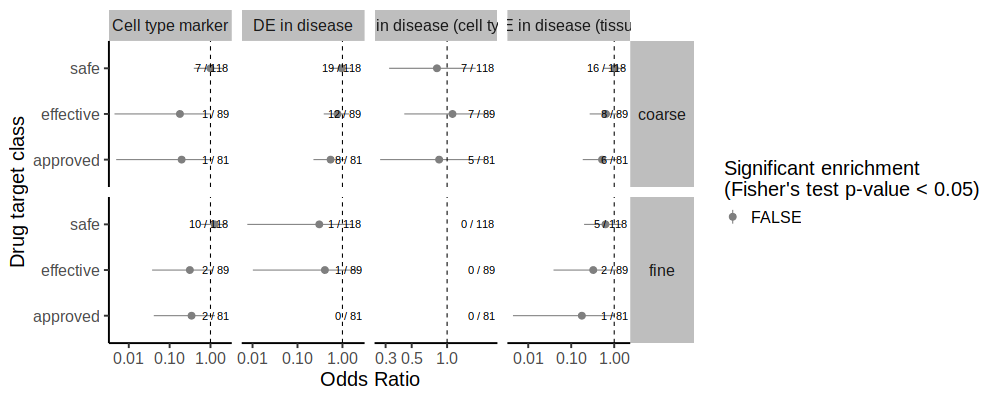

In [316]:
%%R -i results_all_df -w 1000 -h 400
pl_df <- results_all_df %>%
    filter(universe == 'protein_coding_targets')
plot_OR(pl_df, text_position='right') +
facet_grid(annotation~evidence, scales='free_x',
           labeller = labeller(evidence=as_labeller(evidence_labels))
          )

In [287]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

/tmp/ipykernel_2113/1429685671.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/1429685671.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/1429685671.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


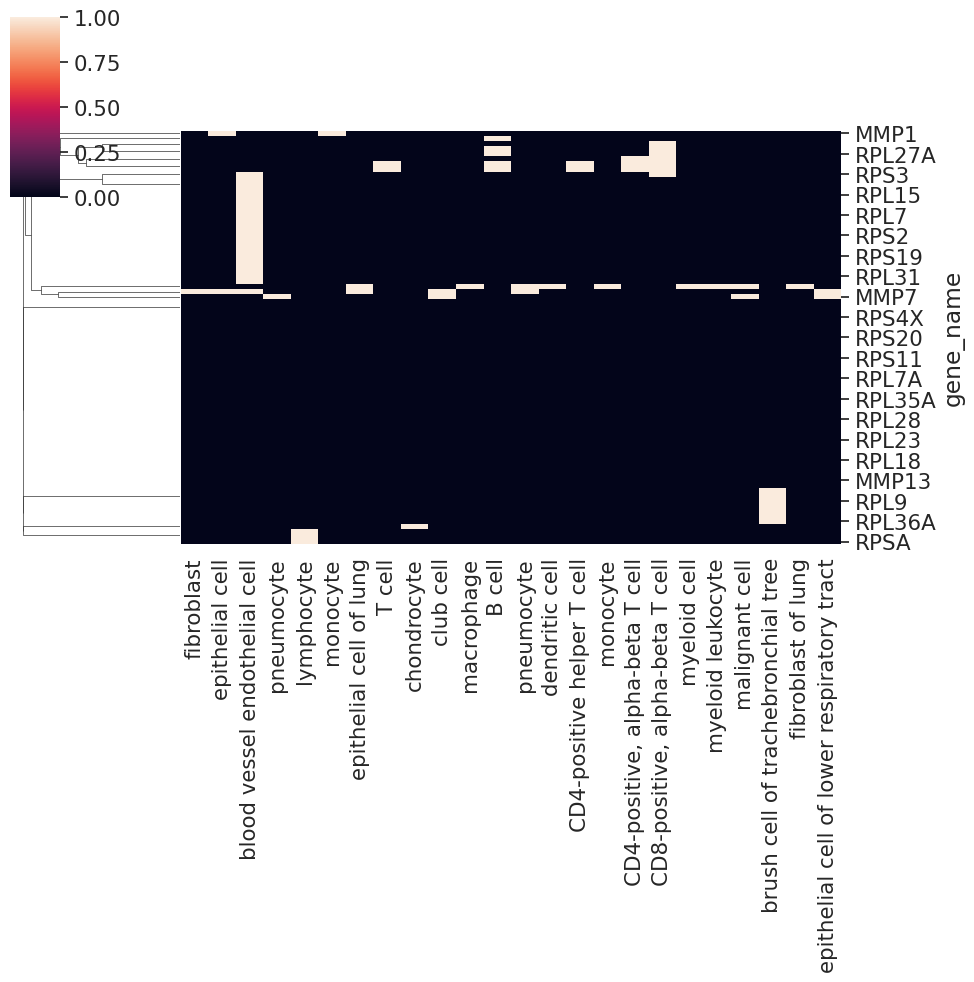

In [288]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_coarse[targets_res_coarse['is_approved'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [289]:
%%R -i pl_df -i ct_order_coarse -i row_order -i success_cols 
head(pl_df)

  gene_name                      celltype value evidence target_success
1      CFTR                    fibroblast   yes  disease        targets
2      CFTR               epithelial cell   yes  disease        targets
3      MMP1               epithelial cell   yes  disease        targets
4      CFTR blood vessel endothelial cell   yes  disease        targets
5     RPL31 blood vessel endothelial cell   yes  disease        targets
6      RPS5 blood vessel endothelial cell   yes  disease        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


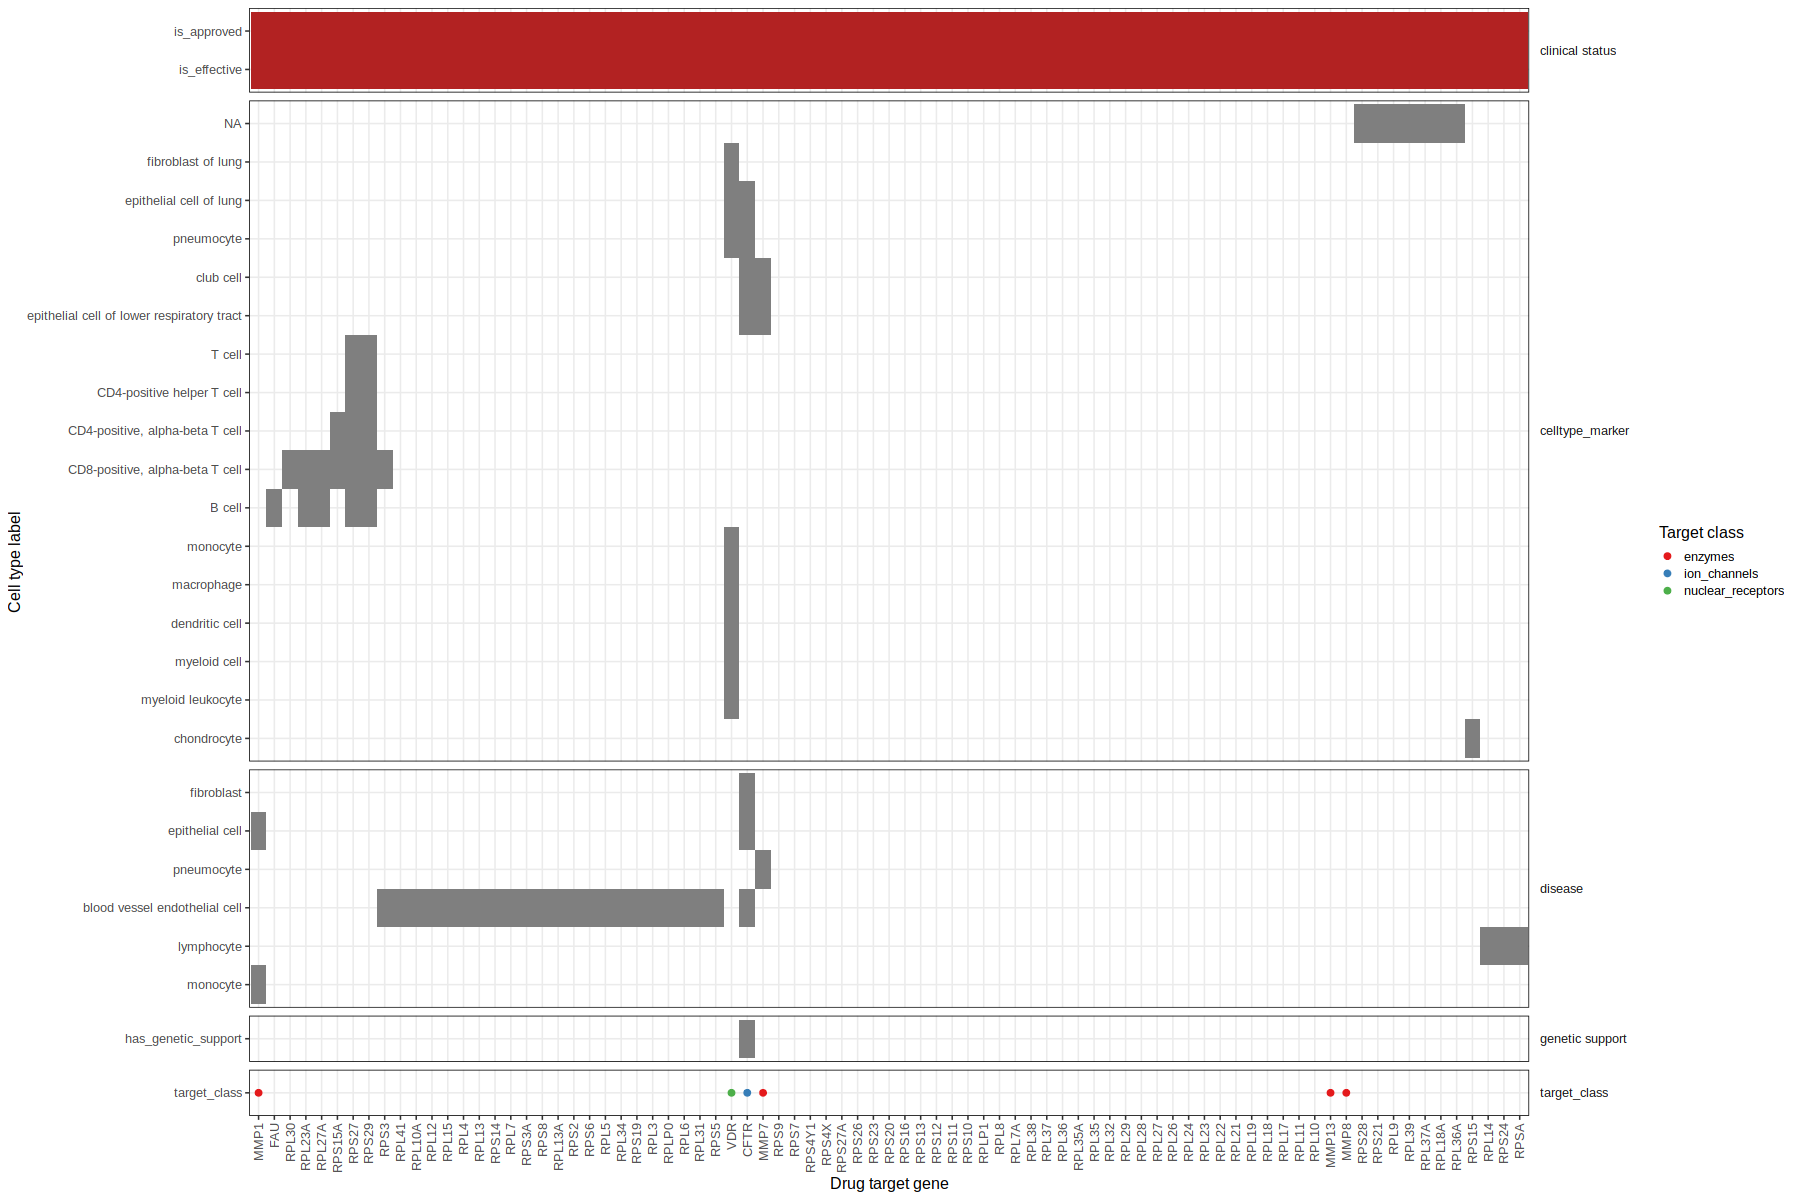

In [290]:
%%R -w 1800 -h 1200
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_coarse), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=16) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

In [291]:
success_cols = ['is_effective', 'is_safe', 'is_approved']
keep_targets = targets_res_fine[targets_res_fine['is_safe'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_fine[DE_ct_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values


df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'

df_dis = get_evidence_celltypes(DE_res_fine[DE_res_fine.gene_id.isin(keep_targets)], targets_res_fine,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])

In [292]:
ct_order_fine = ['AT1', 'AT2', 'AT2_proliferating','AT0','Mesothelium', 'Multiciliated_non_nasal','Basal_resting', 'Suprabasal',
                 'Club_nasal', 'Club_non_nasal','Goblet_bronchial','Ionocyte',
       'Goblet_nasal', 'Goblet_subsegmental','Hillock_like',
 'Adventitial_fibroblasts', 'Alveolar_fibroblasts',       'Myofibroblasts', 'Peribronchial_fibroblasts', 
 'Alveolar_macrophages', 'Monocyte_derived_Mph', 'Interstitial_Mph_perivascular', 'Alveolar_Mph_CCL3pos',  'Alveolar_Mph_proliferating',     'Classical_monocytes', 'Non_classical_monocytes', 'DC2', 
                 'Mast_cells','DC1', 'Migratory_DCs', 'Plasmacytoid_DCs',
 'CD8_T_cells', 'CD4_T_cells', 'NK_cells', 'B_cells','Plasma_cells', 'T_cells_proliferating','pre_TB_secretory', 'Deuterosomal',
 'EC_aerocyte_capillary', 'EC_arterial', 'EC_general_capillary', 'EC_venous_systemic', 'EC_venous_pulmonary','Lymphatic_EC_differentiating', 'Lymphatic_EC_mature','SMG_duct',
'Pericytes', 'Smooth_muscle']

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


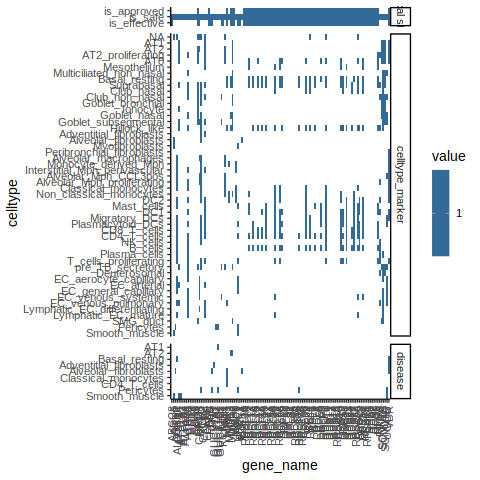

In [293]:
%%R -i pl_df -i ct_order_fine -i success_cols
pl_df %>%
filter(value == 1) %>%
mutate(evidence = factor(evidence, levels=c('clinical status', 'celltype_marker', 'disease'))) %>%
mutate(celltype = factor(celltype, levels=c(rev(ct_order_fine), success_cols))) %>%
ggplot(aes(gene_name, celltype, fill=value)) +
geom_tile() +
facet_grid(evidence~., scales='free', space='free') +
theme_classic(base_size=14) +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

### COPD

In [678]:
data_dir = '../data/'
disease_ontology_id = 'MONDO_0005002'

In [679]:
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

In [680]:
## Read results with coarse annotations
targets_res_coarse = pd.read_csv(f'../data/disease_target_evidence.{disease_ontology_id}.csv')

In [681]:
DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')

In [682]:
ct_order_coarse = ['fibroblast', 'adventitial cell', 'fibroblast of lung', 'brush cell of trachebronchial tree',
 'epithelial cell','epithelial cell of lung','pneumocyte',  'club cell', 'goblet cell', 'basal cell', 'epithelial cell of lower respiratory tract',
                   'ciliated cell','lung ciliated cell', 'multi-ciliated epithelial cell',
 'blood vessel endothelial cell',       'endothelial cell','mucus secreting cell',
  'muscle cell', 'contractile cell', 'smooth muscle cell',
 'lymphocyte', 'T cell','CD4-positive helper T cell',        'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell','B cell','natural killer cell',
 'mast cell','monocyte',   'macrophage', 'dendritic cell', 'myeloid cell','myeloid leukocyte', 'mononuclear cell', 
 'chondrocyte', 
       'stromal cell', 'neuron', 'enucleate erythrocyte',
'malignant cell'
       ]

In [683]:
# df_dis = get_evidence_celltypes(DE_res_coarse, targets_res_coarse, evidence='disease', clinical_status_cols=[])
# plt.hist(df_dis.sum(1), bins=df_dis.shape[1]+1);

In [684]:
gene_names_df = pbulk_adata_coarse.var[['feature_name', 'feature_id']].copy()
gene_names_df.columns = ['gene_name', 'gene_id']

/tmp/ipykernel_2113/1429685671.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/1429685671.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_2113/1429685671.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


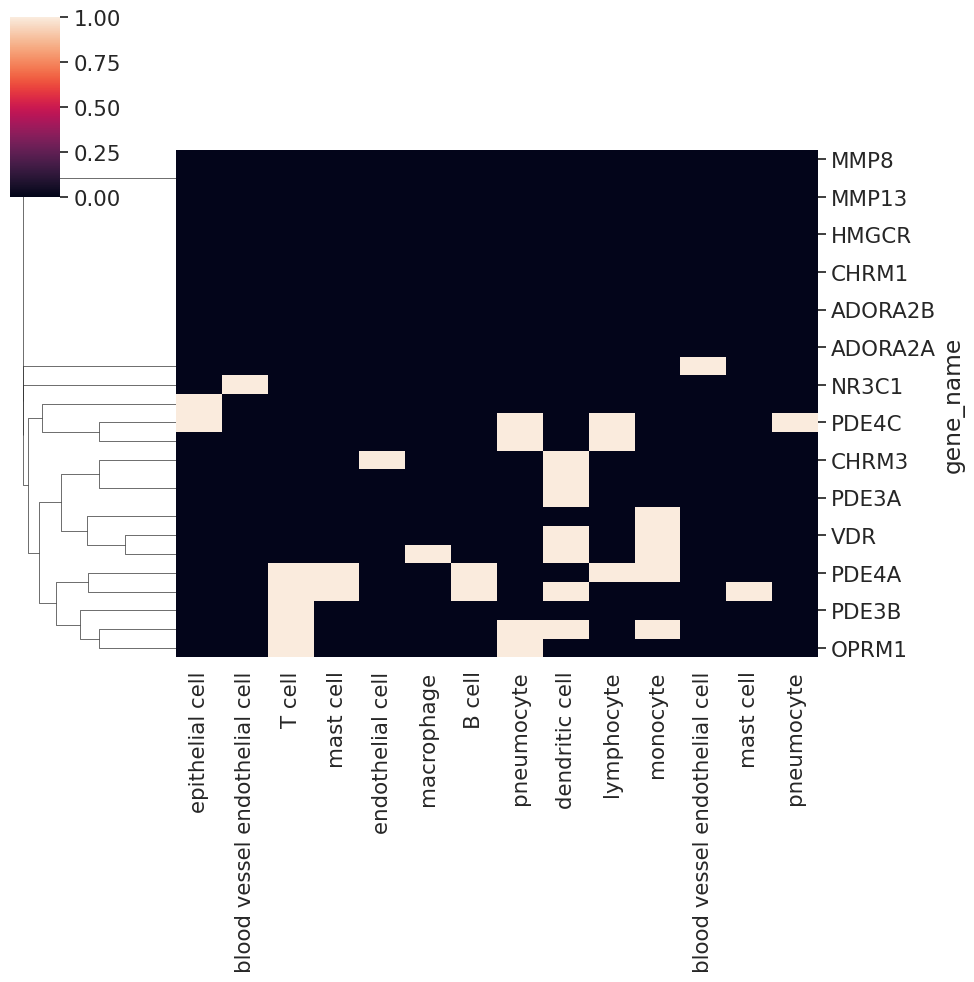

In [685]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_coarse[targets_res_coarse['is_approved'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [686]:
%%R -i pl_df -i ct_order_coarse -i row_order -i success_cols 
head(pl_df)

  gene_name                      celltype value evidence target_success
1      CA12               epithelial cell   yes  disease        targets
2     PDE4C               epithelial cell   yes  disease        targets
3     NR3C1 blood vessel endothelial cell   yes  disease        targets
4     PDE4A                        T cell   yes  disease        targets
5       CA2                        T cell   yes  disease        targets
6     OPRM1                        T cell   yes  disease        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


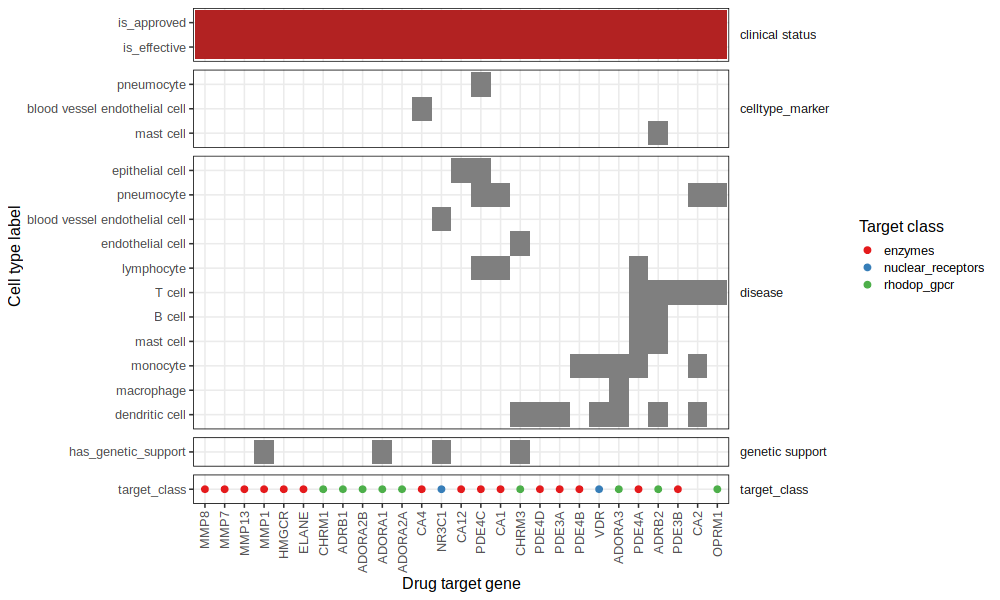

In [687]:
%%R -w 1000 -h 600
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_coarse), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=16) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

In [688]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

In [689]:
len(universe_dict['ab_tractable_targets'])

12527

In [690]:
targets_res_coarse[targets_res_coarse.gene_id.isin(universe_dict['ab_tractable_targets'])].sum()

Unnamed: 0                                                          50554209
gene_id                    ENSG00000001626ENSG00000004846ENSG00000007908E...
disease_ontology_id        MONDO_0005002MONDO_0005002MONDO_0005002MONDO_0...
genetic_association                                                62.419035
known_drug                                                         73.557941
is_druggable                                                           151.0
is_safe                                                                137.0
is_effective                                                           103.0
is_approved                                                             22.0
has_genetic_support                                                    259.0
ct_marker_evidence                                                     787.0
bulk_disease_evidence                                                  915.0
disease_evidence                                                      2614.0

#### What are the cell type targets prioritized?

In [696]:
gene_list = gene_names_df.loc[targets_res_coarse.gene_id[targets_res_coarse.ct_marker_evidence == 1].unique()].gene_name.tolist()
background = DE_ct_res_coarse.gene_name.unique()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/',
                 # no_plot=True,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

In [697]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

Gene_set  \
0         MSigDB_Hallmark_2020   
46  GO_Biological_Process_2017   
47  GO_Biological_Process_2017   
48  GO_Biological_Process_2017   

                                                 Term       P-value  \
0                   Epithelial Mesenchymal Transition  2.100715e-07   
46     extracellular matrix organization (GO:0030198)  8.700855e-08   
47                    muscle contraction (GO:0006936)  1.459337e-06   
48  G-protein coupled receptor signaling pathway (...  1.722601e-05   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0           0.000010            0                     0    2.497730   
46          0.000146            0                     0    3.111886   
47          0.001224            0                     0    6.341623   
48          0.009629            0                     0    2.537191   

    Combined Score                                              Genes  
0        38.404642  OXTR;ECM2;COL16A1;ELN;COL12A1;TNC;TNFAIP3;CXCL...  
46       50.590732  COL16A1;ITGAM;COL13A1;LAMA2;COL14A1;LAMC3;ELN;...  
47       85.215739  VIPR1;OXTR;TPM2;ITGA1;LMOD1;DYSF;SORBS1;SLC8A1...  
48       27.830674  CCL14;FCN1;VIPR1;FPR1;CXCR4;DEFB1;CXCL1;FPR2;P...

In [693]:
gene_list = gene_names_df.loc[targets_res_coarse.gene_id[targets_res_coarse.disease_evidence == 1].unique()].gene_name.tolist()
background = DE_res_coarse.gene_name.unique()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/',
                 # no_plot=True,
                 cutoff=1.0 # test dataset, use lower value from range(0,1)
                )

In [695]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

Gene_set                           Term   P-value  \
0  MSigDB_Hallmark_2020                 UV Response Dn  0.000011   
1  MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB  0.000061   
2  MSigDB_Hallmark_2020              Androgen Response  0.000076   
3  MSigDB_Hallmark_2020               mTORC1 Signaling  0.000314   
4  MSigDB_Hallmark_2020        Estrogen Response Early  0.000493   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.000541            0                     0    2.098227   
1          0.001264            0                     0    1.777094   
2          0.001264            0                     0    2.243806   
3          0.003924            0                     0    1.717656   
4          0.004928            0                     0    1.647431   

   Combined Score                                              Genes  
0       23.990696  PHF3;CELF2;SCHIP1;PTEN;PRDM2;LAMC1;NR3C1;TENT4...  
1       17.253428  BTG2;TNFAIP8;BTG1;CSF2;B4GALT1;CSF1;PLEK;TNC;R...  
2       21.287530  SRP19;TNFAIP8;STEAP4;B4GALT1;DBI;CDC14B;RPS6KA...  
3       13.855118  BTG2;TFRC;PITPNB;GBE1;SLC2A1;SLA;ATP2A2;TMEM97...  
4       12.545798  CLIC3;B4GALT1;NXT1;WWC1;HSPB8;SLC2A1;AQP3;AREG...

In [719]:
targets_res_coarse = pd.merge(targets_res_coarse, ens_ids_to_name, how='left')
for k,a in annos.items():
    targets_res_coarse[f'is_{k}'] = targets_res_coarse.gene_name.isin(a).astype('int')

gene_group_cols = [f'is_{k}' for k in annos.keys()]
targets_res_coarse['gene_class'] = np.where(
    targets_res_coarse[gene_group_cols].sum(1) > 0,
    targets_res_coarse[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
    'other'
        )

TypeError: Can only merge Series or DataFrame objects, a <class 'numpy.ndarray'> was passed

### COVID

In [1404]:
disease_ontology_id = 'MONDO_0005002'

In [1405]:
pbulk_adata_coarse = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad')

In [1407]:
## Read results with coarse annotations
targets_res_coarse = pd.read_csv(f'../data/disease_target_evidence.{disease_ontology_id}.csv')

In [1408]:
DE_res_coarse = pd.read_csv(f'../data/DE_diseasecelltype_{disease_ontology_id}.hvgs.csv')
DE_ct_res_coarse = pd.read_csv(f'../data/DE_celltype_{disease_ontology_id}.hvgs.csv')

In [1409]:
ct_order_coarse = ['fibroblast', 'adventitial cell', 'fibroblast of lung', 'brush cell of trachebronchial tree',
 'epithelial cell','epithelial cell of lung','pneumocyte',  'club cell', 'goblet cell', 'basal cell', 'epithelial cell of lower respiratory tract',
                   'ciliated cell','lung ciliated cell', 'multi-ciliated epithelial cell',
 'blood vessel endothelial cell',       'endothelial cell','mucus secreting cell',
  'muscle cell', 'contractile cell', 'smooth muscle cell',
 'lymphocyte', 'T cell','CD4-positive helper T cell',        'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell','B cell','natural killer cell',
 'mast cell','monocyte',   'macrophage', 'dendritic cell', 'myeloid cell','myeloid leukocyte', 'mononuclear cell', 
 'chondrocyte', 
       'stromal cell', 'neuron', 'enucleate erythrocyte',
'malignant cell'
       ]

/tmp/ipykernel_1790/4111283349.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_1790/4111283349.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
/tmp/ipykernel_1790/4111283349.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)


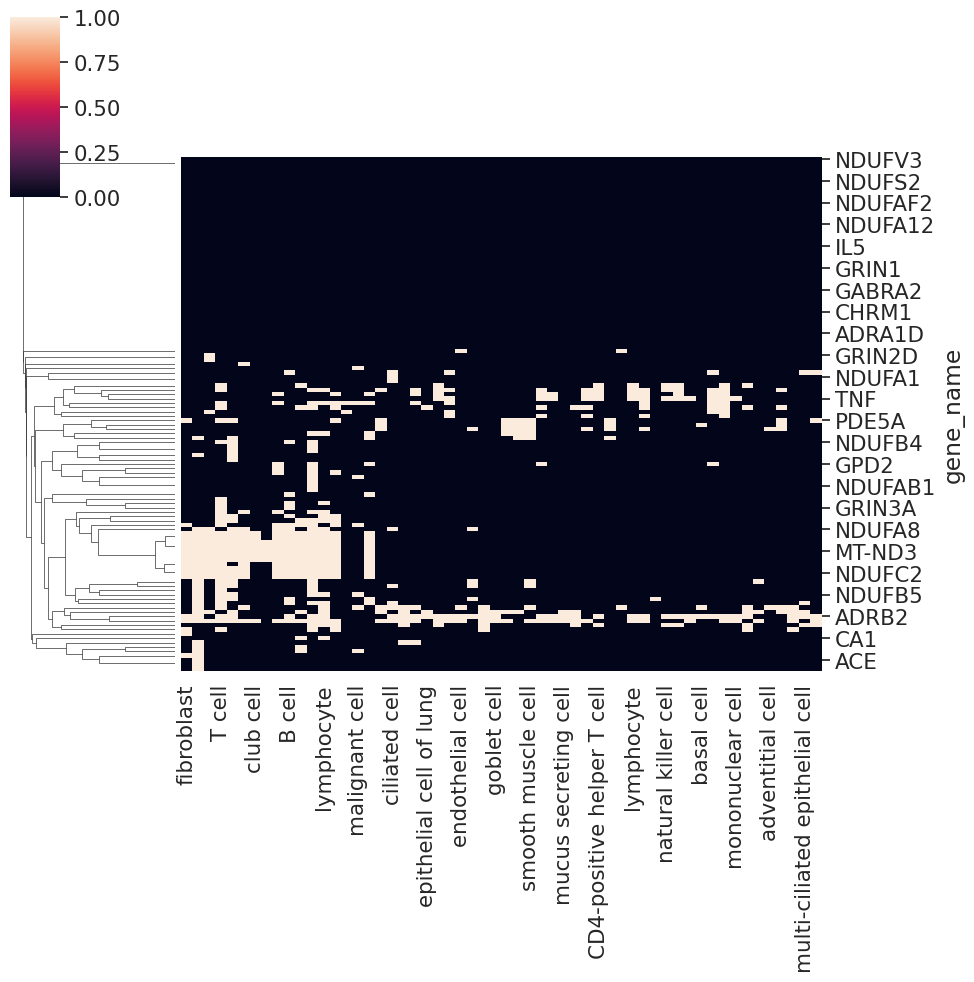

In [1410]:
success_cols = ['is_effective', 'is_approved', 'has_genetic_support']
cluster_clinical_status = False

keep_targets = targets_res_coarse[targets_res_coarse['is_effective'] == 1].gene_id
df_ct = get_evidence_celltypes(DE_ct_res_coarse[DE_ct_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='celltype'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_ct.index)
for t in missing_genes:
    df_ct.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_ct.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

df_dis = get_evidence_celltypes(DE_res_coarse[DE_res_coarse.gene_id.isin(keep_targets)], targets_res_coarse,
                       clinical_status_cols = success_cols, evidence='disease'
                      )
missing_genes = np.setdiff1d(gene_names_df.gene_name[gene_names_df.gene_id.isin(keep_targets)].values, df_dis.index)
for t in missing_genes:
    df_dis.loc[t] = 0
    t_id = gene_names_df.set_index('gene_name').loc[t][0]
    for col in success_cols:
        df_dis.loc[t, col] = targets_res_coarse.loc[targets_res_coarse.gene_id == t_id, col].values

# Get the row orders
cl_df = pd.concat([df_dis.drop(success_cols, 1), df_ct.drop(success_cols, 1)], axis=1)
cluster = sns.clustermap(cl_df, metric='jaccard', col_cluster=False)
row_order = cl_df.index[cluster.dendrogram_row.reordered_ind]

df_ct = df_ct.reset_index().melt( ['gene_name'] , var_name='celltype')
df_ct['evidence'] = 'celltype_marker'        
df_dis = df_dis.reset_index().melt( ['gene_name'] , var_name='celltype')
df_dis['evidence'] = 'disease'

pl_df = pd.concat([df_dis, df_ct])
pl_df['evidence'] = np.where(pl_df.celltype.isin(success_cols), 'clinical status', pl_df['evidence'])
pl_df['evidence'] = np.where(pl_df.celltype == ('has_genetic_support'), 'genetic support', pl_df['evidence'])

if cluster_clinical_status:
    pl_df['target_success'] = 'is_effective'
    for c in success_cols:
        print(c)
        pl_df['target_success'] = np.where(pl_df.gene_name.isin(pl_df.gene_name[(pl_df.celltype == c) & (pl_df.value == 1)]), c, pl_df['target_success'])
else:
    pl_df['target_success'] = 'targets'

    
pl_df['target_class'] = [reversed_annos[x] if x in reversed_annos.keys() else np.nan for x in pl_df.gene_name]

target_df = pl_df[['gene_name', 'target_class']].drop_duplicates()
target_df.columns = ['gene_name', 'value']
target_df['celltype'] = 'target_class'
target_df['evidence'] = 'target_class'
pl_df = pd.concat([pl_df, target_df]).drop('target_class', 1)

pl_df.loc[pl_df.value == 1, 'value'] = 'yes'
pl_df = pl_df[pl_df.value != 0].copy()

In [1411]:
%%R -i pl_df -i ct_order_coarse -i row_order -i success_cols 
head(pl_df)

  gene_name   celltype value evidence target_success
1       CA2 fibroblast   yes  disease        targets
2    NDUFS7 fibroblast   yes  disease        targets
3    ADRA1A fibroblast   yes  disease        targets
4      MMP7 fibroblast   yes  disease        targets
5     PDE5A fibroblast   yes  disease        targets
6    NDUFC2 fibroblast   yes  disease        targets


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


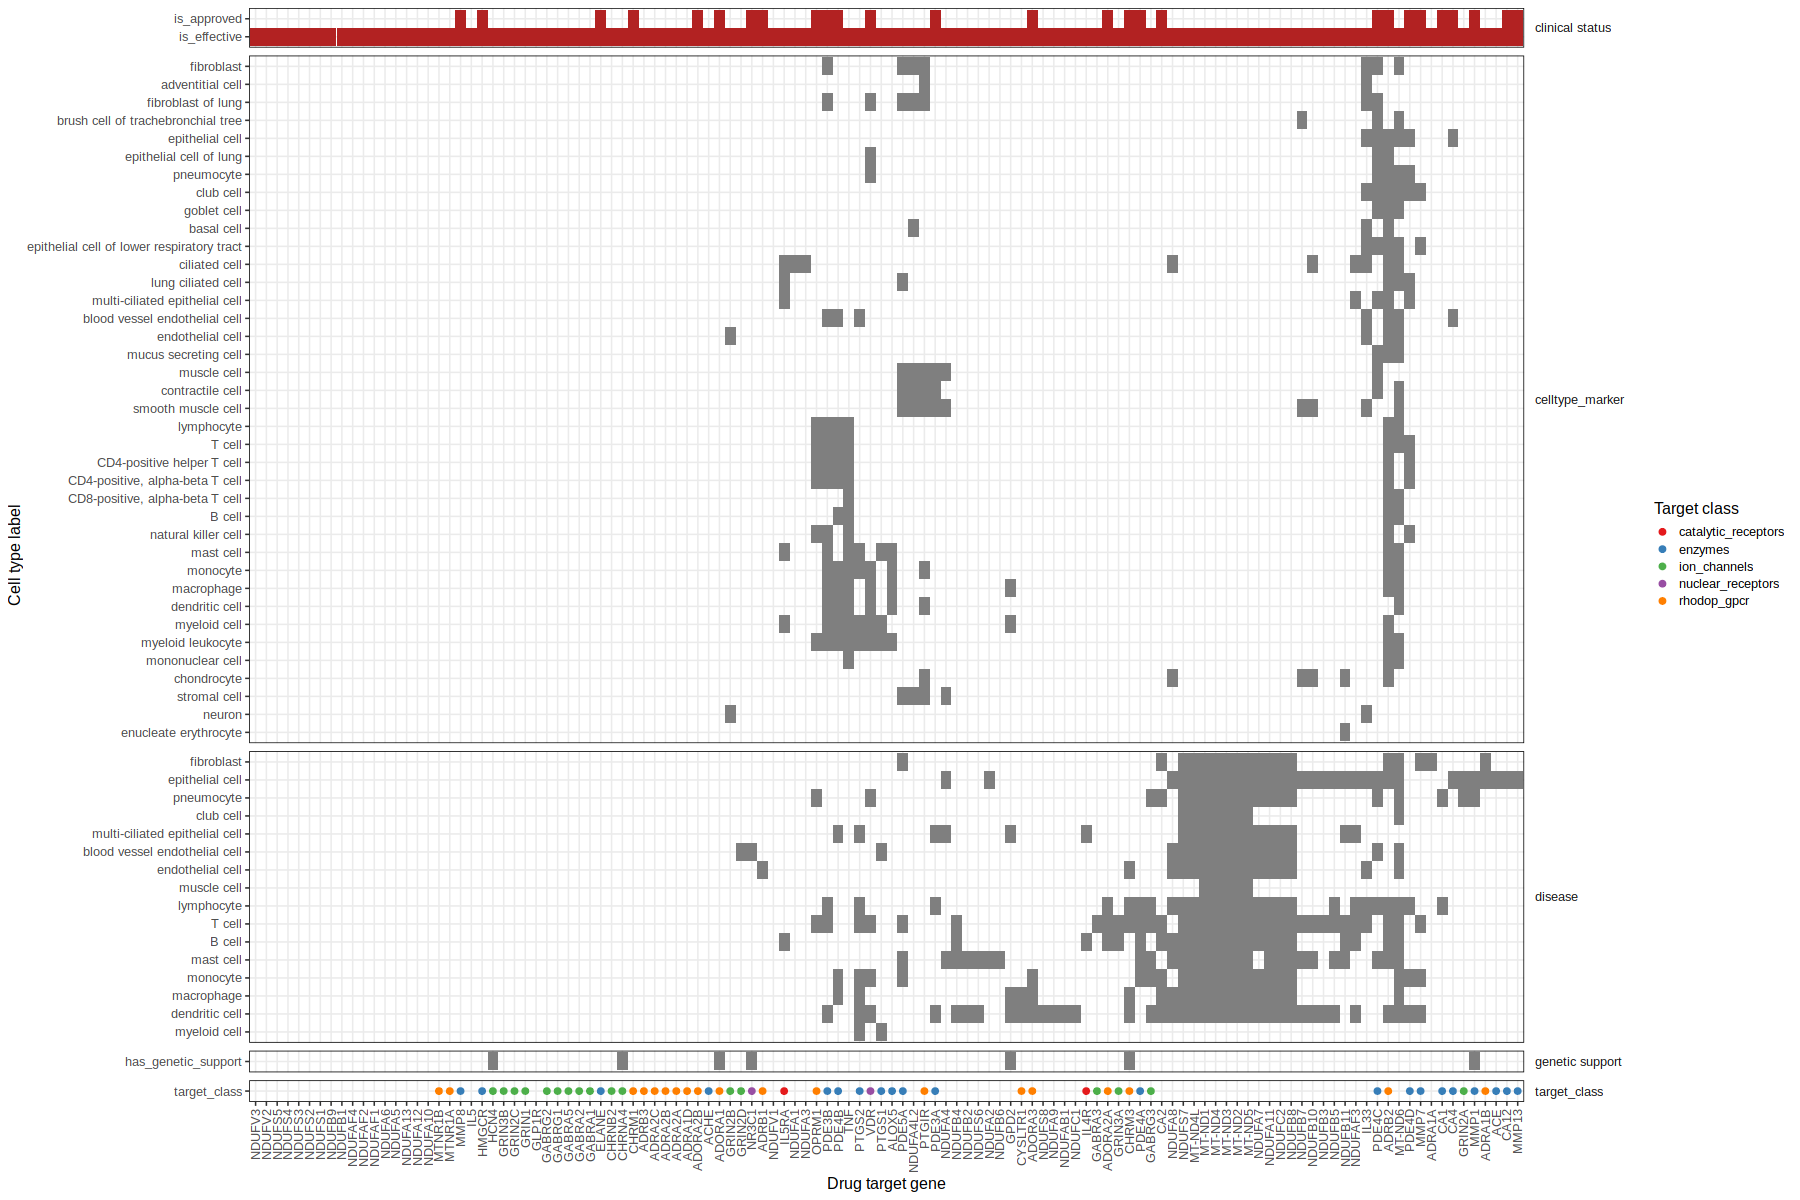

In [1426]:
%%R -w 1800 -h 1200
pl_df %>%
    filter(celltype != 'malignant cell') %>%
    mutate(evidence = factor(evidence, levels=c('clinical status','celltype_marker', 'disease','genetic support',  'target_class'))) %>%
    mutate(celltype = factor(celltype, levels=c('target_class', rev(ct_order_coarse), success_cols))) %>%
    mutate(gene_name = factor(gene_name, levels=row_order)) %>%
    ggplot(aes(gene_name, celltype)) +
    geom_tile(data = . %>% filter(evidence != 'target_class'),fill='grey50') +
    geom_tile(data = . %>% filter(evidence == 'clinical status'),
              fill='firebrick') +
    geom_point(data = . %>% filter(celltype == 'target_class' & !is.na(value)), 
               aes(color=value), size=3) +
    facet_grid(evidence~., scales='free', space='free') +
    scale_color_brewer(palette='Set1', name='Target class') +
    theme_bw(base_size=16) +
    ylab('Cell type label') + xlab('Drug target gene') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), 
          strip.text.y = element_text(angle=0, hjust=0),
          strip.background = element_rect(fill = "transparent", color=NA),
           strip.placement = "outside",
            panel.border = element_rect(color = "black", fill = NA)
         )

### Is the target expression influencing the detection?

In [1413]:
sc.pp.normalize_total(pbulk_adata_coarse)
sc.pp.log1p(pbulk_adata_coarse)

In [1414]:
target_mean_expression = pbulk_adata_coarse[:, targets_res_coarse.gene_id.values].X.A.mean(0)

In [1415]:
targets_res_coarse['mean_expression'] = pbulk_adata_coarse[:, targets_res_coarse.gene_id.values].X.A.mean(0)
targets_res_coarse['mean_expression_normal'] = pbulk_adata_coarse[pbulk_adata_coarse.obs.disease == 'normal',:][:, targets_res_coarse.gene_id.values].X.A.mean(0)
targets_res_coarse['mean_expression_disease'] = pbulk_adata_coarse[pbulk_adata_coarse.obs.disease != 'normal',:][:, targets_res_coarse.gene_id.values].X.A.mean(0)

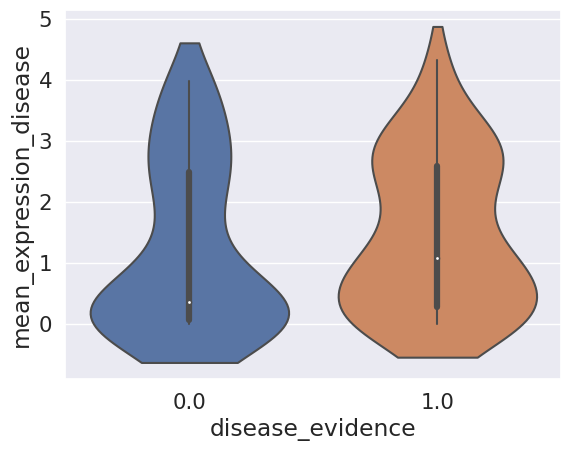

<AxesSubplot: xlabel='ct_marker_evidence', ylabel='mean_expression_normal'>

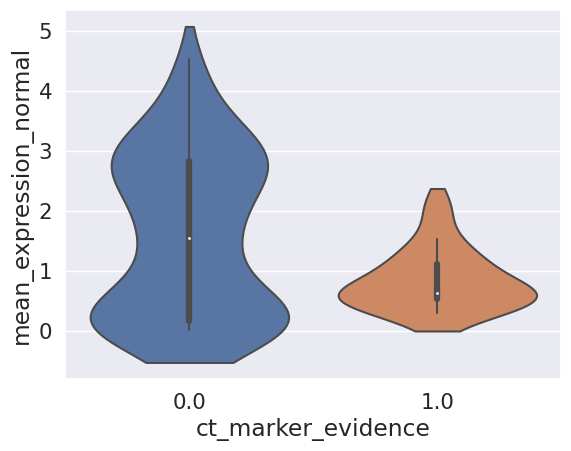

In [1416]:
sns.violinplot(data=targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)],
               x='disease_evidence', y='mean_expression_disease', cut=True, scale='width'
              )
plt.show()
sns.violinplot(data=targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)],
               x='ct_marker_evidence', y='mean_expression_normal', cut=True, scale='width'
              )

In [1417]:
print(scipy.stats.pearsonr(
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['disease_evidence'], 
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse['disease_evidence'], 
    targets_res_coarse['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['ct_marker_evidence'], 
    targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal']
))

print(scipy.stats.pearsonr(
    targets_res_coarse['ct_marker_evidence'], 
    targets_res_coarse['mean_expression_normal']
))
# scipy.stats.pearsonr(targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['ct_marker_evidence'], targets_res_coarse[targets_res_coarse.gene_id.isin(keep_targets)]['mean_expression_normal'])

PearsonRResult(statistic=0.27031675073864536, pvalue=0.0030718653488533668)
PearsonRResult(statistic=0.2007672195044454, pvalue=3.4874169598295955e-89)
PearsonRResult(statistic=-0.18842829837728772, pvalue=0.04101201919000492)
PearsonRResult(statistic=-0.19668424444840665, pvalue=1.3383250875094783e-85)


In [1418]:
pl_targets = gene_names_df[(gene_names_df.gene_name.str.startswith("NDUF")) & ( gene_names_df.gene_id.isin(keep_targets))].gene_name

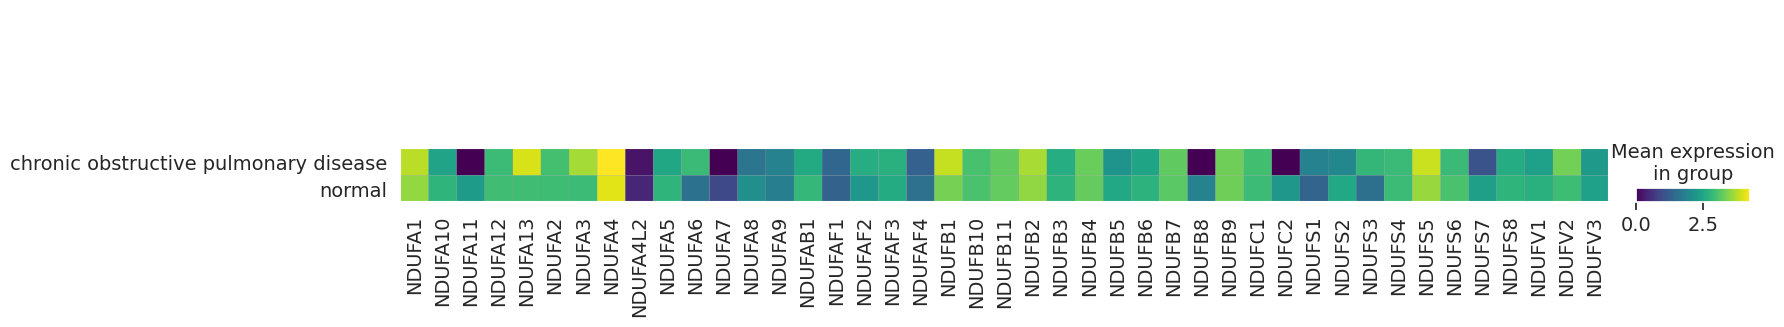

In [1419]:
sc.pl.matrixplot(pbulk_adata_coarse, pl_targets, groupby='disease', gene_symbols='feature_name')

In [1420]:
targets_res_coarse = pd.merge(targets_res_coarse, gene_names_df, how='left')

<AxesSubplot: xlabel='gene_name', ylabel='mean_expression_normal'>

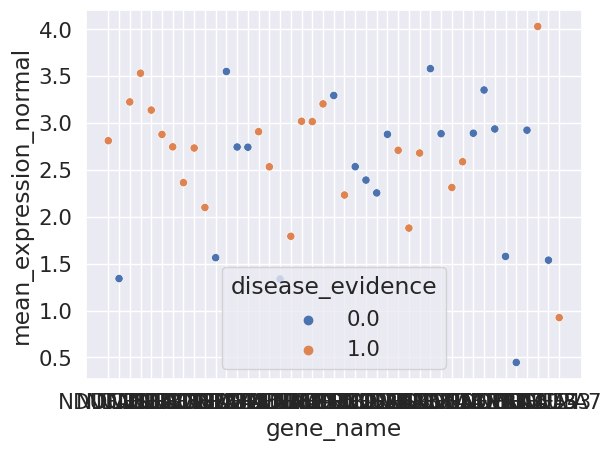

In [1423]:
sns.scatterplot(data=targets_res_coarse[(targets_res_coarse.gene_name.isin(pl_targets))],x='gene_name', hue='disease_evidence',y='mean_expression_normal')